# Surfactant systems data

Hello Bryan,

This jupyter notebook is a long protocol on how the concentrations 
we are looking at have been derived from SDS and CTAB adosrption experiments.

Most stuff is "rubbish". Just look at
* 1.2.2.3 Chen 2009, Fig 4a: potential-dependent adsorption,
  0.32 mM SDS in 50 mM KClO4/H2O
* 1.2.2.3 Chen 2009, Fig 8a: potential-dependent adsorption, pure 16 mM SDS/H2O
* 1.2.2.4 SKLT 2017, unpublished
* 1.2.2.5 Kawasaki 2007
* 1.4 Poster Plot

The first two entries are surface potential dependent adsorption isotherms. Not
that suitable for our current systems.

Our SDS concentrations have been based upon unpublished adosption data by the
SKLT (State Key Laboratory of Tribology) of Tsinghua University in Beijing. Our
CTAB concentrations have been using have been derived from Kawasaki 2007.

The datapoints we are working with you see as red dots in the section **1.4
Poster Plot**

Attached you also find the most expressive figures from this notebook, under
`fig`.

All the original data used for these plots here you find within our
`N_surfactant_on_substrate_template` git repository under
`ref/dat/kawasaki2007influence_fig1b.csv` and
`ref/dat/sklt_unpublished_fig1.csv` (or within the `dat` folder of this
archive).

Now, this April the SKLT recorded a proper SDS on gold adsorption isotherm for
me (by QCM measurements), the data you find as an excel file and already as an
image as well under `exp`.

The measured quantity there is adsorption mass in ng/cm^2. I would like to have
this data converted to surface number concentrations and its reciprocal, the
area per molecule. The notebook header already prepares molar masses and other
conversion factors and helper functions for this purpose. Look at *1.2.2.4 SKLT
2016, unpublished* how the conversion is done, that should be the same units.

Eventually, we want to get a figure with our data points displayed on the
isotherm, just as *kawasaki2007ctab--selected-discrete-data-points.png* and for
comparison
*kawasaki2007ctab--sklt2017sds_unpublished--selected-discrete-data-points.png*.
Ideally, just redo these two plots in the section **1.4 Poster Plot** with the
previous "SKLT unpublished" data replaced by the recent QCM results.

Have a nice weekend,

Johannes


In [106]:
# set accordingly:
prefix = '/mnt/dat/work/testuser/adsorption/N_surfactant_on_substrate_template'

## Header

### Imports

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import scipy as scp
import scipy.interpolate
import scipy.constants as C
import ase.data

import os

In [108]:
# for storing files in database
from fireworks.utilities.filepad import FilePad, LAUNCHPAD_LOC

### Global settings

In [109]:
%matplotlib inline

In [110]:
# matplotlib settings

# expecially for presentation, larger font settings for plotting are recommendable
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure titlex

plt.rcParams["figure.figsize"] = (11,7) # the standard figure size

### Supportive functions & snippets

In [111]:
def df_crossjoin(df1, df2, **kwargs):
    """Creates row-wise cartesian product of two data frames"""
    df1['_tmpkey'] = 1
    df2['_tmpkey'] = 1

    res = pd.merge(df1, df2, on='_tmpkey', **kwargs).drop('_tmpkey', axis=1)
    #res.index = pd.MultiIndex.from_product((df1.index, df2.index))

    df1.drop('_tmpkey', axis=1, inplace=True)
    df2.drop('_tmpkey', axis=1, inplace=True)

    return res

In [112]:
def subplotPosition(rows,cols):
    """generator for subplot positions"""
    for p in range(0,rows*cols):
        yield rows*100+cols*10+p+1

def addSubplot(x, y,
               title=None, xlabel=None, ylabel=None, legend=None, fmtstr=None,
               fig=None, ax=None, pos=None, figsize=(8,5)):
    """facilitate matplotlib figure & subplot creation. only one data series per call."""
    
    if not pos:
        pos = 111
    if not fig and not ax:
        fig = plt.figure(figsize=figsize)
    elif not fig and ax:
        fig = ax.get_figure()
    if not ax:
        ax = fig.add_subplot(pos)
      
    if fmtstr and legend:
        ax.plot(x,y,fmtstr,label=legend)
    elif fmtstr:
        ax.plot(x,y,fmtstr)         
    elif legend:
        ax.plot(x,y,label=legend)
    else:
        ax.plot(x,y)
               
    if title:
        ax.set_title(title)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
        
    if legend:
        ax.legend()
        
    return fig, ax

#### Constants

In [113]:
AU = C.value("atomic mass constant")

In [114]:
AU

1.66053904e-27

In [115]:
C.atomic_mass # kg

1.66053904e-27

#### ASE atomic data

In [116]:
ad = pd.DataFrame(data={"symbol": ase.data.chemical_symbols,
                                "name"  : ase.data.atomic_names,
                                "mass"  : ase.data.atomic_masses } ) # atomic data

In [117]:
str_DSm = {'C': 12, 'H': 25, 'S': 1, 'O': 4}
str_CTAp = {'C': 19, 'H': 42, 'N': 1}

In [118]:
M_Br = ad[ ad.symbol == "Br" ]['mass'].values[0] * C.gram # a bit too much

In [119]:
M_Na = ad[ ad.symbol == "Na" ]['mass'].values[0] * C.gram

In [120]:
M_DSm = 0
for sym, n in str_DSm.items():
    M_DSm += ad[ ad.symbol == sym ]['mass'].values[0] * n * C.gram

In [121]:
M_CTAp = 0
for sym, n in str_CTAp.items():
    M_CTAp += ad[ ad.symbol == sym ]['mass'].values[0] * n * C.gram

In [122]:
M_SDS_sum = M_DSm + M_Na
M_CTAB_sum = M_CTAp + M_Br

In [575]:
M_DSm

0.265388

In [576]:
M_CTAp

0.28455199999999997

In [123]:
M_SDS  = 288.372 * C.gram # kg / mol, Na+ inclusively, 
M_CTAB = 364.45  * C.gram  # kg / mol, Br- inclusively, https://en.wikipedia.org/wiki/Cetrimonium_bromide

In [124]:
M_CTAp # molecular mass 

0.28455199999999997

In [125]:
M_CTAB

0.36445

In [126]:
M_SDS_sum - M_SDS

5.769280000011978e-06

In [127]:
M_CTAB_sum - M_CTAB

6.0000000000060005e-06

In [128]:
def cMolar(massFraction, molarMassSolute, solventDensity=0.997):
    # default density: water at 298 K and 1013 hPa, [density] = kg dm^-3 = kg L^-3
    # cMolar_i = massFraction_i * rho / M_i
    # where M is the solute's i molar mass, 
    # and rho the solution's density ( ~ solvent's density at low concentrations)
    return massFraction*solventDensity / molarMassSolute # mol L^-3 = M

In [129]:
def cal2J(e):
    return e/C.calorie

In [130]:
def J2cal(e):
    return e/C.calorie

In [131]:
def sigma2R(sigma): # LJ parameter conversion:
    return 2.0**(1.0/6.0)*sigma

In [132]:
sigma2R(4.83)/2

2.7107458466671357

In [133]:
C.calorie

4.184

In [134]:
J2cal(0.21)

0.05019120458891013

### Properties, classifications, etc

#### Surfactant systems

In [30]:
solute = ["CTAB", "CTAC", "C14TAB", "C16TAOH", "DDAPS", "DeTATf", "LPPC", "SDS"]

In [31]:
solvent = ["H2O","PC"]

In [32]:
substrate = ["alumina","gold","graphite","mica","silica"]

In [33]:
crystal_plane = [100, 111, 110]

In [34]:
adaggregate_shapes = ["micellar", "hemimicellar", "cylindrical", "hemicylindrical", 
                     "monolayer", "bilayer"]

In [35]:
micellar_shapes = ["globular", "oblate", "rod-like"]

In [36]:
columns_surfactant_properties_df = [
                        "surfactant", 
                        "solvent",
                        "cmc_1st",
                        "cmc_2nd",
                        "krafft_temperature",
                        "reference_key",
                        "reference_comment"]

In [37]:
surfactant_properties_df = pd.DataFrame(columns=columns_surfactant_properties_df)

In [38]:
surfactant_properties_df.append( {
    "surfactant": "CTAB",
    "solvent": "water",
    "cmc_1st": 0.92e-3, # M
    "cmc_2nd": 0.27, # M
    "krafft_temperature": 298, # K
    "reference_key": "dasilva2018molecular",
    "reference_comment": "Da Silva, J. A., Dias, R. P., Da Hora, G. C. A., Soares, T. A., & Meneghetti, M. R. (2018). Molecular dynamics simulations of cetyltrimethylammonium bromide (CTAB) micelles and their interactions with a gold surface in aqueous solution. Journal of the Brazilian Chemical Society, 29(1), 191–199. https://doi.org/10.21577/0103-5053.20170130"
}, ignore_index=True)

,surfactant,solvent,cmc_1st,cmc_2nd,krafft_temperature,reference_key,reference_comment
0,CTAB,water,0.00092,0.27,298,dasilva2018molecular,"Da Silva, J. A., Dias, R. P., Da Hora, G. C. A..."


In [39]:
columns_reference_df = ["unique_key",
                        "category",
                        "surfactant", 
                        "ff", 
                        "ff_comment", 
                        "pbc", 
                        "production_time", 
                        "ensemble",
                        "solvent",
                        "solvent_model",
                        "reference_key",
                        "reference_comment"]

In [40]:
columns_charmm_specific = ['parameter_set',
                           'inner_lj_cutoff',
                           'outer_lj_cutoff',
                           'inner_coulomb_cutoff',
                           'outer_coulomb_cuttof',
                           'lj_switching']

In [41]:
columns_sds_specific = ['sds_model', 'sodium_model']

In [42]:
columns_ctab_specific = ['ctab_model','bromide_model']

In [43]:
columns_aggregate_properties = [
    'rgyr', 
    'rdf_COM_head', 
    'rdf_COM_tail', 
    'rdf_COM_solvent', 
    'rdf_head_ion', # ion here means counter ion, i.e. Na+ or Br-
    'rdf_head_head', # vague
    'rdf_tail_tail',
    'rdf_ion_ion',
    'rdf_solvent_solvent',
    'aggregation_number',
]

In [44]:
columns_experimental = [ "surfactant", "solvent", "cmc1st", "cmc2nd", 
                         "T_Krafft", "reference_key", "reference_comment"]
experimental_template = pd.Series(index=columns_experimental)

#### Simulation

In [45]:
columns_simulation_properties = ["surfactant", "sf_preassembly", 
                                 "sf_nmolecules", "sf_natoms",
                                 "sf_concentration", # M
                                 "substrate", "sb_crystal_plane", 
                                 "sb_unit_cell", "sb_multiples", "sb_natoms",
                                 "counterion", "ci_initial_placement", 
                                 "ci_nmolecules",
                                 "solvent", "sv_density", "sv_preassembly", 
                                 "sv_nmolecules", "sv_natoms",
                                 "pbc", # 111
                                 "box", # Ang     
                                 "temperature", # applies to NVT, NPT
                                 "pressure", # applies to all NPT
                                 # MINIMIZATION ?
                                 "minimization_steps",
                                 # NVT EQUILIBRATION
                                 "nvt_equilibration_steps",
                                 # NPT EQUILIBRATION
                                 "npt_equilibration_steps",
                                 # NPT PRODUCTION
                                 "npt_production_steps",
                                 # MORE TO FOLLOW
                                 
                                 "code",
                                 #"ff", 
                                 #"ff_comment",
                                
                                 "comments"]

In [46]:
columns_simulation_performance = ["code",
                                  "steps",
                                  "natoms",
                                  "machine",
                                  "nodes",
                                  "ppn",
                                  "mpi_tasks",
                                  "omp_threads",
                                  "cpu_time",
                                  "runtime",
                                  "ns_per_day" 
                                 ]

## Previous work on surfactant aggregation

Growing collection of standardized micellizationd and adsorption MD setups and results.


Starting point:

Indelicato, S., Bongiorno, D., Calabrese, V., Perricone, U., Almerico, A. M., Ceraulo, L., … Tutone, M. (2017). Micelles, Rods, Liposomes, and Other Supramolecular Surfactant Aggregates: Computational Approaches. Interdisciplinary Sciences: Computational Life Sciences. https://doi.org/10.1007/s12539-017-0234-7

### Overview

#### SDS experimantal

* at interface:
  * on gold:
      * Schniepp, H.C., Shum, H.C., Saville, D.A., Aksay, I.A., 2008. Orientational order of molecular assemblies on rough surfaces. J. Phys. Chem. C 112, 14902–14906.
      * D.P. Benton, B.D. Sparks, Trans. Faraday Soc. 62 (1966) 3244–3252.


#### CTAB experimental
To record:

* at interface
  * __steel__: Xie, G., Luo, J., Liu, S., Guo, D., 2011. Electrical potential modulation of dynamic film properties of aqueous surfactant solutions through a nanogap. J. Appl. Phys. 109, 24309. 
  * __mica__: Lamont, R.E., Ducker, W.A., 1997. Surface-Induced Transformations for Surfactant Aggregates. 
    J. Am. Chem. Soc 120, 7602–7607. (on mica)
  * __gold__: 
    * Shi, L., Ghezzi, M., Caminati, G., Nostro, P. Lo, Grady, B.P., Striolo, A., 2009. 
      Adsorption isotherms of aqueous C12e6and cetyltrimethylammonium bromide surfactants on solid surfaces 
      in the presence of low molecular weight coadsorbents. Langmuir 25, 5536–5544.
    * Gutig, C., Grady, B.P., Striolo, A., 2008. 
      Experimental studies on the adsorption of two surfactants on solid-aqueous interfaces: 
      Adsorption isotherms and kinetics. Langmuir 24, 4806–4816.
    * Kawasaki, H., Nishimura, K., Arakawa, R., 2007. 
      Influence of the counterions of cetyltrimetylammonium salts on the surfactant adsorption 
      onto gold surfaces and the formation of gold nanoparticles. J. Phys. Chem. C 111, 2683–2690.
    * Knag, M., Sjöblom, J., Gulbrandsen, E., 2005. 
      The effect of straight chain alcohols and ethylene glycol on the adsorption of CTAB on gold. 
      J. Dispers. Sci. Technol. 26, 207–215.  
      QCM, no AFM
    * Byloos, M., Al-Maznai, H., Morin, M., 2001. 
      Phase transitions of alkanethiol self-assembled monolayers at an electrified gold surface. 
      J. Phys. Chem. B 105, 5900–5905.  
      CV, no AFM images
    * **Jaschke, M., Butt, H.-J., Gaub, H.E., Manne, S., 1997.**
      Surfactant Aggregates at a Metal Surface. Langmuir 13, 1381–1384.
  
* ~~Ducker et al., ACS Pub., 1996~~ (although not in focus, has some bits on CTAB (on mica))
* Sepulveda et al., J. Phys. Chem., 1985 (partially evaulated)
* **Paredes et al. J. Phys. Chem., 1984**: CTAB and other CTAX, cmc with different additives
* Mukerjee, Mysels, Nat. Std. Ref. Dat. Sys., 1971 (CMC database)
* ~~Reiss-Husson et al., J Phys. Chem., 1964~~ (more interesting data still in papar, i.e. CACl)





#### SDS MD

* in bulk
    * Farafonov et al., ACS Pub., 2017 
    * Kawada, S., Komori, M., Fujimoto, K., Yoshii, N., Okazaki, S., 2016. Molecular dynamics study of the formation mechanisms of ionic SDS and nonionic C12E8micelles and n-dodecane droplets. Chem. Phys. Lett. 646, 36–40. CHARMM36
    * **Volkov, N.A., Tuzov, N. V., Shchekin, A.K., 2016. Molecular dynamics study of salt influence on transport and structural properties of SDS micellar solutions. Fluid Phase Equilib. 424, 114–121.**
      CHARMM36
    * __Tang et al., ACS Pub., 2014__
    * Yan, H., Cui, P., Liu, C.-B., Yuan, S.-L., 2012. Molecular Dynamics Simulation of Pyrene Solubilized in a Sodium Dodecyl Sulfate Micelle. Langmuir 28, 4931–4938.
    * Palazzesi et al., Royal Society of Chemistry, 2011
    * Shang et al., ACS Pub., 2008
    * Sammalkorpi et al., ACS Pub., 2007:
      * Sammalkorpi, M., Karttunen, M., Haataja, M., 2007. Structural properties of ionic detergent aggregates: a large-scale molecular dynamics study of sodium dodecyl sulfate. J. Phys. Chem. B 111, 11722–33.
    * Yoshii et al., J. Chem. Phys. / Chem. Phys. Let. / Cond. Matt. Phys.,	2006 and 2007
      * Yoshii, N., Okazaki, S., 2006. A molecular dynamics study of surface structure of spherical SDS micelles. Chem. Phys. Lett. 426, 66–70.
      * Yoshii, N., Iwahashi, K., Okazaki, S., 2006. A molecular dynamics study of free energy of micelle formation for sodium dodecyl sulfate in water and its size distribution. J. Chem. Phys. 124, 184901.
      * Yoshii, N., Okazaki, S., 2006. A molecular dynamics study of structural stability of spherical SDS micelle as a function of its size. Chem. Phys. Lett. 425, 58–61.
      * Yoshii, Okazaki, 2007. A molecular dynamics study of structure and dynamics of surfactant molecules in SDS spherical micelle. Condens. Matter Phys. 10, 573.
    * Bruce et al., 2002
      * Bruce, C.D., Berkowitz, M.L., Perera, L., Forbes, M.D.E., 2002. Molecular dynamics simulation of sodium dodecyl sulfate micelle in water: Micellar structural characteristics and counterion distribution. J. Phys. Chem. B 106, 3788–3793.
      * Bruce, C.D., Senapati, S., Berkowitz, M.L., Perera, L., Forbes, M.D.E., 2002. Molecular Dynamics Simulations of Sodium Dodecyl Sulfate Micelle in Water: The Behavior of Water. J. Phys. Chem. B 106, 10902–10907.
    * Schweighofer et al., ACS Pub., 1997
    * ~~MacKerell, J. Phys. Chem., 1995~~
    * **Shelley et al., Int. J. of Quantum Chemistry, 1990** (initial SDS parametrization)
* at interface 
    * Peredo-Mancilla, D., Dominguez, H., 2016. Adsorption of phenol molecules by sodium dodecyl sulfate (SDS) surfactants deposited on solid surfaces: A computer simulation study. J. Mol. Graph. Model. 65, 108–112.
    * Núñez-Rojas, E., Domínguez, H., 2011. Computational studies on the behavior of Sodium Dodecyl Sulfate (SDS) at TiO2(rutile)/water interfaces. J. Colloid Interface Sci. 364, 417–427.
    * Domínguez, H., 2010. Structure of the SDS/1-dodecanol surfactant mixture on a graphite surface: A computer simulation study. J. Colloid Interface Sci. 345, 293–301.
    * Dominguez, H., Berkowitz, M.L., 2000. Computer simulations of sodium dodecyl sulfate at liquid/liquid and liquid/vapor interfaces. J. Phys. Chem. B 104, 5302–5308.
    * **Schweighofer, K.J., Essmann, U., Berkowitz, M., 1997. Simulation of Sodium Dodecyl Sulfate at the Water−Vapor and Water−Carbon Tetrachloride Interfaces at Low Surface Coverage. J. Phys. Chem. B 101, 3793–3799.** (first interfacial MD of SDS)

#### CTAB MD

* at interface
    * **Da Silve et al., Journal of the Brazilian Chemical Society, 2018**
    * **Meena et al., PCCM 2016, Langmuir 2013**
    * **Bandyopadhyay, S., Shelley, J.C., Tarek, M., Moore, P.B., Klein, M.L., 1998. Surfactant Aggregation at a Hydrophobic Surface. J. Phys. Chem. B 102, 6318–6322.** (qualitatively interesting)

* in bulk
    * Liu et al., J. Phys. Chem. B, 2014
    * Mills et al., J. Phys. Chem. B, 2014
    * Chen et al., PCCP, 2013
    * ~~Storm et al., Langmuir, 2013~~
    * Feng et al., Soft Matter, 2011
    * Catá et al., Soft Matter, 2011
    * Wang et al., Biochemistry, 2009
    * Stephenson et al., Langmuir,  2006

  

### At interface, experimental

#### Benton 1966

In [47]:
#!cat 'data/references/benton1966adsorption/fig1_SDS.csv' | head

In [48]:
exp_benton1966_fig1_sds_data_raw = pd.read_csv(
    os.path.join(prefix,'ref','dat','benton1966adsorption','fig1_SDS.csv'),
    delimiter=',',comment='#',header=None,names=["c","GammaN"])
# c      : concentration (in fractions of cmc = 8.1 mM)
# GammaN : surface number density (in 10^13 molecules / cm^2)

In [49]:
exp_benton1966_fig1_sds_fit_data_raw = pd.read_csv(
    os.path.join(prefix,'ref','dat','benton1966adsorption','fig1_SDS_fit.csv'),
    delimiter=',',comment='#',header=None,names=["c","GammaN"])
# c      : concentration (in fractions of cmc = 8.1 mM)
# GammaN : surface number density (in 10^13 molecules / cm^2)

In [50]:
exp_benton1966_sds_cmc = 8.11 # mM

In [51]:
C.centi

0.01

In [52]:
exp_benton1966_fig1_sds_data = pd.concat([    
    exp_benton1966_fig1_sds_data_raw[["c"]] * exp_benton1966_sds_cmc * C.milli, # mM --> M
    exp_benton1966_fig1_sds_data_raw[["GammaN"]] * 1e13 # molecules cm^-2 \
        / C.Avogadro # molecules cm^-2 --> moles cm^-2 \
        / C.centi**2 #  moles cm^-2 --> moles m^-2
    ], axis=1)

In [53]:
exp_benton1966_fig1_sds_data.columns = ['c','GammaC']

In [54]:
exp_benton1966_fig1_sds_fit_data = pd.concat([    
    exp_benton1966_fig1_sds_fit_data_raw[["c"]] * exp_benton1966_sds_cmc * C.milli,
    exp_benton1966_fig1_sds_fit_data_raw[["GammaN"]] * 1e13 # molecules cm^-2 \
        / C.Avogadro # molecules cm^-2 --> moles cm^-2 \
        / C.centi**2 #  moles cm^-2 --> moles m^-2
    ], axis=1)

In [55]:
exp_benton1966_fig1_sds_fit_data.columns = ['c','GammaC']

In [56]:
exp_benton1966_fig1_sds_data[["GammaN"]] = exp_benton1966_fig1_sds_data[["GammaC"]] * C.Avogadro
exp_benton1966_fig1_sds_fit_data[["GammaN"]] = exp_benton1966_fig1_sds_fit_data[["GammaC"]] * C.Avogadro

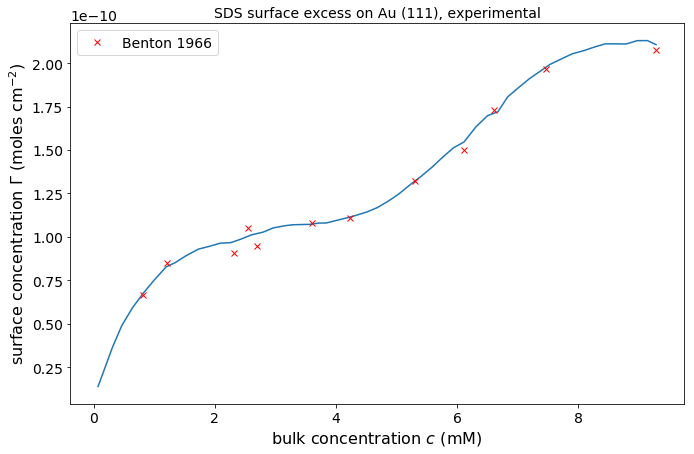

In [57]:
plt.plot(exp_benton1966_fig1_sds_fit_data[["c"]] / C.milli,
             exp_benton1966_fig1_sds_fit_data[["GammaC"]]*C.centi**2)
plt.plot(exp_benton1966_fig1_sds_data[["c"]] / C.milli, 
             exp_benton1966_fig1_sds_data[["GammaC"]]*C.centi**2,
             'ro', label = "Benton 1966", marker='x')
plt.xlabel(r'bulk concentration $c \ (\mathrm{mM})$')
plt.ylabel(r'surface concentration $\Gamma \ (\mathrm{moles \ cm^{-2}})$')
plt.title("SDS surface excess on Au (111), experimental")
plt.legend()

#### Da Silva 2018

In [58]:
exp_dasilva2018molecular = experimental_template.copy()

In [59]:
exp_dasilva2018molecular.surfactant = "CTAB"
exp_dasilva2018molecular.solvent    = "H2O"
exp_dasilva2018molecular.T_Krafft   = 298 # K
exp_dasilva2018molecular.cmc1st     = 0.92e-3 # M = mol / l
exp_dasilva2018molecular.cmc2nd     = 0.27 # M
exp_dasilva2018molecular.reference_key     = "dasilva2018molecular"
exp_dasilva2018molecular.reference_comment = "1st cmd:" \
    "  Goyal, P. S.; Dasannacharya, B. A.; Kelkar, V. K.; Manohar, C.;" \
    "  Rao, S.; Valaulikar, B. S.; Phys. B (Amsterdam, Neth.) 1991," \
    "  174, 196. " \
    "2nd cmc:" \
    "  Ekwall, P.; Mandell, L.; Solyom, P.; J. Colloid Interface Sci."\
    "  1971, 35, 519. " \
    "R_Krafft:" \
    "  Vautier-Giongo, C.; Bales, B. L.; J. Phys. Chem. B 2003, 107," \
    "  5398."

In [60]:
# no structure
exp_gutig2008experimental = {
    "surfactant":           ["CTAB", "C12E6"],
    "solvent":              "H2O",
    "substrate":            ["AU", "silica"],
    "techniques":           "QCM-D",
    "crytal_plane":         111,
    "reference_key":        "byloos2001phase",
    "comment":              "phase transition with temperature increase"}

In [61]:
# QCM measurements, valuable
exp_kawasaki2007influence = {
    "surfactant":           ["CTAB", "CTAX"],
    "solvent":              "H2O",
    "substrate":            ["AU"],
    "counterion":           ["BR", "CL", "NO3", "F", "OH", "SO4"],
    "techniques":           ["QCM","AFM"],
    "crytal_plane":         111,
    "c_adsorption_onset":   0.003e-3, # M, 0.003 mM
    "shape":                { 0.03e-3: "<, monolayer"}, # c, [c] = M
    "adsorption_mass":      {  0.03e-3: 70 * 1e-12 * 100**2,
                              10.0e-3: 203 * 1e-12 * 100**2}, # c -> m, [m] = kg m^-2 = 1e-8 ng cm^-2
    "molecular_area":       { 0.03e-3: 85 * 1e-20}, # 85 Ang**2 per molecule 
    "reference_key":        "kawasaki2007influence",
    "comment":              "CTAB: 3 regions "
                            "region 1: c < 0.003mM: adsorption due to headgroup-surface electrostatic forces, monolayer."
                            "region 2: 0.003mM < c < 1 mM: bilayer bildup. "
                            "region 3: 1mM < c."
                            "AFM force curves: "
                            "region 1: In water, the force curve is purely attractive below a separation of about 5 nm. "
                            "At a low surfactant concentration of 0.01 mM (region I), the attractive interaction "
                            "force increases and becomes more long range (<10 nm). This long-range attractive force can be attributed "
                            "to the hydrophobic monolayer with the alkyl-hydrocarbon chains of surfactants facing the "
                            "solution phase suggesting that region I is in the monolayer state. Further, as the "
                            "surfactant concentration in- creases to 0.07 mM (region II), the long-range attractive "
                            "force decreases. At 0.5 mM (region II), a weak repulsive force appears at a large "
                            "separation of about 25 nm due to the buildup of the bilayer with a cationic headgroup "
                            "facing the aqueous solutions. At the concentration of 3 mM above the cmc (region III), "
                            "an exponential long-range repulsive force and a short-range repulsive force appear at large "
                            "and small separations, respec- tively. The long-range repulsive force originates from the "
                            "electrical double-layer repulsion between the bilayer-type ag- gregates on gold. "
                            "The adsorption isotherm and force curves reveal that the progressive buildup of "
                            "the bilayer-type aggregates ofC16TABr occurs on the gold surface. It should be noted "
                            "that the morphologies ofbilayer-type aggregates (i.e., full-cylindrical aggregates or "
                            "complete bilayer surface aggregates) ofC16TABr are not clear by only QCM and AFM "
                            "force curves."}

#### Chen 2009, SDS

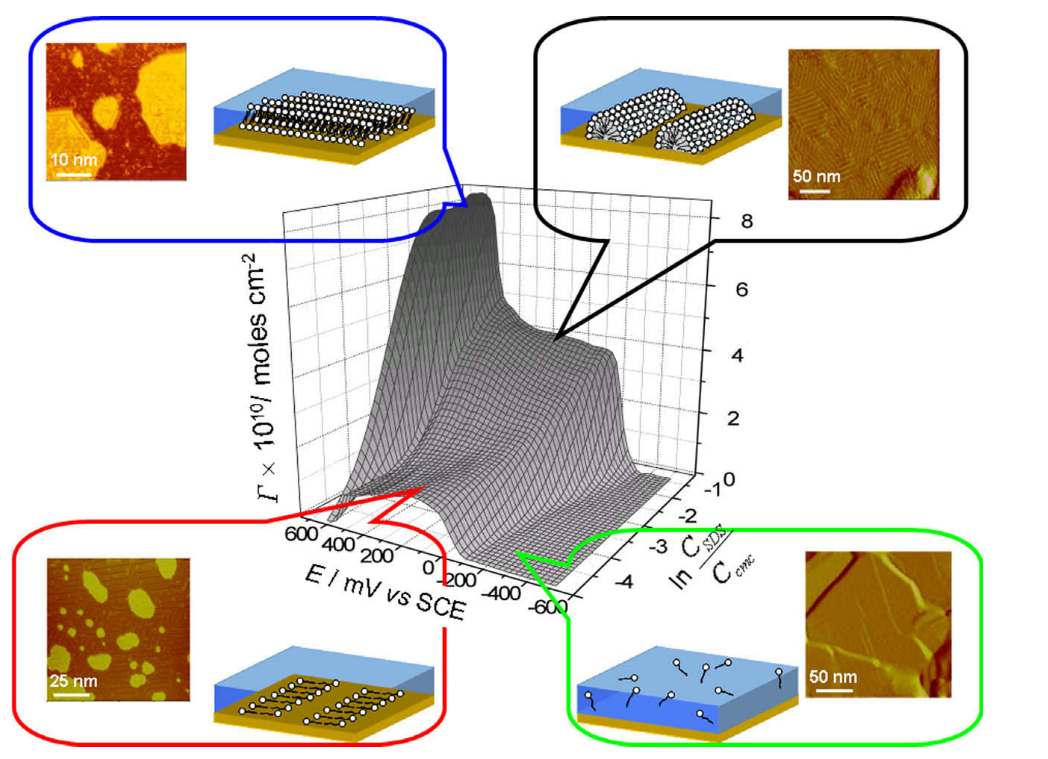

Fig. 11 SDS in 0.05 M KClO4 on Au(111)

In [62]:
exp_chen2009potential = {
    "surfactant":           ["SDS"],
    "solvent":              "H2O",
    "substrate":            ["AU"],
    "counterion":           ["NA"],
    "bg_electrolyte":       ["KClO4"],
    "techniques":           ["QCM","AFM"],
    "crytal_plane":         111 }
# TO BE FILLED OUT
#     "c_adsorption_onset":   0.003e-3, # M, 0.003 mM
#     "shape":                { 0.03e-3: "<, monolayer"}, # c, [c] = M
#     "adsorption_mass":      {  0.03e-3: 70 * 1e-12 * 100**2,
#                               10.0e-3: 203 * 1e-12 * 100**2}, # c -> m, [m] = kg m^-2 = 1e-8 ng cm^-2
#     "molecular_area":       { 0.03e-3: 85 * 1e-20}, # 85 Ang**2 per molecule 
#     "reference_key":        "kawasaki2007influence",
#     "comment":              "CTAB: 3 regions "
#                             "region 1: c < 0.003mM: adsorption due to headgroup-surface electrostatic forces, monolayer."
#                             "region 2: 0.003mM < c < 1 mM: bilayer bildup. "
#                             "region 3: 1mM < c."
#                             "AFM force curves: "
#                             "region 1: In water, the force curve is purely attractive below a separation of about 5 nm. "
#                             "At a low surfactant concentration of 0.01 mM (region I), the attractive interaction "
#                             "force increases and becomes more long range (<10 nm). This long-range attractive force can be attributed "
#                             "to the hydrophobic monolayer with the alkyl-hydrocarbon chains of surfactants facing the "
#                             "solution phase suggesting that region I is in the monolayer state. Further, as the "
#                             "surfactant concentration in- creases to 0.07 mM (region II), the long-range attractive "
#                             "force decreases. At 0.5 mM (region II), a weak repulsive force appears at a large "
#                             "separation of about 25 nm due to the buildup of the bilayer with a cationic headgroup "
#                             "facing the aqueous solutions. At the concentration of 3 mM above the cmc (region III), "
#                             "an exponential long-range repulsive force and a short-range repulsive force appear at large "
#                             "and small separations, respec- tively. The long-range repulsive force originates from the "
#                             "electrical double-layer repulsion between the bilayer-type ag- gregates on gold. "
#                             "The adsorption isotherm and force curves reveal that the progressive buildup of "
#                             "the bilayer-type aggregates ofC16TABr occurs on the gold surface. It should be noted "
#                             "that the morphologies ofbilayer-type aggregates (i.e., full-cylindrical aggregates or "
#                             "complete bilayer surface aggregates) ofC16TABr are not clear by only QCM and AFM "
#                             "force curves."}

In [63]:
c_CMC_SDS_in_50_mM_KClO4 = 0.54 * C.milli # M

In [64]:
exp_chen2009_fig4a_c_SDS = 0.6 * c_CMC_SDS_in_50_mM_KClO4

In [65]:
exp_chen2009_fig4a_c_SDS

0.000324

##### Figure 4 a

In [66]:
exp_chen2009_fig4a_data_raw = pd.read_csv(
    os.path.join(prefix,'ref','dat','chen2009potential_fig4a.csv'),
    delimiter=',',comment='#',header=None,names=["E","GammaC"])
# E      : electrode potential / V (vs. Ag/agCl)
# GammaC : surface excess / moles cm^-2

In [67]:
exp_chen2009_fig4a_data = pd.concat([    
    exp_chen2009_fig4a_data_raw[["E"]],
    exp_chen2009_fig4a_data_raw[["GammaC"]] / 1e10 / C.centi**2 #  moles cm^-2 --> moles m^-2
    ], axis=1)

In [68]:
exp_chen2009_fig4a_data.loc[exp_chen2009_fig4a_data["GammaC"] < 0.0, "GammaC"] = 0 

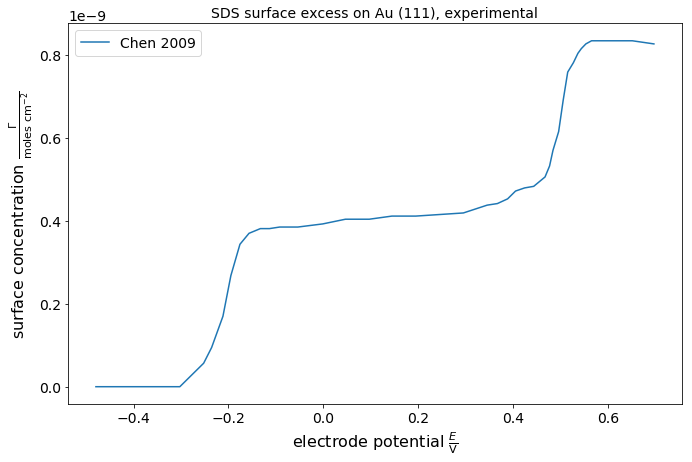

In [69]:
plt.plot(exp_chen2009_fig4a_data[["E"]],
             exp_chen2009_fig4a_data[["GammaC"]]*C.centi**2,
             label = "Chen 2009")
plt.xlabel(r'electrode potential $\frac{E}{\mathrm{V}}$')
plt.ylabel(r'surface concentration $\frac{\Gamma}{\mathrm{moles \ cm^{-2}}}$')
plt.title("SDS surface excess on Au (111), experimental")
plt.legend()

In [70]:
# surface number density, mol m^-2 * (mol^-1) = m^-2
exp_chen2009_fig4a_data[["GammaN"]] = exp_chen2009_fig4a_data[["GammaC"]] * C.Avogadro

In [71]:
# area per molecule, m^2
exp_chen2009_fig4a_data[["A"]] = 1 / exp_chen2009_fig4a_data[["GammaN"]]

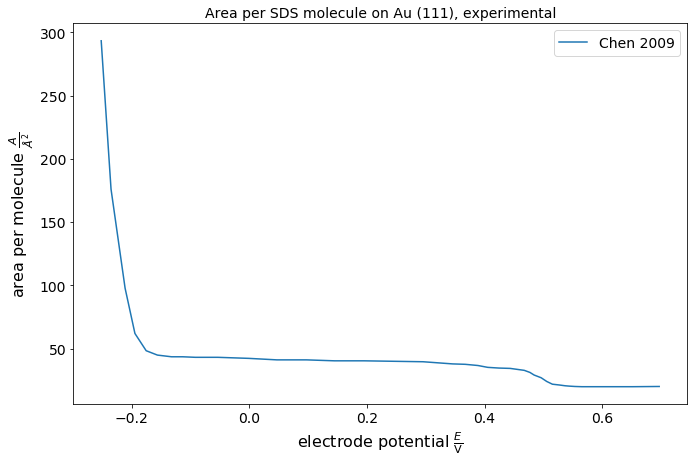

In [72]:
plt.plot(exp_chen2009_fig4a_data[["E"]],
             exp_chen2009_fig4a_data[["A"]] / C.angstrom**2,
             label = "Chen 2009")
plt.xlabel(r'electrode potential $\frac{E}{\mathrm{V}}$')
plt.ylabel(r'area per molecule $\frac{A}{\AA^2}$')
plt.title("Area per SDS molecule on Au (111), experimental")
plt.legend()

##### Figure 8 a

In [73]:
exp_chen2009_fig8a_data_raw = pd.read_csv(
    os.path.join(prefix,'ref','dat','chen2009potential_fig8a.csv'),
    delimiter=',',comment='#',header=None,names=["E","GammaC"])
# E      : electrode potential / mV (vs. SCE)
# GammaC : surface excess / moles cm^-2

In [74]:
exp_chen2009_fig8a_data = pd.concat([    
    exp_chen2009_fig8a_data_raw[["E"]]*C.milli, # mV -> V
    exp_chen2009_fig8a_data_raw[["GammaC"]] / 1e10 / C.centi**2 #  1e10 moles cm^-2 --> moles m^-2
    ], axis=1)

In [75]:
exp_chen2009_fig8a_data.loc[exp_chen2009_fig8a_data["GammaC"] < 0.0, "GammaC"]

Series([], Name: GammaC, dtype: float64)

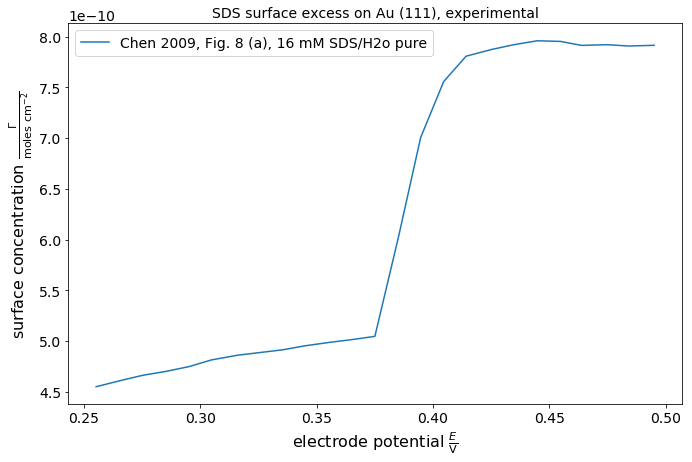

In [76]:
plt.plot(exp_chen2009_fig8a_data[["E"]],
             exp_chen2009_fig8a_data[["GammaC"]]*C.centi**2,
             label = "Chen 2009, Fig. 8 (a), 16 mM SDS/H2o pure")
plt.xlabel(r'electrode potential $\frac{E}{\mathrm{V}}$')
plt.ylabel(r'surface concentration $\frac{\Gamma}{\mathrm{moles \ cm^{-2}}}$')
plt.title("SDS surface excess on Au (111), experimental")
plt.legend()

In [77]:
# surface number density, mol m^-2 * (mol^-1) = m^-2
exp_chen2009_fig8a_data[["GammaN"]] = exp_chen2009_fig8a_data[["GammaC"]] * C.Avogadro

In [78]:
# area per molecule, m^2
exp_chen2009_fig8a_data[["A"]] = 1 / exp_chen2009_fig8a_data[["GammaN"]]

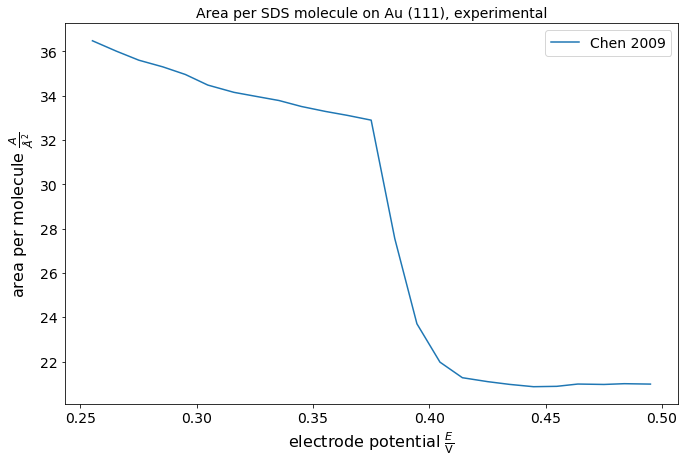

In [79]:
plt.plot(exp_chen2009_fig8a_data[["E"]],
             exp_chen2009_fig8a_data[["A"]] / C.angstrom**2,
             label = "Chen 2009")
plt.xlabel(r'electrode potential $\frac{E}{\mathrm{V}}$')
plt.ylabel(r'area per molecule $\frac{A}{\AA^2}$')
plt.title("Area per SDS molecule on Au (111), experimental")
plt.legend()

In [80]:
# Standard electrode potentials
E0_SCE = 0.2444 # V vs. SHE at 25 deg C
# saturated calomel electrode vs. standard hydrogen electrode 
# https://en.wikipedia.org/wiki/Saturated_calomel_electrode

E0_Ag_AgCl = 0.22249 # V vs. SHE at 25 deg C
# AgCl(s) + e- <=> Ag(s) + Cl- vs. standard hydrogfen electrode
# https://en.wikipedia.org/wiki/Silver_chloride_electrode

E_SCE_diff_Ag_AgCl = E0_SCE - E0_Ag_AgCl

In [81]:
E_SCE_diff_Ag_AgCl

0.021910000000000013

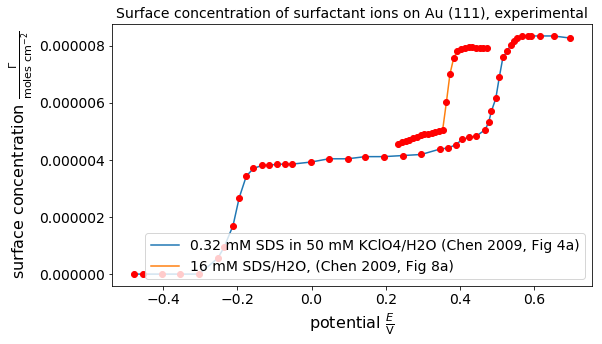

In [82]:
# ATTENTION: these plots not yet comparable!
rows = 1
cols = 2

fig = plt.figure(figsize=(8*cols, 5*rows))

pos = subplotPosition(cols=cols,rows=rows)

p = next(pos)
_, ax = addSubplot(exp_chen2009_fig4a_data[["E"]],
                   exp_chen2009_fig4a_data[["GammaC"]],
                   title = "Surface concentration of surfactant ions on Au (111), experimental", 
                   xlabel = r'potential $\frac{E}{\mathrm{V}}$', 
                   ylabel = r'surface concentration $\frac{\Gamma}{\mathrm{moles \ cm^{-2}}}$',
                   legend = "0.32 mM SDS in 50 mM KClO4/H2O (Chen 2009, Fig 4a)", fig = fig, pos = p)
_, _ = addSubplot( exp_chen2009_fig4a_data[["E"]],
                   exp_chen2009_fig4a_data[["GammaC"]],
                   fmtstr='ro', fig = fig, pos = p, ax = ax)

_, _ = addSubplot(exp_chen2009_fig8a_data[["E"]] - E_SCE_diff_Ag_AgCl,
                   exp_chen2009_fig8a_data[["GammaC"]],
                   legend = "16 mM SDS/H2O, (Chen 2009, Fig 8a)", 
                   fig = fig, pos = p, ax=ax)
_, _ = addSubplot( exp_chen2009_fig8a_data[["E"]] - E_SCE_diff_Ag_AgCl,
                   exp_chen2009_fig8a_data[["GammaC"]],
                   fmtstr='ro', fig = fig, pos = p, ax = ax)

# p = next(pos)
# _, ax = addSubplot(exp_sklt_unpublished_fig1_data[["c"]] / C.milli,
#                    exp_sklt_unpublished_fig1_data[["A"]] / C.angstrom**2,
#                    title = "Area per surfactant molecule on Au (111), experimental", 
#                    xlabel = r'bulk $\frac{c}{\mathrm{mM}}$', 
#                    ylabel = r'area per molecule $\frac{A}{\AA^2}$',
#                    legend = "DS-, Chen 2009", fig = fig, pos = p)
# _, _ = addSubplot( exp_sklt_unpublished_fig1_data[["c"]] / C.milli,
#                    exp_sklt_unpublished_fig1_data[["A"]] / C.angstrom**2,
#                    fmtstr='ro', fig = fig, pos = p, ax = ax)
# _, _ = addSubplot( exp_kawasaki2007influence_fig1b_data[["c"]] / C.milli,
#                    exp_kawasaki2007influence_fig1b_data[["A"]] / C.angstrom**2,
#                    legend = "CTA+, Kawasaki 2007", fig = fig, pos = p, ax = ax)
# _, _ = addSubplot(exp_kawasaki2007influence_fig1b_data[["c"]] / C.milli,
#                    exp_kawasaki2007influence_fig1b_data[["A"]] / C.angstrom**2,
#                    fmtstr='ro', fig = fig, pos = p, ax = ax)
# ax.set_xscale("log")
# ax.set_yscale("log")

fig.tight_layout()

#### SKLT 2017, unpublished

In [83]:
exp_sklt_unpublished_fig1_data_raw = pd.read_csv(
    os.path.join(prefix,'ref','dat','sklt_unpublished_fig1.csv'),
            delimiter=',',comment='#',header=None,names=["c","GammaM"])
# cE      : bulk concenctration / mM 
# GammaM : surface mass density / ng cm^-2

In [84]:
exp_sklt_unpublished_fig1_data = pd.concat([    
    exp_sklt_unpublished_fig1_data_raw[["c"]]*C.milli, # mM --> M
    exp_sklt_unpublished_fig1_data_raw[["GammaM"]] * (C.nano * C.gram) / C.centi**2 # ng cm^-2 --> kg m^-2
    ], axis=1)

In [85]:
# surface concentration, kg m^-2 * (mol/kg) = mol m^-2
exp_sklt_unpublished_fig1_data[["GammaC"]] = exp_sklt_unpublished_fig1_data[["GammaM"]] / M_DSm

In [86]:
# surface number density, mol m^-2 * (mol^-1) = m^-2
exp_sklt_unpublished_fig1_data[["GammaN"]] = exp_sklt_unpublished_fig1_data[["GammaC"]] * C.Avogadro

In [87]:
# area per molecule, m^2
exp_sklt_unpublished_fig1_data[["A"]] = 1 / exp_sklt_unpublished_fig1_data[["GammaN"]]

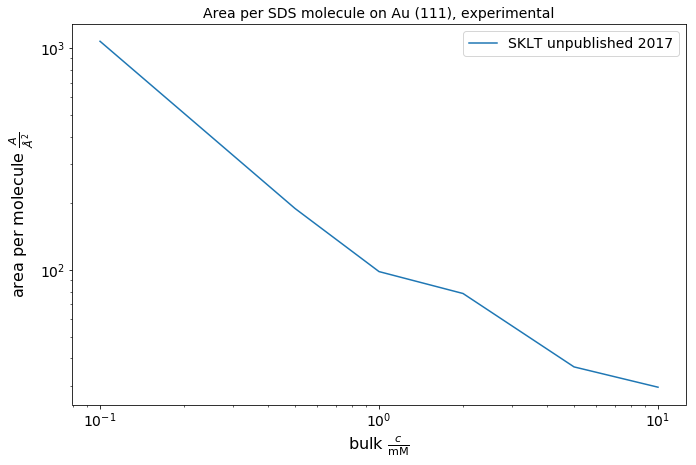

In [88]:
plt.loglog( exp_sklt_unpublished_fig1_data[["c"]] / C.milli,
             exp_sklt_unpublished_fig1_data[["A"]] / C.angstrom**2,
             label = "SKLT unpublished 2017")
plt.xlabel(r'bulk $\frac{c}{\mathrm{mM}}$')
plt.ylabel(r'area per molecule $\frac{A}{\AA^2}$')
plt.title("Area per SDS molecule on Au (111), experimental")
plt.legend()

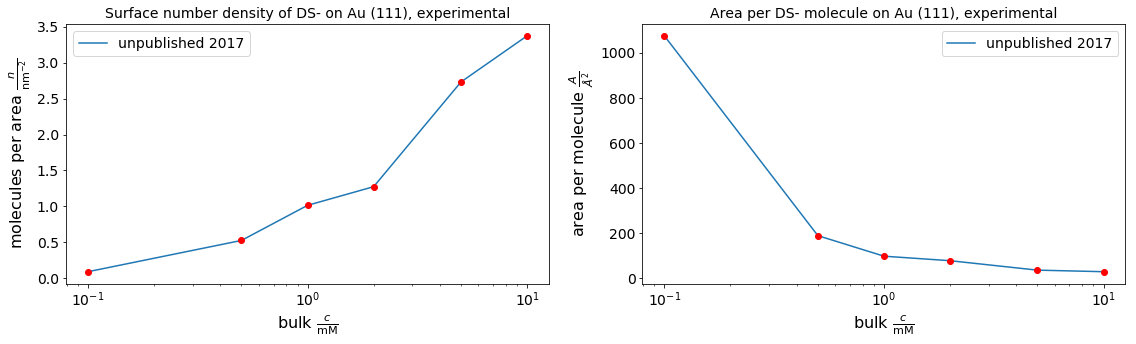

In [89]:
rows = 1
cols = 2

fig = plt.figure(figsize=(8*cols, 5*rows))

pos = subplotPosition(cols=cols,rows=rows)

p = next(pos)
_, ax = addSubplot(exp_sklt_unpublished_fig1_data[["c"]] / C.milli,
                   exp_sklt_unpublished_fig1_data[["GammaN"]] * C.nano**2,
                   title = "Surface number density of DS- on Au (111), experimental", 
                   xlabel = r'bulk $\frac{c}{\mathrm{mM}}$', 
                   ylabel = r'molecules per area $\frac{n}{\mathrm{nm}^{-2}}$',
                   legend = "unpublished 2017", fig = fig, pos = p)
_, _ = addSubplot( exp_sklt_unpublished_fig1_data[["c"]] / C.milli,
                   exp_sklt_unpublished_fig1_data[["GammaN"]] * C.nano**2,
                   fmtstr='ro', fig = fig, pos = p, ax = ax)
ax.set_xscale("log")

p = next(pos)
_, ax = addSubplot(exp_sklt_unpublished_fig1_data[["c"]] / C.milli,
                   exp_sklt_unpublished_fig1_data[["A"]] / C.angstrom**2,
                   title = "Area per DS- molecule on Au (111), experimental", 
                   xlabel = r'bulk $\frac{c}{\mathrm{mM}}$', 
                   ylabel = r'area per molecule $\frac{A}{\AA^2}$',
                   legend = "unpublished 2017", fig = fig, pos = p)
_, _ = addSubplot( exp_sklt_unpublished_fig1_data[["c"]] / C.milli,
                   exp_sklt_unpublished_fig1_data[["A"]] / C.angstrom**2,
                   fmtstr='ro', fig = fig, pos = p, ax = ax)
ax.set_xscale("log")

fig.tight_layout()

#### Kawasaki 2007

In [90]:
exp_kawasaki2007influence_fig1b_data_raw = pd.read_csv(
    os.path.join(prefix,'ref','dat','kawasaki2007influence_fig1b.csv'),
            delimiter=',',comment='#',header=1,names=["c","GammaM"])
# c      : bulk concentration / mM
# GammaM : adsorption mass / ng cm⁻2

In [91]:
exp_kawasaki2007influence_fig1b_data = pd.concat([    
    exp_kawasaki2007influence_fig1b_data_raw[["c"]] * C.milli, # mM --> M
    exp_kawasaki2007influence_fig1b_data_raw[["GammaM"]] * (C.nano * C.gram) / C.centi**2 # ng cm^-2 --> kg m^-2
    ], axis=1)

In [92]:
# surface concentration, kg m^-2 * (mol/kg) = mol m^-2
exp_kawasaki2007influence_fig1b_data[["GammaC"]] = exp_kawasaki2007influence_fig1b_data[["GammaM"]] / M_CTAp

In [93]:
# surface number density, mol m^-2 * (mol^-1) = m^-2
exp_kawasaki2007influence_fig1b_data[["GammaN"]] = exp_kawasaki2007influence_fig1b_data[["GammaC"]] * C.Avogadro

In [94]:
# area per molecule, m^2
exp_kawasaki2007influence_fig1b_data[["A"]] = 1 / exp_kawasaki2007influence_fig1b_data[["GammaN"]]

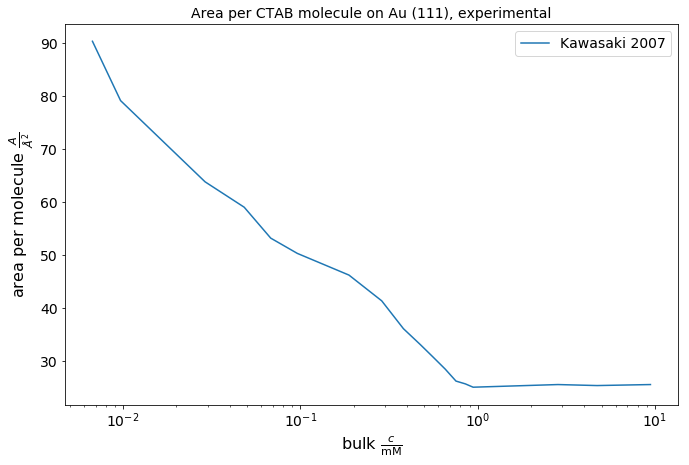

In [95]:
plt.semilogx(exp_kawasaki2007influence_fig1b_data[["c"]] / C.milli,
             exp_kawasaki2007influence_fig1b_data[["A"]] / C.angstrom**2,
             label = "Kawasaki 2007")
plt.xlabel(r'bulk $\frac{c}{\mathrm{mM}}$')
plt.ylabel(r'area per molecule $\frac{A}{\AA^2}$')
plt.title("Area per CTAB molecule on Au (111), experimental")
plt.legend()

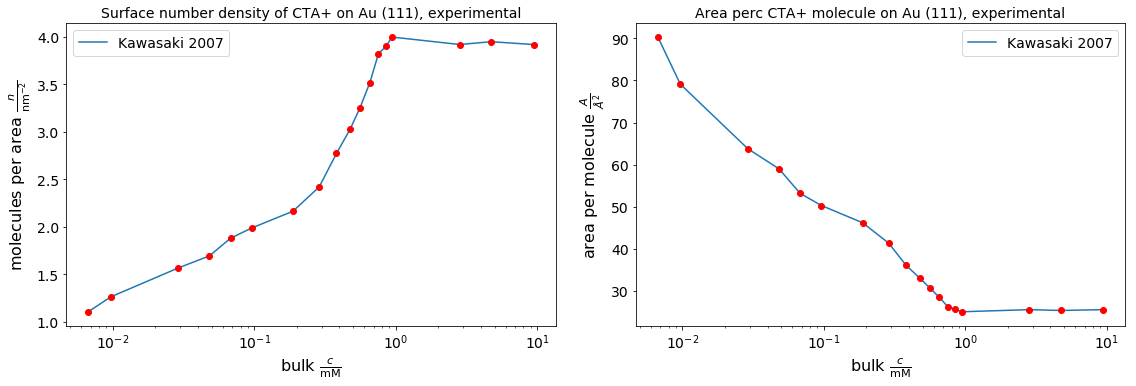

In [96]:
rows = 2
cols = 2

fig = plt.figure(figsize=(8*cols, 5*rows))

pos = subplotPosition(cols=cols,rows=rows)

p = next(pos)
_, ax = addSubplot(exp_kawasaki2007influence_fig1b_data[["c"]] / C.milli,
                   exp_kawasaki2007influence_fig1b_data[["GammaN"]] * C.nano**2,
                   title = "Surface number density of CTA+ on Au (111), experimental", 
                   xlabel = r'bulk $\frac{c}{\mathrm{mM}}$', 
                   ylabel = r'molecules per area $\frac{n}{\mathrm{nm}^{-2}}$',
                   legend = "Kawasaki 2007", fig = fig, pos = p)
_, _ = addSubplot(exp_kawasaki2007influence_fig1b_data[["c"]] / C.milli,
                   exp_kawasaki2007influence_fig1b_data[["GammaN"]] * C.nano**2,
                   fmtstr='ro', fig = fig, pos = p, ax = ax)
ax.set_xscale("log")

p = next(pos)
_, ax = addSubplot(exp_kawasaki2007influence_fig1b_data[["c"]] / C.milli,
                   exp_kawasaki2007influence_fig1b_data[["A"]] / C.angstrom**2,
                   title = "Area perc CTA+ molecule on Au (111), experimental", 
                   xlabel = r'bulk $\frac{c}{\mathrm{mM}}$', 
                   ylabel = r'area per molecule $\frac{A}{\AA^2}$',
                   legend = "Kawasaki 2007", fig = fig, pos = p)
_, _ = addSubplot(exp_kawasaki2007influence_fig1b_data[["c"]] / C.milli,
                   exp_kawasaki2007influence_fig1b_data[["A"]] /C.angstrom**2,
                   fmtstr='ro', fig = fig, pos = p, ax = ax)
ax.set_xscale("log")

fig.tight_layout()

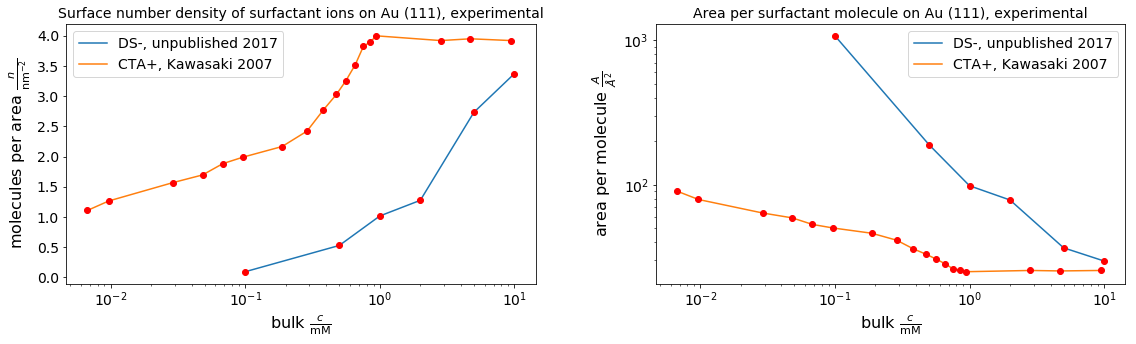

In [97]:
rows = 1
cols = 2

fig = plt.figure(figsize=(8*cols, 5*rows))

pos = subplotPosition(cols=cols,rows=rows)

p = next(pos)
_, ax = addSubplot(exp_sklt_unpublished_fig1_data[["c"]] / C.milli,
                   exp_sklt_unpublished_fig1_data[["GammaN"]] * C.nano**2,
                   title = "Surface number density of surfactant ions on Au (111), experimental", 
                   xlabel = r'bulk $\frac{c}{\mathrm{mM}}$', 
                   ylabel = r'molecules per area $\frac{n}{\mathrm{nm}^{-2}}$',
                   legend = "DS-, unpublished 2017", fig = fig, pos = p)
_, _ = addSubplot( exp_sklt_unpublished_fig1_data[["c"]] / C.milli,
                   exp_sklt_unpublished_fig1_data[["GammaN"]] * C.nano**2,
                   fmtstr='ro', fig = fig, pos = p, ax = ax)

_, _ = addSubplot( exp_kawasaki2007influence_fig1b_data[["c"]] / C.milli,
                   exp_kawasaki2007influence_fig1b_data[["GammaN"]] * C.nano**2,
                   legend = "CTA+, Kawasaki 2007", fig = fig, pos = p, ax = ax)
_, _ = addSubplot(exp_kawasaki2007influence_fig1b_data[["c"]] / C.milli,
                   exp_kawasaki2007influence_fig1b_data[["GammaN"]] * C.nano**2,
                   fmtstr='ro', fig = fig, pos = p, ax = ax)

ax.set_xscale("log")

p = next(pos)
_, ax = addSubplot(exp_sklt_unpublished_fig1_data[["c"]] / C.milli,
                   exp_sklt_unpublished_fig1_data[["A"]] / C.angstrom**2,
                   title = "Area per surfactant molecule on Au (111), experimental", 
                   xlabel = r'bulk $\frac{c}{\mathrm{mM}}$', 
                   ylabel = r'area per molecule $\frac{A}{\AA^2}$',
                   legend = "DS-, unpublished 2017", fig = fig, pos = p)
_, _ = addSubplot( exp_sklt_unpublished_fig1_data[["c"]] / C.milli,
                   exp_sklt_unpublished_fig1_data[["A"]] / C.angstrom**2,
                   fmtstr='ro', fig = fig, pos = p, ax = ax)
_, _ = addSubplot( exp_kawasaki2007influence_fig1b_data[["c"]] / C.milli,
                   exp_kawasaki2007influence_fig1b_data[["A"]] / C.angstrom**2,
                   legend = "CTA+, Kawasaki 2007", fig = fig, pos = p, ax = ax)
_, _ = addSubplot(exp_kawasaki2007influence_fig1b_data[["c"]] / C.milli,
                   exp_kawasaki2007influence_fig1b_data[["A"]] / C.angstrom**2,
                   fmtstr='ro', fig = fig, pos = p, ax = ax)
ax.set_xscale("log")
ax.set_yscale("log")

fig.tight_layout()

#### Ducker 1996

In [98]:
exp_dasilva2018molecular

surfactant                                                        CTAB
solvent                                                            H2O
cmc1st                                                         0.00092
cmc2nd                                                            0.27
T_Krafft                                                           298
reference_key                                     dasilva2018molecular
reference_comment    1st cmd:  Goyal, P. S.; Dasannacharya, B. A.; ...
dtype: object

In [99]:
columns_experimental

['surfactant',
 'solvent',
 'cmc1st',
 'cmc2nd',
 'T_Krafft',
 'reference_key',
 'reference_comment']

In [100]:
experimental_template.index

Index(['surfactant', 'solvent', 'cmc1st', 'cmc2nd', 'T_Krafft',
       'reference_key', 'reference_comment'],
      dtype='object')

In [101]:
exp_df = pd.DataFrame(columns=experimental_template.index)

In [102]:
exp_df = exp_df.append(exp_dasilva2018molecular,ignore_index=True)

In [103]:
exp_df

,surfactant,solvent,cmc1st,cmc2nd,T_Krafft,reference_key,reference_comment
0,CTAB,H2O,0.00092,0.27,298,dasilva2018molecular,"1st cmd: Goyal, P. S.; Dasannacharya, B. A.; ..."


In [104]:
exp_ducker1996effect = {
    "surfactant":           "CTAB",
    "solvent":              "H2O",
    "c_sphere2rod":         0.14, # M, transition from spherical to rodlike micelles
    "c_cylindrical":        {"mica": 0.0035}, # M, formation of cylindrical aggregates on substrate
    "reference_key":        "ducker1996effect",
    "reference_comment":    "Ducker, W. A., & Grant, L. M. (1996). "
                            "Effect of substrate hydrophobicity on surfactant surface-aggregate geometry. "
                            "The Journal of Physical Chemistry, 100(28), 11507–11511."
                            ""
                            "  For example, hexadecyltrimethylammonium bro-mide (CTAB) "
                            "  in bulk undergoes a transition from spherical to "
                            "  cylindrical micelles at 0.14 M. "
                            "  Reiss-Husson, F.; Luzzati, V. J. Phys. Chem. 1964, 68, 3504-3511."
                            ""
                            "  a single-chain quaternary ammonium surfactant will formcylindrical "
                            "  aggregates onmica8 at only twice the cmc, 0.0035 M. "
                            "  Sepulveda, L.; Cortes, J. J. Phys. Chem. 1985, 89, 5322-5324."
}

In [105]:
exp_reiss1964structure_sds = { # small angle x-ray scattering
    "surfactant":           "SDS",
    "solvent":              "H2O",
    "cmc1st":               { (298 + 25): cMolar(2e-3, M_SDS), # T: c, [T] = K, [c] = M
                              (298 + 70): cMolar(3e-3, M_SDS)},
    "c_sphere2rod":         { (298 + 27): cMolar(0.25, M_SDS), # T: c, [T] = K, [c] = M
                              (298 + 70): cMolar(0.15, M_SDS)},
    "R_par":                { (298 + 25): 1.78,   # "paraffinic" kernel
                              (298 + 70): 1.70 }, # rad. of gyration, [R_par] = nm, used R_par from Tab 4
    "R_pol":                { (298 + 25): 2.4,
                              (298 + 70): 2.3 },  # 
    "n_agg":                { (298 + 25): 67,     # aggregation number
                              (298 + 70): 57 },   
    "reference_key":        "reiss1964structure",
}

In [106]:
exp_reiss1964structure_sds

{'surfactant': 'SDS',
 'solvent': 'H2O',
 'cmc1st': {323: 0.006914679649896662, 368: 0.010372019474844991},
 'c_sphere2rod': {325: 0.8643349562370826, 368: 0.5186009737422496},
 'R_par': {323: 1.78, 368: 1.7},
 'R_pol': {323: 2.4, 368: 2.3},
 'n_agg': {323: 67, 368: 57},
 'reference_key': 'reiss1964structure'}

In [107]:
exp_reiss1964structure_ctab = {
    "surfactant":           "CTAB",
    "solvent":              "H2O",
    "reference_key":        "reiss1964structure",
    "c_sphere2rod":         { (298 + 27): cMolar(0.05, M_CTAB), # T: c, [T] = K, [c] = M
                              (298 + 50): cMolar(0.17, M_CTAB),
                              (298 + 70): cMolar(0.27, M_CTAB)}
}

In [108]:
exp_reiss1964structure_ctab

{'surfactant': 'CTAB',
 'solvent': 'H2O',
 'reference_key': 'reiss1964structure',
 'c_sphere2rod': {325: 0.1367814515022637,
  348: 0.4650569351076965,
  368: 0.738619838112224}}

### Surfacatant models

In [109]:
ref_df = pd.DataFrame(columns=columns_reference_df)

In [110]:
sys_df = pd.DataFrame()

In [111]:
ref_df

,unique_key,category,surfactant,ff,ff_comment,pbc,production_time,ensemble,solvent,solvent_model,reference_key,reference_comment


In [112]:
# Shelley et al. 

In [113]:
# MacKerell Jr 1995
mackerelljr1995molecular = {
    "unique_key":           "mackerelljr1995molecular",
    "category":             "micelle", # micelle, adsorption, single ...
    "surfactant":           "SDS",
    "ff":                   "CHARMM",
    "pbc":                  True,
    "production_time":      120e-12, # in seconds
    "ensemble":             "NPT",
    "solvent":              "water",
    "solvent_model":        "TIP3P",
    "reference_key":        "mackerelljr1995molecular",
    "reference_comment":    "MacKerell Jr, A. D. (1995). Molecular dynamics simulation analysis of a sodium dodecyl sulfate micelle in aqueous solution: decreased fluidity of the micelle hydrocarbon interior. The Journal of Physical Chemistry, 99(7), 1846–1855. https://doi.org/10.1021/j100007a011",
    "year":                 1995
}

In [114]:
ingram2013prediction_sds = {
    "unique_key":           "ingram2013prediction_sds",
    "category":             "micelle", # micelle, adsorption, single ...
    "surfactant":           "SDS",
    "ff":                   "CHARMM36",
    "pbc":                  True,
    "ensemble":             "NVT, NPT",
    "solvent":              "water",
    "solvent_model":        "CHARMM-TIP3P",
    "reference_key":        "ingram2013prediction",
    "reference_comment":    "Ingram, T., Storm, S., Kloss, L., Mehling, T., Jakobtorweihen, S., & Smirnova, I. (2013). Prediction of micelle/water and liposome/water partition coefficients based on molecular dynamics simulations, COSMO-RS, and COSMOmic. Langmuir, 29(11), 3527–3537. https://doi.org/10.1021/la305035b",
    "year":                 2013, 
    
    # parameters
    "package":              "GROMACS 4.5.3",
    "dt":                   2e-15, # time step
    "production_time":      400e-9, # in seconds
    
    "thermostat":           "nose-hoover",
    "thermostat_tau_t":     1e-12, # in seconds
    "temperature":          298, # K
    "barostat":             "parrinello-rahman",
    "barostat_tau_p":       1e-12, # in seconds for micelles, BUT for bilayer tau_p = 5e-12 s
    "pressure":             1, # bar, = 1e5 Pa = 1e3 hPa
    "c_surfactant":         1, # M = 1000 mol / m^3
    "n_surfactant":         216,
    "n_ion":                216,
    "n_solvent":            8535,
    
    "energey_minimization": True,
    "nvt_equilibration":    600e-12, # seconds
    "npt_equilibration":    None,
    
    # constraints
    "constraints":          "h-bonds", # all hydrogen bonds
    "constraint_algorithm": "LINCS",
    
    # CHARMM-specific
    "inner_lj_cutoff":      0.8e-9,
    "outer_lj_cutoff":      1.2e-9,
    "coulomb_cutoff":       1.0e-9,
    "long_range_method":    "PME", # particle mesh Ewald
    
    # SDS-specific:
    "sds_model":            "CHARMM36-native"
}

In [115]:
ingram2013prediction_ctab = {
    "unique_key":           "ingram2013prediction_ctab",
    "category":             "micelle", # micelle, adsorption, single ...
    "surfactant":           "CTAB",
    "ff":                   "CHARMM36",
    "pbc":                  True,
    "ensemble":             "NVT, NPT",
    "solvent":              "water",
    "solvent_model":        "CHARMM-TIP3P",
    "reference_key":        "ingram2013prediction",
    "reference_comment":    "Ingram, T., Storm, S., Kloss, L., Mehling, T., Jakobtorweihen, S., & Smirnova, I. (2013). Prediction of micelle/water and liposome/water partition coefficients based on molecular dynamics simulations, COSMO-RS, and COSMOmic. Langmuir, 29(11), 3527–3537. https://doi.org/10.1021/la305035b",
    "year":                 2013,
    
    # parameters
    "package":              "GROMACS 4.5.3",
    "dt":                   2e-15, # time step
    "production_time":      400e-9, # in seconds
    "thermostat":           "nose-hoover",
    "thermostat_tau_t":     1e-12, # in seconds
    "temperature":          298, # K
    "barostat":             "parrinello-rahman",
    "barostat_tau_p":       1e-12, # in seconds for micelles, BUT for bilayer tau_p = 5e-12 s
    "pressure":             1, # bar, = 1e5 Pa = 1e3 hPa
    
    "c_surfactant":         0.73, # M = 1000 mol / m^3
    "n_surfactant":         216,
    "n_ion":                216,
    "n_solvent":            12000,
    
    "energey_minimization": True,
    "nvt_equilibration":    600e-12, # seconds
    "npt_equilibration":    None,
    "production_ensemble":  "NPT",
    "production_time":      100e-9,
    
    # CHARMM-specific
    "inner_lj_cutoff":      0.8e-9,
    "outer_lj_cutoff":      1.2e-9,
    "coulomb_cutoff":       1.0e-9,
    "long_range_method":    "PME", # particle mesh Ewald
    # CTAB-specific:    
}

In [116]:
ingram2013prediction_ctab2 = ingram2013prediction_ctab.copy()
ingram2013prediction_ctab2["unique_key"]   = "ingram2013prediction_ctab2"
ingram2013prediction_ctab2["c_surfactant"] = 0.1 # M
ingram2013prediction_ctab2["n_solvent"]    = 120000

In [117]:
# same group, samye year, very related
# reports experimental cmc:
# SDS 8e-3 M to 9e-3 M
storm2013molecular_sds = ingram2013prediction_sds.copy()
storm2013molecular_sds["unique_key"]    = "storm2013molecular_sds"
storm2013molecular_sds["reference_key"] = "storm2013molecular"
storm2013molecular_sds["reference_comment"] = "Storm, S., Jakobtorweihen, S., Smirnova, I., & Panagiotopoulos, A. Z. (2013). Molecular dynamics simulation of SDS and CTAB micellization and prediction of partition equilibria with COSMOmic. Langmuir, 29(37), 11582–11592. https://doi.org/10.1021/la402415b"

storm2013molecular_sds["c_surfactant"]    = 1 # M = mol / L
storm2013molecular_sds["n_solvent"]       = 8535
storm2013molecular_sds["production_time"] = 100e-9 # s
storm2013molecular_sds["barostat_tau_p"]  = 2e-12 # s


In [118]:
storm2013molecular_sds2 = storm2013molecular_sds.copy()
storm2013molecular_sds["unique_key"]    = "storm2013molecular_sds2"
storm2013molecular_sds2["n_solvent"]    = 25605
storm2013molecular_sds2["c_surfactant"] = 0.041 # M

In [119]:
# reports experimental cmc:
# CTAB 9e-4 M to 10e-4 M
storm2013molecular_ctab = storm2013molecular_sds.copy()
storm2013molecular_ctab["unique_key"]    = "storm2013molecular_ctab"
storm2013molecular_ctab["surfactant"]   = "CTAB"
storm2013molecular_ctab["n_solvent"]    = 12000
storm2013molecular_ctab["c_surfactant"] = 0.73 # M
storm2013molecular_ctab["ctab_model"]   = "CHARMM36 DSPE/LPPC hybrid"
storm2013molecular_ctab["bromide_model"]= "Horinek" 
  # Horinek, D.; Mamatkulov, S. I.; Netz, R. R. Rational design of
  # ion force fields based on thermodynamic solvation properties. 
  # J. Chem. Phys. 2009, 130, 124507

In [120]:
storm2013molecular_ctab2 = storm2013molecular_ctab.copy()
storm2013molecular_ctab["unique_key"]    = "storm2013molecular_ctab2"
storm2013molecular_ctab2["n_solvent"]    = 120000
storm2013molecular_ctab2["c_surfactant"] = 0.1 # M

#### DaSilva 2018
Closely relatet to Meena & Sulpizi

> As expected, the
counterions (bromide) are located near the external positively charged border of the CTA+
aggregates; however,
it is important to mention that many assembly properties, such as the morphology, size, charge, and intra-micellar interactions, depend on the nature of the counterion.27,28 This is particularly evident if one compares the structural properties of CTAB and CTAC, [CH3
(CH2 )15 N+ (CH3 )3 ]Cl− .
They differ in many aspects of the micellar behavior; for example, CTAC shows no spherical-cylindrical transition in its micelles, even at high concentrations of CTAC.29

In [121]:
# article
dasilva2018molecular = {
    "unique_key":           "dasilva2018molecular",
    "category":             ["micelle","adsorption"], # micelle, adsorption, single ...
    "surfactant":           ["CTAC","CTAB"],
    "ff":                   "GROMOS54A7",
    "pbc":                  True,
    "ensemble":             "NPT",
    "solvent":              "water",
    "solvent_model":        "SPC",
    "reference_key":        "dasilva2018molecular",
    "reference_comment":    "J. A. Da Silva, R. P. Dias, G. C. A. Da Hora, T. A. Soares, and M. R. Meneghetti, “Molecular dynamics simulations of cetyltrimethylammonium bromide (CTAB) micelles and their interactions with a gold surface in aqueous solution,” J. Braz. Chem. Soc., vol. 29, no. 1, pp. 191–199, 2018.",
    "year":                 2018,
    
    # parameters
    "package":              "GROMACS 4.5.3",
    "dt":                   2e-15, # time step, in seconds
    "thermostat":           "Berendsen",
    "thermostat_tau_t":     0.4e-12, # in seconds
    "temperature":          300, # K
    "barostat":             "parrinello-rahman",
    "barostat_tau_p":       0.4e-12, # in second
    "pressure":             1, # bar, = 1e5 Pa = 1e3 hPa
    
    "permittivity":         66., # coarse-graining needs permittivity > 1?
    
    "parameter_comments":   "The center-of-mass motion was removed every 5 steps."\
                            "Anisotropic coordinate scaling was used with a relaxation "\
                            "time of 0.4 ps and a compressibility of 4.5 × 10^−5 bar^−1",
    
    "energey_minimization": 5000, # steps
    #"nvt_equilibration":    600e-12, # seconds
    #"npt_equilibration":    None,
    "production_ensemble":  "NPT",
    "production_time":      200e-9, # in seconds
    
    # CHARMM-specific
    #"inner_lj_cutoff":      0.8e-9,
    #"outer_lj_cutoff":      1.2e-9,
    "lj_cutoff":            1.4e-9, # m
    "coulomb_cutoff":       1.4e-9, # m
    #"long_range_method":    "PME", # particle mesh Ewald
    
    # material-specific:   
    "ctab_model":           "adapted from the dipalmitoylphosphatidylcholine lipid in the" \
                            "GROMOS parameter set gromos54a7. (DPPC, jlh)",
    "chloride_model":       "chloride Lennard-Jones atomic parameter (LJAP) "\
                            "was taken from the GROMOS parameter set gromos54a7. ",
    "bromide_model":        "by Hasse and co-workers, Netz and co-workers, and Reiser et al. "\
                            "Deublein, S.; Vrabec, J.; Hasse, H.; J. Chem. Phys. 2012, 136, 501. "\
                            "Mamatkulov, S.; Fyta, M.; Netz, R. R.; J. Chem. Phys. 2013, 138, 505. "\
                            "Reiser, S.; Deublein, S.; Vrabec, J.; Hasse, H.; J. Chem. Phys. 2014, 140, 504.",
    "gold_model":           "by Heinz et al. " \
                            "Heinz, H.; Vaia, R. A.; Farmer, B. L.; Naik, R. R.; J. Phys. Chem. C 2008, 112, 17281."
    
}

In [122]:
# systems derived from article
dasilva2018molecular_ctac = {
    # parameters
    "unique_key":           "dasilva2018molecular_ctac",
    "category":             "micelle", # micelle, adsorption, single ...
    "surfactant":           "CTAC",
    "solvent":              "water",
    "counterion":           "CL",
    "reference_key":        "dasilva2018molecular",
    
    #"c_surfactant":        ?, # M = 1000 mol / m^3
    "n_surfactant":         90,
    "n_ion":                90,
    "n_solvent":            4980,

    "initial_config":       "bilayer"}

In [123]:
# systems derived from article
dasilva2018molecular_ctab = {
    # parameters
    "unique_key":           "dasilva2018molecular_ctab",
    "category":             "micelle", # micelle, adsorption, single ...
    "surfactant":           "CTAB",
    "solvent":              "water",
    "counterion":           "BR",
    "reference_key":        "dasilva2018molecular",
    
    #"c_surfactant":        ?, # M = 1000 mol / m^3
    "n_surfactant":         90,
    "n_ion":                90,
    "n_solvent":            4980,

    "initial_config":       "bilayer"}

In [124]:
dasilva2018molecular_ctab_on_au = {
    # parameters
    "unique_key":           "dasilva2018molecular_ctab_on_au",
    "category":             "adsorbtion", # micelle, adsorption, single ...
    "surfactant":           "CTAB",
    "counterion":           "BR",
    "substrate":            "AU100",
    "reference_key":        "dasilva2018molecular",
    
    #"c_surfactant":         0.73, # M = 1000 mol / m^3
    "n_surfactant":         180,
    "n_ion":                180,
    "n_solvent":            4766,
    "n_substrate":          1600,
        
    "initial_config":       "2 bilayer"}

#### Build reference data frame

In [125]:
ref_df = ref_df.append(mackerelljr1995molecular,ignore_index=True)

# move into sys df
ref_df = ref_df.append(ingram2013prediction_sds,ignore_index=True)
ref_df = ref_df.append(ingram2013prediction_ctab,ignore_index=True)
ref_df = ref_df.append(ingram2013prediction_ctab2,ignore_index=True)

# move into sys df
ref_df = ref_df.append(storm2013molecular_sds,ignore_index=True)
ref_df = ref_df.append(storm2013molecular_sds2,ignore_index=True)
ref_df = ref_df.append(storm2013molecular_ctab,ignore_index=True)
ref_df = ref_df.append(storm2013molecular_ctab2,ignore_index=True)

ref_df = ref_df.append(dasilva2018molecular,ignore_index=True)

ref_df.set_index(keys="unique_key",inplace=True)

In [126]:
ref_df.loc["dasilva2018molecular"]

category                                            [micelle, adsorption]
surfactant                                                   [CTAC, CTAB]
ff                                                             GROMOS54A7
ff_comment                                                            NaN
pbc                                                                  True
production_time                                                     2e-07
ensemble                                                              NPT
solvent                                                             water
solvent_model                                                         SPC
reference_key                                        dasilva2018molecular
reference_comment       J. A. Da Silva, R. P. Dias, G. C. A. Da Hora, ...
year                                                                 2018
barostat                                                parrinello-rahman
barostat_tau_p                        

#### Build system data frame

In [127]:
sys_df = sys_df.append(dasilva2018molecular_ctac, ignore_index=True)

sys_df = sys_df.append(dasilva2018molecular_ctab, ignore_index=True)

sys_df = sys_df.append(dasilva2018molecular_ctab_on_au, ignore_index=True)

sys_df.set_index(keys="unique_key",inplace=True)

In [128]:
sys_df

,category,counterion,initial_config,n_ion,n_solvent,n_surfactant,reference_key,solvent,surfactant,n_substrate,substrate
unique_key,,,,,,,,,,,
dasilva2018molecular_ctac,micelle,CL,bilayer,90.0,4980.0,90.0,dasilva2018molecular,water,CTAC,NaN,NaN
dasilva2018molecular_ctab,micelle,BR,bilayer,90.0,4980.0,90.0,dasilva2018molecular,water,CTAB,NaN,NaN
dasilva2018molecular_ctab_on_au,adsorbtion,BR,2 bilayer,180.0,4766.0,180.0,dasilva2018molecular,NaN,CTAB,1600.0,AU100


## Derivation of computational system setups, 2018

### Considerations on system setup

#### Jour Fixe Discussion 1 Aug 2018

* solute
  * ~~prearrange ions close to CTAB polar head~~
* substrate
  * ~~pbc must coincide with crystal lattice constant~~
  * ~~slab at tangential boundary~~
  * ~~lookup "slab correction"~~
  * use EAM potential instead of LJ
  * small system with thicker layer for comparison
  * ~~fix COM~~
* indenter 
  * preferably filled indenter, tempered
  * ~~alternatively hollow indenter, fixed~~
  * use SiO2 model (INTEFACE FF) 
  * ~~use AU 111, scale~~
  * run indenter in water only
* thermo- & barostat
  * equilibration
    * ~~temp: Langevin; press: Bernedsen (stable) ~~
      ~~temp: Langevin, press: Berendsen aniso~~
      **dilate keyword?**
  * production: 
    * ~~press: NPH (Anderson, Parinello-Rahman)~~
    * ~~temp: Langevin on substrate only, NVE on solution~~
  * ~~temper substrate~~
  * ~~barostat anisotropic (aniso keyword)~~
  


### select subsrate slabs, from Jaschke 1997

In [129]:
# Jaschke, M., Butt, H.-J., Gaub, H.E., Manne, S., 1997. 
# Surfactant Aggregates at a Metal Surface. Langmuir 13, 1381–1384.
# distance between stripelike aggregates
d_C14TAB  = 6.0 * C.nano # +- 0.5 nm 
d_C16TAOH = 6.1 * C.nano # +- 0.5 nm
d_SDS     = 4.9 * C.nano # +- 0.5 nm 

In [130]:
# INTERFACE Au (111) unit cell
unit_cell_AU_111 =  np.array([2.8837, 4.9948, 7.0637]) * C.angstrom

In [131]:
unit_cell_AU_111 # surface normal in z direction

array([2.8837e-10, 4.9948e-10, 7.0637e-10])

In [132]:
np.round(d_C14TAB / unit_cell_AU_111)

array([21., 12.,  8.])

In [133]:
np.round(d_C16TAOH / unit_cell_AU_111)

array([21., 12.,  9.])

In [134]:
np.round(d_SDS / unit_cell_AU_111)

array([17., 10.,  7.])

In [135]:
# approximately matches the distance between two stripes for CTAB on AU 111
multiples_AU_111_to_fit_1_CTAB_aggregate   = np.array([21,12,0])
 # approximately matches 1.5 distances between two stripes of CTAB on AU 111
multiples_AU_111_to_fit_1_5_CTAB_aggregate = np.array([30,18,0])
# approximately matches the distance between two stripes of SDS on AU 111
multiples_AU_111_to_fit_1_SDS_aggregate    = np.array([17,10,0])
# approximately matches 1.5 distances between two stripes of SDS on AU 111
multiples_AU_111_to_fit_1_5_SDS_aggregate  = np.array([26,15,0])

In [136]:
AU_111_thickness_in_multiples = np.array([0,0,2])

In [137]:
sb_area_multiples_CTAB = [ multiples_AU_111_to_fit_1_CTAB_aggregate,
                 multiples_AU_111_to_fit_1_5_CTAB_aggregate,
                 #multiples_AU_111_to_fit_1_SDS_aggregate,
                 #multiples_AU_111_to_fit_1_5_SDS_aggregate, 
                 3*multiples_AU_111_to_fit_1_CTAB_aggregate, 
                 2*multiples_AU_111_to_fit_1_CTAB_aggregate +
                    multiples_AU_111_to_fit_1_5_CTAB_aggregate,
                 #3*multiples_AU_111_to_fit_1_SDS_aggregate, 
                 #2*multiples_AU_111_to_fit_1_SDS_aggregate +
                 #   multiples_AU_111_to_fit_1_5_SDS_aggregate 
                    ]

In [138]:
sb_area_multiples_SDS = [ 
                 multiples_AU_111_to_fit_1_SDS_aggregate,
                 multiples_AU_111_to_fit_1_5_SDS_aggregate, 
                 3*multiples_AU_111_to_fit_1_SDS_aggregate, 
                 2*multiples_AU_111_to_fit_1_SDS_aggregate +
                    multiples_AU_111_to_fit_1_5_SDS_aggregate 
                    ]

In [139]:
sb_area_multiples_SDS

[array([17, 10,  0]),
 array([26, 15,  0]),
 array([51, 30,  0]),
 array([60, 35,  0])]

In [140]:
sb_area_multiples_CTAB

[array([21, 12,  0]),
 array([30, 18,  0]),
 array([63, 36,  0]),
 array([72, 42,  0])]

In [141]:
sb_multiples_SDS = sb_area_multiples_SDS + AU_111_thickness_in_multiples

In [142]:
sb_multiples_CTAB = sb_area_multiples_CTAB + AU_111_thickness_in_multiples

In [143]:
sb_multiples_SDS

array([[17, 10,  2],
       [26, 15,  2],
       [51, 30,  2],
       [60, 35,  2]])

In [144]:
sb_multiples_CTAB

array([[21, 12,  2],
       [30, 18,  2],
       [63, 36,  2],
       [72, 42,  2]])

In [145]:
sb_area_measures_SDS = sb_area_multiples_SDS * unit_cell_AU_111

In [146]:
sb_area_measures_CTAB = sb_area_multiples_CTAB * unit_cell_AU_111

In [147]:
sb_area_measures_rounded_SDS = np.round(sb_area_measures_SDS / C.angstrom) * C.angstrom

In [148]:
sb_area_measures_rounded_CTAB = np.round(sb_area_measures_CTAB / C.angstrom) * C.angstrom

In [149]:
sb_area_measures_CTAB / C.angstrom  # surface area dimensions in Angstrom

array([[ 60.5577,  59.9376,   0.    ],
       [ 86.511 ,  89.9064,   0.    ],
       [181.6731, 179.8128,   0.    ],
       [207.6264, 209.7816,   0.    ]])

In [150]:
sb_area_measures_rounded_SDS / C.angstrom  # surface area dimensions in Angstrom

array([[ 49.,  50.,   0.],
       [ 75.,  75.,   0.],
       [147., 150.,   0.],
       [173., 175.,   0.]])

In [151]:
sb_area_measures_rounded_CTAB / C.angstrom  # surface area dimensions in Angstrom

array([[ 61.,  60.,   0.],
       [ 87.,  90.,   0.],
       [182., 180.,   0.],
       [208., 210.,   0.]])

In [152]:
desired_box_height = 3*d_C14TAB # fit more than 2 whole aggregates

In [153]:
desired_box_height

1.8000000000000002e-08

In [154]:
# NO ROUNDING: Measures must be exact (in crystal lattice direction)
# box_measures = np.zeros(sb_area_measures_rounded.shape)
# box_measures[:,0] = sb_area_measures_rounded.max(axis=1) # surfaces are approximately square
# box_measures[:,1] = sb_area_measures_rounded.max(axis=1) # surfaces are approximately square
# box_measures[:,2] = desired_box_height
box_measures_SDS = np.zeros(sb_area_measures_SDS.shape)
box_measures_SDS[:,0] = sb_area_measures_SDS[:,0]
box_measures_SDS[:,1] = sb_area_measures_SDS[:,1]
box_measures_SDS[:,2] = desired_box_height

In [155]:
# NO ROUNDING: Measures must be exact (in crystal lattice direction)
# box_measures = np.zeros(sb_area_measures_rounded.shape)
# box_measures[:,0] = sb_area_measures_rounded.max(axis=1) # surfaces are approximately square
# box_measures[:,1] = sb_area_measures_rounded.max(axis=1) # surfaces are approximately square
# box_measures[:,2] = desired_box_height
box_measures_CTAB = np.zeros(sb_area_measures_CTAB.shape)
box_measures_CTAB[:,0] = sb_area_measures_CTAB[:,0]
box_measures_CTAB[:,1] = sb_area_measures_CTAB[:,1]
box_measures_CTAB[:,2] = desired_box_height

In [156]:
box_measures_SDS / C.angstrom # boxes in Angstrom

array([[ 49.0229,  49.948 , 180.    ],
       [ 74.9762,  74.922 , 180.    ],
       [147.0687, 149.844 , 180.    ],
       [173.022 , 174.818 , 180.    ]])

In [157]:
box_measures_CTAB / C.angstrom # boxes in Angstrom

array([[ 60.5577,  59.9376, 180.    ],
       [ 86.511 ,  89.9064, 180.    ],
       [181.6731, 179.8128, 180.    ],
       [207.6264, 209.7816, 180.    ]])

### selection of more substrate slabs, 2019


#### SDS

In [158]:
np.array([1,2,3])*[1,2,3]

array([1, 4, 9])

In [159]:
alternative_unit_cell_AU_111 = unit_cell_AU_111 / [1,2,3]

In [160]:
alternative_unit_cell_AU_111

array([2.88370000e-10, 2.49740000e-10, 2.35456667e-10])

In [161]:
sb_area_multiples_SDS

[array([17, 10,  0]),
 array([26, 15,  0]),
 array([51, 30,  0]),
 array([60, 35,  0])]

In [162]:
sb_reference_area_multiples_SDS = sb_area_multiples_SDS[2]

In [163]:
sb_reference_area_multiples_SDS

array([51, 30,  0])

In [164]:
sb_area_measures_SDS[2]/C.angstrom

array([147.0687, 149.844 ,   0.    ])

In [165]:
150.0 / unit_cell_AU_111*C.angstrom

array([52.01650657, 30.03123248, 21.23532993])

In [166]:
250.0 / unit_cell_AU_111*C.angstrom

array([86.69417762, 50.05205414, 35.39221654])

In [167]:
sb_additional_multiples_SDS = [
    np.array( np.round(150.0 / unit_cell_AU_111*C.angstrom), dtype=int ),
    np.array( np.round(250.0 / unit_cell_AU_111*C.angstrom), dtype=int )
]

In [168]:
sb_additional_alternative_multiples_SDS = [
    np.array( np.round(150.0 / alternative_unit_cell_AU_111*C.angstrom), dtype=int ),
    np.array( np.round(250.0 / alternative_unit_cell_AU_111*C.angstrom), dtype=int )
]

In [169]:
sb_additional_multiples_SDS

[array([52, 30, 21]), array([87, 50, 35])]

In [170]:
' '.join(("abcdef"))

'a b c d e f'

In [171]:
250.0*250.0*250.0*1e-30

1.5625000000000001e-23

In [172]:
sb_additional_alternative_multiples_SDS

[array([52, 60, 64]), array([ 87, 100, 106])]

#### CTAB

In [173]:
sb_area_multiples_CTAB

[array([21, 12,  0]),
 array([30, 18,  0]),
 array([63, 36,  0]),
 array([72, 42,  0])]

In [174]:
sb_reference_area_CTAB = sb_area_multiples_CTAB[2]

In [175]:
sb_reference_area_CTAB

array([63, 36,  0])

In [176]:
sb_area_measures_CTAB[2]/C.angstrom

array([181.6731, 179.8128,   0.    ])

In [177]:
180.0 / unit_cell_AU_111*C.angstrom

array([62.41980789, 36.03747898, 25.48239591])

In [178]:
300.0 / unit_cell_AU_111*C.angstrom

array([104.03301314,  60.06246496,  42.47065985])

In [179]:
sb_additional_multiples_CTAB = [
    np.array( np.round(180.0 / unit_cell_AU_111*C.angstrom), dtype=int ),
    np.array( np.round(300.0 / unit_cell_AU_111*C.angstrom), dtype=int )
]

In [180]:
sb_additional_alternative_multiples_CTAB = [
    np.array( np.round(180.0 / alternative_unit_cell_AU_111*C.angstrom), dtype=int ),
    np.array( np.round(300.0 / alternative_unit_cell_AU_111*C.angstrom), dtype=int )
]

In [181]:
sb_additional_multiples_CTAB

[array([62, 36, 25]), array([104,  60,  42])]

In [182]:
sb_additional_alternative_multiples_CTAB

[array([62, 72, 76]), array([104, 120, 127])]

In [183]:
sb_area_measures_CTAB

array([[6.055770e-09, 5.993760e-09, 0.000000e+00],
       [8.651100e-09, 8.990640e-09, 0.000000e+00],
       [1.816731e-08, 1.798128e-08, 0.000000e+00],
       [2.076264e-08, 2.097816e-08, 0.000000e+00]])

In [184]:
 np.vstack( (sb_area_measures_SDS,sb_additional_multiples_SDS*unit_cell_AU_111) )

array([[4.902290e-09, 4.994800e-09, 0.000000e+00],
       [7.497620e-09, 7.492200e-09, 0.000000e+00],
       [1.470687e-08, 1.498440e-08, 0.000000e+00],
       [1.730220e-08, 1.748180e-08, 0.000000e+00],
       [1.499524e-08, 1.498440e-08, 1.483377e-08],
       [2.508819e-08, 2.497400e-08, 2.472295e-08]])

In [185]:
sb_area_measures_SDS = sb_area_multiples_SDS * unit_cell_AU_111

In [186]:
sb_area_measures_CTAB = sb_area_multiples_CTAB * unit_cell_AU_111

In [187]:
desired_box_height

1.8000000000000002e-08

In [188]:
#sim_df = pd.DataFrame(columns=columns_simulation_properties)
sim_df = pd.DataFrame()

In [189]:
sim_df.columns

Index([], dtype='object')

### from Chen 2009 (SDS)

#### Select representative surface concentrations

In [190]:
sim_SDS_on_AU_111_template=  {
    "surfactant": "SDS",
    "substrate":  "AU",
    "counterion": "NA",
    "solvent":    "H2O",
    "sf_preassembly":   "bilayer",
    "sb_crystal_plane": 111,
    "sb_unit_cell":     [unit_cell_AU_111]*len(list(sb_multiples_SDS)),
    "sb_multiples":     list(sb_multiples_SDS),
    "ci_initial_placement":  "random",
    "sv_density":       0.997e3, # kg m^-3
    "sv_preassembly":   "random",
    "pbc":              111,
    #"box":              [np.array([64,64,128])*1e-10], # m
    "box":              list(box_measures_SDS), # m
    "temperature":      298, # K
    "pressure":         1, # atm
    }

In [191]:
# exp_chen2009_fig4a_data.loc[ np.isfinite(exp_chen2009_fig4a_data["A"]) , "A"] / C.angstrom**2

In [192]:
# molar surface concentrations, interval covered by Chen 2009
gammaC_interval_SDS = [
    exp_chen2009_fig4a_data.loc[ exp_chen2009_fig4a_data["GammaC"] > 0, "GammaC"].min(),
    exp_chen2009_fig4a_data.loc[ exp_chen2009_fig4a_data["GammaC"] > 0, "GammaC"].max() ]

In [193]:
gammaC_interval_SDS

[5.660377358490578e-07, 8.339622641509433e-06]

In [194]:
# surface number concentrations, interval covered by Chen 2009
gammaN_interval_SDS = [
    exp_chen2009_fig4a_data.loc[ exp_chen2009_fig4a_data["GammaN"] > 0, "GammaN"].min(),
    exp_chen2009_fig4a_data.loc[ exp_chen2009_fig4a_data["GammaN"] > 0, "GammaN"].max() ]

In [195]:
gammaN_interval_SDS

[3.4087589756603846e+17, 5.022238224139622e+18]

In [196]:
# molecular area (in hypothetic monolayer), interval covered by Chen 2009
A_interval_SDS = [
    exp_chen2009_fig4a_data.loc[ np.isfinite(exp_chen2009_fig4a_data["A"]) , "A"].min(),
    exp_chen2009_fig4a_data.loc[ np.isfinite(exp_chen2009_fig4a_data["A"]) , "A"].max() ]

In [197]:
np.array(A_interval_SDS) / C.angstrom**2

array([ 19.91144098, 293.36189714])

In [198]:
np.sqrt(np.array(A_interval_SDS)) / C.angstrom # square measures

array([ 4.46222377, 17.12781063])

In [199]:
sim_SDS_on_AU_111_molecular_surface_areas_of_interest = np.exp( np.linspace(
    np.log(A_interval_SDS[0]), np.log(A_interval_SDS[1]), 6) )

In [200]:
# sim_SDS_on_AU_111_molecular_surface_areas_of_interest = np.linspace(
#     A_interval_SDS[0], A_interval_SDS[1], 6)

In [201]:
# insert doubly dense hypothetic packing
sim_SDS_on_AU_111_molecular_surface_areas_of_interest = np.insert(
    sim_SDS_on_AU_111_molecular_surface_areas_of_interest, 0, 
    sim_SDS_on_AU_111_molecular_surface_areas_of_interest[0] / 2.0 )

In [202]:
sim_SDS_on_AU_111_molecular_surface_areas_of_interest / C.angstrom**2

array([  9.95572049,  19.91144098,  34.10066857,  58.40137829,
       100.01918229, 171.29453309, 293.36189714])

In [203]:
exp_chen2009_fig4a_data["E"].min(), exp_chen2009_fig4a_data["E"].max()

(-0.4795216741405084, 0.6971599402092676)

In [204]:
exp_chen2009_fig4a_potential_from_molecular_area = scipy.interpolate.interp1d(
    exp_chen2009_fig4a_data["A"],
    exp_chen2009_fig4a_data["E"], 
    axis=0, kind='linear', bounds_error=False,
    fill_value=(exp_chen2009_fig4a_data["E"].min(), 
                exp_chen2009_fig4a_data["E"].max())) # fill value does not work

In [205]:
# span of SKLT exp
np.array((exp_sklt_unpublished_fig1_data["A"].min(), 
     exp_sklt_unpublished_fig1_data["A"].max())) / C.angstrom**2

array([  29.65818438, 1074.98763389])

In [206]:
exp_sklt_unpublished_fig1_bulk_concentration_from_molecular_area = \
    scipy.interpolate.interp1d(
        exp_sklt_unpublished_fig1_data["A"],
        exp_sklt_unpublished_fig1_data["c"], 
        axis=0, kind='linear', bounds_error=False,
        fill_value="extrapolate")

In [207]:
plot_concentrations = [ 
    c for c in sim_SDS_on_AU_111_molecular_surface_areas_of_interest \
        if c > A_interval_SDS[0] ]

In [208]:
plot_concentrations

[3.4100668573279963e-19,
 5.840137829134758e-19,
 1.0001918229256068e-18,
 1.7129453309417182e-18,
 2.9336189714213184e-18]

In [209]:
# only "fictive" estimate on corresponding bulk concentrations
sim_SDS_on_AU_111_bulk_concentrations_of_interest = \
    exp_sklt_unpublished_fig1_bulk_concentration_from_molecular_area( 
        sim_SDS_on_AU_111_molecular_surface_areas_of_interest)

In [210]:
sim_SDS_on_AU_111_bulk_concentrations_of_interest

array([0.02416421, 0.01700699, 0.00680627, 0.00343719, 0.00099144,
       0.00060008, 0.00045309])

In [211]:
sim_SDS_on_AU_111_bulk_concentrations_of_interest

array([0.02416421, 0.01700699, 0.00680627, 0.00343719, 0.00099144,
       0.00060008, 0.00045309])

In [212]:
A_interval_SDS[0]

1.991144098249767e-19

In [213]:
sim_SDS_on_AU_111_molecular_surface_areas_of_interest[0]

9.9557204912488e-20

In [214]:
#sim_SDS_on_AU_111_molecular_surface_areas_of_interest[0] = A_interval_SDS[0]

In [215]:
exp_chen2009_fig4a_potential_from_molecular_area( sim_SDS_on_AU_111_molecular_surface_areas_of_interest )

array([-0.47952167, -0.47952167,  0.44796148, -0.18989418, -0.21234152,
       -0.2341317 , -0.25231689])

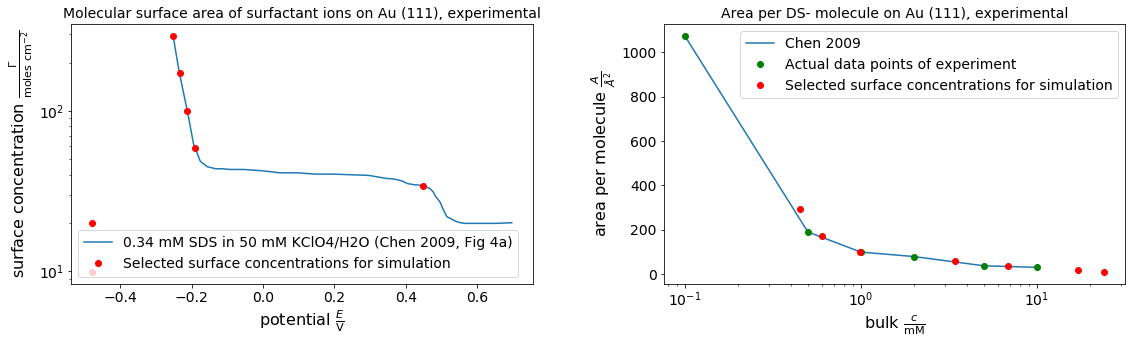

In [216]:
rows = 1
cols = 2

fig = plt.figure(figsize=(8*cols, 5*rows))

pos = subplotPosition(cols=cols,rows=rows)

p = next(pos)

_, ax = addSubplot(exp_chen2009_fig4a_data[["E"]],
                   exp_chen2009_fig4a_data[["A"]] / C.angstrom**2,
                   title = "Molecular surface area of surfactant ions on Au (111), experimental", 
                   xlabel = r'potential $\frac{E}{\mathrm{V}}$', 
                   ylabel = r'surface concentration $\frac{\Gamma}{\mathrm{moles \ cm^{-2}}}$',
                   legend = "0.34 mM SDS in 50 mM KClO4/H2O (Chen 2009, Fig 4a)", fig = fig, pos = p)
_, _ = addSubplot( exp_chen2009_fig4a_potential_from_molecular_area( 
                        sim_SDS_on_AU_111_molecular_surface_areas_of_interest ),
                   sim_SDS_on_AU_111_molecular_surface_areas_of_interest / C.angstrom**2,
                   legend = "Selected surface concentrations for simulation",
                   fmtstr='ro', fig = fig, pos = p, ax = ax)
ax.set_yscale("log")

p = next(pos)
_, ax = addSubplot(exp_sklt_unpublished_fig1_data[["c"]] / C.milli,
                   exp_sklt_unpublished_fig1_data[["A"]] / C.angstrom**2,
                   title = "Area per DS- molecule on Au (111), experimental", 
                   xlabel = r'bulk $\frac{c}{\mathrm{mM}}$', 
                   ylabel = r'area per molecule $\frac{A}{\AA^2}$',
                   legend = "Chen 2009", fig = fig, pos = p)
_, _ = addSubplot( exp_sklt_unpublished_fig1_data[["c"]] / C.milli,
                   exp_sklt_unpublished_fig1_data[["A"]] / C.angstrom**2,
                   legend = "Actual data points of experiment",
                   fmtstr='go', fig = fig, pos = p, ax = ax)
_, _ = addSubplot( 
    exp_sklt_unpublished_fig1_bulk_concentration_from_molecular_area( 
        sim_SDS_on_AU_111_molecular_surface_areas_of_interest) / C.milli,
        sim_SDS_on_AU_111_molecular_surface_areas_of_interest / C.angstrom**2,
                   legend = "Selected surface concentrations for simulation",
                   fmtstr='ro', fig = fig, pos = p, ax = ax)
ax.set_xscale("log")
#ax.set_xscale("log")


fig.tight_layout()

#### Construct standardized system descriptions

In [217]:
sim_SDS_on_AU_111_template_df = pd.DataFrame(
    data=sim_SDS_on_AU_111_template)

In [218]:
# sim_SDS_on_AU_111_bulk_concentrations_of_interest_sr = \
#     pd.Series(sim_SDS_on_AU_111_bulk_concentrations_of_interest,
#     name="sf_concentration")

In [219]:
sim_SDS_on_AU_111_molecular_surface_areas_of_interest_sr = \
    pd.Series(sim_SDS_on_AU_111_molecular_surface_areas_of_interest,
    name="sb_area_per_sf_molecule")

In [220]:
sim_SDS_on_AU_111_molecular_surface_areas_of_interest_sr

0    9.955720e-20
1    1.991144e-19
2    3.410067e-19
3    5.840138e-19
4    1.000192e-18
5    1.712945e-18
6    2.933619e-18
Name: sb_area_per_sf_molecule, dtype: float64

In [221]:
# cartesian product of representative areas and molecular surface areas
sim_SDS_on_AU_111_df = df_crossjoin(sim_SDS_on_AU_111_template_df,
    pd.DataFrame(sim_SDS_on_AU_111_molecular_surface_areas_of_interest_sr))

In [222]:
sim_SDS_on_AU_111_df[["sb_area_per_sf_molecule","box"]]

,sb_area_per_sf_molecule,box
0,9.955720e-20,"[4.9022900000000004e-09, 4.9948e-09, 1.8000000..."
1,1.991144e-19,"[4.9022900000000004e-09, 4.9948e-09, 1.8000000..."
2,3.410067e-19,"[4.9022900000000004e-09, 4.9948e-09, 1.8000000..."
3,5.840138e-19,"[4.9022900000000004e-09, 4.9948e-09, 1.8000000..."
4,1.000192e-18,"[4.9022900000000004e-09, 4.9948e-09, 1.8000000..."
5,1.712945e-18,"[4.9022900000000004e-09, 4.9948e-09, 1.8000000..."
6,2.933619e-18,"[4.9022900000000004e-09, 4.9948e-09, 1.8000000..."
7,9.955720e-20,"[7.49762e-09, 7.4922e-09, 1.8000000000000002e-08]"
8,1.991144e-19,"[7.49762e-09, 7.4922e-09, 1.8000000000000002e-08]"
9,3.410067e-19,"[7.49762e-09, 7.4922e-09, 1.8000000000000002e-08]"


In [223]:
# surface area in m
sim_SDS_on_AU_111_df["sb_measures"] = sim_SDS_on_AU_111_df["sb_multiples"] * sim_SDS_on_AU_111_df["sb_unit_cell"]

In [224]:
sim_SDS_on_AU_111_df[["sb_measures","box"]]

,sb_measures,box
0,"[4.9022900000000004e-09, 4.9948e-09, 1.41274e-09]","[4.9022900000000004e-09, 4.9948e-09, 1.8000000..."
1,"[4.9022900000000004e-09, 4.9948e-09, 1.41274e-09]","[4.9022900000000004e-09, 4.9948e-09, 1.8000000..."
2,"[4.9022900000000004e-09, 4.9948e-09, 1.41274e-09]","[4.9022900000000004e-09, 4.9948e-09, 1.8000000..."
3,"[4.9022900000000004e-09, 4.9948e-09, 1.41274e-09]","[4.9022900000000004e-09, 4.9948e-09, 1.8000000..."
4,"[4.9022900000000004e-09, 4.9948e-09, 1.41274e-09]","[4.9022900000000004e-09, 4.9948e-09, 1.8000000..."
5,"[4.9022900000000004e-09, 4.9948e-09, 1.41274e-09]","[4.9022900000000004e-09, 4.9948e-09, 1.8000000..."
6,"[4.9022900000000004e-09, 4.9948e-09, 1.41274e-09]","[4.9022900000000004e-09, 4.9948e-09, 1.8000000..."
7,"[7.49762e-09, 7.4922e-09, 1.41274e-09]","[7.49762e-09, 7.4922e-09, 1.8000000000000002e-08]"
8,"[7.49762e-09, 7.4922e-09, 1.41274e-09]","[7.49762e-09, 7.4922e-09, 1.8000000000000002e-08]"
9,"[7.49762e-09, 7.4922e-09, 1.41274e-09]","[7.49762e-09, 7.4922e-09, 1.8000000000000002e-08]"


In [225]:
sim_SDS_on_AU_111_df["sb_normal"] = 2 # surface normal 0,1 or 3 for x,y or z

In [226]:
sim_SDS_on_AU_111_df[["sb_volume"]] = sim_SDS_on_AU_111_df[["sb_measures"]].applymap(np.prod)

In [227]:
sim_SDS_on_AU_111_df[["sb_measures"]]

,sb_measures
0,"[4.9022900000000004e-09, 4.9948e-09, 1.41274e-09]"
1,"[4.9022900000000004e-09, 4.9948e-09, 1.41274e-09]"
2,"[4.9022900000000004e-09, 4.9948e-09, 1.41274e-09]"
3,"[4.9022900000000004e-09, 4.9948e-09, 1.41274e-09]"
4,"[4.9022900000000004e-09, 4.9948e-09, 1.41274e-09]"
5,"[4.9022900000000004e-09, 4.9948e-09, 1.41274e-09]"
6,"[4.9022900000000004e-09, 4.9948e-09, 1.41274e-09]"
7,"[7.49762e-09, 7.4922e-09, 1.41274e-09]"
8,"[7.49762e-09, 7.4922e-09, 1.41274e-09]"
9,"[7.49762e-09, 7.4922e-09, 1.41274e-09]"


In [228]:
# select component of array in column "sb_measures" based upon index stored in "sb_normal"
sim_SDS_on_AU_111_df["sb_thickness"] = sim_SDS_on_AU_111_df[["sb_measures","sb_normal"]].apply(
    lambda r: r["sb_measures"][r["sb_normal"]] ,raw=True,axis=1)

In [229]:
sim_SDS_on_AU_111_df["sb_area"] = sim_SDS_on_AU_111_df["sb_volume"] / sim_SDS_on_AU_111_df["sb_thickness"]

In [230]:
exp_sklt_unpublished_fig1_bulk_concentration_from_molecular_area( 
        sim_SDS_on_AU_111_df["sb_area_per_sf_molecule"] )

array([0.02416421, 0.01700699, 0.00680627, 0.00343719, 0.00099144,
       0.00060008, 0.00045309, 0.02416421, 0.01700699, 0.00680627,
       0.00343719, 0.00099144, 0.00060008, 0.00045309, 0.02416421,
       0.01700699, 0.00680627, 0.00343719, 0.00099144, 0.00060008,
       0.00045309, 0.02416421, 0.01700699, 0.00680627, 0.00343719,
       0.00099144, 0.00060008, 0.00045309])

In [231]:
sim_SDS_on_AU_111_df["sf_concentration"] = \
    exp_sklt_unpublished_fig1_bulk_concentration_from_molecular_area( 
        sim_SDS_on_AU_111_df["sb_area_per_sf_molecule"] )

In [232]:
sim_SDS_on_AU_111_df["sb_circular_area_per_sf_molecule_radius"] = \
    np.sqrt(sim_SDS_on_AU_111_df["sb_area_per_sf_molecule"])/np.pi

In [233]:
sim_SDS_on_AU_111_df["sb_square_area_per_sf_molecule_side"] = \
    np.sqrt(sim_SDS_on_AU_111_df["sb_area_per_sf_molecule"])

In [234]:
sim_SDS_on_AU_111_df["sf_nmolecules"] = \
    np.round(sim_SDS_on_AU_111_df["sb_area"] / sim_SDS_on_AU_111_df["sb_area_per_sf_molecule"]).astype(int)

In [235]:
sim_SDS_on_AU_111_df[["sf_nmolecules",
                       "sb_area_per_sf_molecule",
                       "sb_circular_area_per_sf_molecule_radius",
                       "sb_square_area_per_sf_molecule_side"]]

,sf_nmolecules,sb_area_per_sf_molecule,sb_circular_area_per_sf_molecule_radius,sb_square_area_per_sf_molecule_side
0,246,9.955720e-20,1.004353e-10,3.155269e-10
1,123,1.991144e-19,1.420370e-10,4.462224e-10
2,72,3.410067e-19,1.858795e-10,5.839578e-10
3,42,5.840138e-19,2.432549e-10,7.642079e-10
4,24,1.000192e-18,3.183404e-10,1.000096e-09
5,14,1.712945e-18,4.166025e-10,1.308795e-09
6,8,2.933619e-18,5.451951e-10,1.712781e-09
7,564,9.955720e-20,1.004353e-10,3.155269e-10
8,282,1.991144e-19,1.420370e-10,4.462224e-10
9,165,3.410067e-19,1.858795e-10,5.839578e-10


In [236]:
sim_SDS_on_AU_111_df[["sf_concentration", "sb_multiples","sf_nmolecules"]]

,sf_concentration,sb_multiples,sf_nmolecules
0,0.024164,"[17, 10, 2]",246
1,0.017007,"[17, 10, 2]",123
2,0.006806,"[17, 10, 2]",72
3,0.003437,"[17, 10, 2]",42
4,0.000991,"[17, 10, 2]",24
5,0.000600,"[17, 10, 2]",14
6,0.000453,"[17, 10, 2]",8
7,0.024164,"[26, 15, 2]",564
8,0.017007,"[26, 15, 2]",282
9,0.006806,"[26, 15, 2]",165


#### Substrate slab IDs

In [237]:
template_substrate_name = "{substrate:s}_{plane:03d}_{multiples[0]:d}x{multiples[1]:d}x{multiples[2]:d}"
# substrtae slabs are identified by unique names such as
# AU_111_2x3x4 for a 111 gold slab with 2, 3, and 4 multiples 
# of the underlying unit cell in each spatial direction respectively
sim_SDS_on_AU_111_df["sb_name"] = sim_SDS_on_AU_111_df.apply(
    lambda r: template_substrate_name.format(substrate=r["substrate"],
                                                plane=r["sb_crystal_plane"],
                                                multiples=r["sb_multiples"])
                                                ,axis=1)

In [238]:
sim_SDS_on_AU_111_df["sb_name"]

0     AU_111_17x10x2
1     AU_111_17x10x2
2     AU_111_17x10x2
3     AU_111_17x10x2
4     AU_111_17x10x2
5     AU_111_17x10x2
6     AU_111_17x10x2
7     AU_111_26x15x2
8     AU_111_26x15x2
9     AU_111_26x15x2
10    AU_111_26x15x2
11    AU_111_26x15x2
12    AU_111_26x15x2
13    AU_111_26x15x2
14    AU_111_51x30x2
15    AU_111_51x30x2
16    AU_111_51x30x2
17    AU_111_51x30x2
18    AU_111_51x30x2
19    AU_111_51x30x2
20    AU_111_51x30x2
21    AU_111_60x35x2
22    AU_111_60x35x2
23    AU_111_60x35x2
24    AU_111_60x35x2
25    AU_111_60x35x2
26    AU_111_60x35x2
27    AU_111_60x35x2
Name: sb_name, dtype: object

#### Duplicate system sets and apply tiny modifications

In [239]:
sim_SDS_on_AU_111_duplicated_df = sim_SDS_on_AU_111_df.copy()

In [240]:
# here system with prearranged counterions
sim_SDS_on_AU_111_duplicated_df['sf_preassembly'] += '_with_counterion'

In [241]:
sim_SDS_on_AU_111_df = pd.concat([sim_SDS_on_AU_111_df,sim_SDS_on_AU_111_duplicated_df], 
          ignore_index=True)

In [242]:
sim_SDS_on_AU_111_df.loc[
  sim_SDS_on_AU_111_df["sf_preassembly"] == 'bilayer_with_counterion',
    "ci_initial_placement"] = "at_polar_head"

In [243]:
substrate

['alumina', 'gold', 'graphite', 'mica', 'silica']

In [244]:
# select only surface of area able to fit 3 hemicylindrical aggregates
sim_SDS_on_AU_111_subset_df = sim_SDS_on_AU_111_df[(sim_SDS_on_AU_111_df["sb_name"] == 'AU_111_51x30x2') & \
    (sim_SDS_on_AU_111_df["ci_initial_placement"] == 'at_polar_head')].copy()

In [245]:
sim_SDS_on_AU_111_subset_df["sf_nmolecules"]

42    2214
43    1107
44     646
45     377
46     220
47     129
48      75
Name: sf_nmolecules, dtype: int64

In [246]:
sf_preassemply_list = [
    "monolayer_with_counterion", 
    "inverse_monolayer_with_counterion",
    "inverse_bilayer_with_counterion", 
    "cylinders_with_counterion",
    "hemicylinders_with_counterion"]

In [247]:
sim_SDS_on_AU_111_subset_df_list = [ 
    sim_SDS_on_AU_111_subset_df.copy() for i in range(len(sf_preassemply_list))]

In [248]:
for n in range(len(sf_preassemply_list)):
    sim_SDS_on_AU_111_subset_df_list[n]["sf_preassembly"] = sf_preassemply_list[n]

In [249]:
sim_SDS_on_AU_111_extension_df = pd.concat(sim_SDS_on_AU_111_subset_df_list,ignore_index=True)

In [250]:
sim_SDS_on_AU_111_extension_df

,box,ci_initial_placement,counterion,pbc,pressure,sb_crystal_plane,sb_multiples,sb_unit_cell,sf_preassembly,solvent,...,sb_measures,sb_normal,sb_volume,sb_thickness,sb_area,sf_concentration,sb_circular_area_per_sf_molecule_radius,sb_square_area_per_sf_molecule_side,sf_nmolecules,sb_name
0,"[1.470687e-08, 1.49844e-08, 1.8000000000000002...",at_polar_head,NA,111,1,111,"[51, 30, 2]","[2.8837e-10, 4.9948e-10, 7.0637e-10]",monolayer_with_counterion,H2O,...,"[1.470687e-08, 1.49844e-08, 1.41274e-09]",2,3.113306e-25,1.412740e-09,2.203736e-16,0.024164,1.004353e-10,3.155269e-10,2214,AU_111_51x30x2
1,"[1.470687e-08, 1.49844e-08, 1.8000000000000002...",at_polar_head,NA,111,1,111,"[51, 30, 2]","[2.8837e-10, 4.9948e-10, 7.0637e-10]",monolayer_with_counterion,H2O,...,"[1.470687e-08, 1.49844e-08, 1.41274e-09]",2,3.113306e-25,1.412740e-09,2.203736e-16,0.017007,1.420370e-10,4.462224e-10,1107,AU_111_51x30x2
2,"[1.470687e-08, 1.49844e-08, 1.8000000000000002...",at_polar_head,NA,111,1,111,"[51, 30, 2]","[2.8837e-10, 4.9948e-10, 7.0637e-10]",monolayer_with_counterion,H2O,...,"[1.470687e-08, 1.49844e-08, 1.41274e-09]",2,3.113306e-25,1.412740e-09,2.203736e-16,0.006806,1.858795e-10,5.839578e-10,646,AU_111_51x30x2
3,"[1.470687e-08, 1.49844e-08, 1.8000000000000002...",at_polar_head,NA,111,1,111,"[51, 30, 2]","[2.8837e-10, 4.9948e-10, 7.0637e-10]",monolayer_with_counterion,H2O,...,"[1.470687e-08, 1.49844e-08, 1.41274e-09]",2,3.113306e-25,1.412740e-09,2.203736e-16,0.003437,2.432549e-10,7.642079e-10,377,AU_111_51x30x2
4,"[1.470687e-08, 1.49844e-08, 1.8000000000000002...",at_polar_head,NA,111,1,111,"[51, 30, 2]","[2.8837e-10, 4.9948e-10, 7.0637e-10]",monolayer_with_counterion,H2O,...,"[1.470687e-08, 1.49844e-08, 1.41274e-09]",2,3.113306e-25,1.412740e-09,2.203736e-16,0.000991,3.183404e-10,1.000096e-09,220,AU_111_51x30x2
5,"[1.470687e-08, 1.49844e-08, 1.8000000000000002...",at_polar_head,NA,111,1,111,"[51, 30, 2]","[2.8837e-10, 4.9948e-10, 7.0637e-10]",monolayer_with_counterion,H2O,...,"[1.470687e-08, 1.49844e-08, 1.41274e-09]",2,3.113306e-25,1.412740e-09,2.203736e-16,0.000600,4.166025e-10,1.308795e-09,129,AU_111_51x30x2
6,"[1.470687e-08, 1.49844e-08, 1.8000000000000002...",at_polar_head,NA,111,1,111,"[51, 30, 2]","[2.8837e-10, 4.9948e-10, 7.0637e-10]",monolayer_with_counterion,H2O,...,"[1.470687e-08, 1.49844e-08, 1.41274e-09]",2,3.113306e-25,1.412740e-09,2.203736e-16,0.000453,5.451951e-10,1.712781e-09,75,AU_111_51x30x2
7,"[1.470687e-08, 1.49844e-08, 1.8000000000000002...",at_polar_head,NA,111,1,111,"[51, 30, 2]","[2.8837e-10, 4.9948e-10, 7.0637e-10]",inverse_monolayer_with_counterion,H2O,...,"[1.470687e-08, 1.49844e-08, 1.41274e-09]",2,3.113306e-25,1.412740e-09,2.203736e-16,0.024164,1.004353e-10,3.155269e-10,2214,AU_111_51x30x2
8,"[1.470687e-08, 1.49844e-08, 1.8000000000000002...",at_polar_head,NA,111,1,111,"[51, 30, 2]","[2.8837e-10, 4.9948e-10, 7.0637e-10]",inverse_monolayer_with_counterion,H2O,...,"[1.470687e-08, 1.49844e-08, 1.41274e-09]",2,3.113306e-25,1.412740e-09,2.203736e-16,0.017007,1.420370e-10,4.462224e-10,1107,AU_111_51x30x2
9,"[1.470687e-08, 1.49844e-08, 1.8000000000000002...",at_polar_head,NA,111,1,111,"[51, 30, 2]","[2.8837e-10, 4.9948e-10, 7.0637e-10]",inverse_monolayer_with_counterion,H2O,...,"[1.470687e-08, 1.49844e-08, 1.41274e-09]",2,3.113306e-25,1.412740e-09,2.203736e-16,0.006806,1.858795e-10,5.839578e-10,646,AU_111_51x30x2


#### Unique system names

In [251]:
# construct unique system names:
template_system_name = "{sfN:d}_{surfactant:s}_on_{substrate:s}_{suffix:s}"
# sim_SDS_on_AU_111_df["system_name"] = 
sim_SDS_on_AU_111_extension_df["system_name"] = sim_SDS_on_AU_111_extension_df.apply( 
    lambda r: template_system_name.format(sfN=r["sf_nmolecules"],
                                          surfactant=r["surfactant"],
                                          substrate=r["sb_name"],
                                          suffix=r["sf_preassembly"]), axis=1)

In [252]:
# construct unique system names:
template_system_name = "{sfN:d}_{surfactant:s}_on_{substrate:s}_{suffix:s}"
# sim_SDS_on_AU_111_df["system_name"] = 
sim_SDS_on_AU_111_df["system_name"] = sim_SDS_on_AU_111_df.apply( 
    lambda r: template_system_name.format(sfN=r["sf_nmolecules"],
                                          surfactant=r["surfactant"],
                                          substrate=r["sb_name"],
                                          suffix=r["sf_preassembly"]), axis=1)

In [253]:
sim_SDS_on_AU_111_df

,box,ci_initial_placement,counterion,pbc,pressure,sb_crystal_plane,sb_multiples,sb_unit_cell,sf_preassembly,solvent,...,sb_normal,sb_volume,sb_thickness,sb_area,sf_concentration,sb_circular_area_per_sf_molecule_radius,sb_square_area_per_sf_molecule_side,sf_nmolecules,sb_name,system_name
0,"[4.9022900000000004e-09, 4.9948e-09, 1.8000000...",random,NA,111,1,111,"[17, 10, 2]","[2.8837e-10, 4.9948e-10, 7.0637e-10]",bilayer,H2O,...,2,3.459229e-26,1.412740e-09,2.448596e-17,0.024164,1.004353e-10,3.155269e-10,246,AU_111_17x10x2,246_SDS_on_AU_111_17x10x2_bilayer
1,"[4.9022900000000004e-09, 4.9948e-09, 1.8000000...",random,NA,111,1,111,"[17, 10, 2]","[2.8837e-10, 4.9948e-10, 7.0637e-10]",bilayer,H2O,...,2,3.459229e-26,1.412740e-09,2.448596e-17,0.017007,1.420370e-10,4.462224e-10,123,AU_111_17x10x2,123_SDS_on_AU_111_17x10x2_bilayer
2,"[4.9022900000000004e-09, 4.9948e-09, 1.8000000...",random,NA,111,1,111,"[17, 10, 2]","[2.8837e-10, 4.9948e-10, 7.0637e-10]",bilayer,H2O,...,2,3.459229e-26,1.412740e-09,2.448596e-17,0.006806,1.858795e-10,5.839578e-10,72,AU_111_17x10x2,72_SDS_on_AU_111_17x10x2_bilayer
3,"[4.9022900000000004e-09, 4.9948e-09, 1.8000000...",random,NA,111,1,111,"[17, 10, 2]","[2.8837e-10, 4.9948e-10, 7.0637e-10]",bilayer,H2O,...,2,3.459229e-26,1.412740e-09,2.448596e-17,0.003437,2.432549e-10,7.642079e-10,42,AU_111_17x10x2,42_SDS_on_AU_111_17x10x2_bilayer
4,"[4.9022900000000004e-09, 4.9948e-09, 1.8000000...",random,NA,111,1,111,"[17, 10, 2]","[2.8837e-10, 4.9948e-10, 7.0637e-10]",bilayer,H2O,...,2,3.459229e-26,1.412740e-09,2.448596e-17,0.000991,3.183404e-10,1.000096e-09,24,AU_111_17x10x2,24_SDS_on_AU_111_17x10x2_bilayer
5,"[4.9022900000000004e-09, 4.9948e-09, 1.8000000...",random,NA,111,1,111,"[17, 10, 2]","[2.8837e-10, 4.9948e-10, 7.0637e-10]",bilayer,H2O,...,2,3.459229e-26,1.412740e-09,2.448596e-17,0.000600,4.166025e-10,1.308795e-09,14,AU_111_17x10x2,14_SDS_on_AU_111_17x10x2_bilayer
6,"[4.9022900000000004e-09, 4.9948e-09, 1.8000000...",random,NA,111,1,111,"[17, 10, 2]","[2.8837e-10, 4.9948e-10, 7.0637e-10]",bilayer,H2O,...,2,3.459229e-26,1.412740e-09,2.448596e-17,0.000453,5.451951e-10,1.712781e-09,8,AU_111_17x10x2,8_SDS_on_AU_111_17x10x2_bilayer
7,"[7.49762e-09, 7.4922e-09, 1.8000000000000002e-08]",random,NA,111,1,111,"[26, 15, 2]","[2.8837e-10, 4.9948e-10, 7.0637e-10]",bilayer,H2O,...,2,7.935879e-26,1.412740e-09,5.617367e-17,0.024164,1.004353e-10,3.155269e-10,564,AU_111_26x15x2,564_SDS_on_AU_111_26x15x2_bilayer
8,"[7.49762e-09, 7.4922e-09, 1.8000000000000002e-08]",random,NA,111,1,111,"[26, 15, 2]","[2.8837e-10, 4.9948e-10, 7.0637e-10]",bilayer,H2O,...,2,7.935879e-26,1.412740e-09,5.617367e-17,0.017007,1.420370e-10,4.462224e-10,282,AU_111_26x15x2,282_SDS_on_AU_111_26x15x2_bilayer
9,"[7.49762e-09, 7.4922e-09, 1.8000000000000002e-08]",random,NA,111,1,111,"[26, 15, 2]","[2.8837e-10, 4.9948e-10, 7.0637e-10]",bilayer,H2O,...,2,7.935879e-26,1.412740e-09,5.617367e-17,0.006806,1.858795e-10,5.839578e-10,165,AU_111_26x15x2,165_SDS_on_AU_111_26x15x2_bilayer


In [254]:
sim_SDS_on_AU_111_df = pd.concat(
    [sim_SDS_on_AU_111_df, sim_SDS_on_AU_111_extension_df],
    ignore_index=True)

In [255]:
sim_SDS_on_AU_111_df

,box,ci_initial_placement,counterion,pbc,pressure,sb_crystal_plane,sb_multiples,sb_unit_cell,sf_preassembly,solvent,...,sb_normal,sb_volume,sb_thickness,sb_area,sf_concentration,sb_circular_area_per_sf_molecule_radius,sb_square_area_per_sf_molecule_side,sf_nmolecules,sb_name,system_name
0,"[4.9022900000000004e-09, 4.9948e-09, 1.8000000...",random,NA,111,1,111,"[17, 10, 2]","[2.8837e-10, 4.9948e-10, 7.0637e-10]",bilayer,H2O,...,2,3.459229e-26,1.412740e-09,2.448596e-17,0.024164,1.004353e-10,3.155269e-10,246,AU_111_17x10x2,246_SDS_on_AU_111_17x10x2_bilayer
1,"[4.9022900000000004e-09, 4.9948e-09, 1.8000000...",random,NA,111,1,111,"[17, 10, 2]","[2.8837e-10, 4.9948e-10, 7.0637e-10]",bilayer,H2O,...,2,3.459229e-26,1.412740e-09,2.448596e-17,0.017007,1.420370e-10,4.462224e-10,123,AU_111_17x10x2,123_SDS_on_AU_111_17x10x2_bilayer
2,"[4.9022900000000004e-09, 4.9948e-09, 1.8000000...",random,NA,111,1,111,"[17, 10, 2]","[2.8837e-10, 4.9948e-10, 7.0637e-10]",bilayer,H2O,...,2,3.459229e-26,1.412740e-09,2.448596e-17,0.006806,1.858795e-10,5.839578e-10,72,AU_111_17x10x2,72_SDS_on_AU_111_17x10x2_bilayer
3,"[4.9022900000000004e-09, 4.9948e-09, 1.8000000...",random,NA,111,1,111,"[17, 10, 2]","[2.8837e-10, 4.9948e-10, 7.0637e-10]",bilayer,H2O,...,2,3.459229e-26,1.412740e-09,2.448596e-17,0.003437,2.432549e-10,7.642079e-10,42,AU_111_17x10x2,42_SDS_on_AU_111_17x10x2_bilayer
4,"[4.9022900000000004e-09, 4.9948e-09, 1.8000000...",random,NA,111,1,111,"[17, 10, 2]","[2.8837e-10, 4.9948e-10, 7.0637e-10]",bilayer,H2O,...,2,3.459229e-26,1.412740e-09,2.448596e-17,0.000991,3.183404e-10,1.000096e-09,24,AU_111_17x10x2,24_SDS_on_AU_111_17x10x2_bilayer
5,"[4.9022900000000004e-09, 4.9948e-09, 1.8000000...",random,NA,111,1,111,"[17, 10, 2]","[2.8837e-10, 4.9948e-10, 7.0637e-10]",bilayer,H2O,...,2,3.459229e-26,1.412740e-09,2.448596e-17,0.000600,4.166025e-10,1.308795e-09,14,AU_111_17x10x2,14_SDS_on_AU_111_17x10x2_bilayer
6,"[4.9022900000000004e-09, 4.9948e-09, 1.8000000...",random,NA,111,1,111,"[17, 10, 2]","[2.8837e-10, 4.9948e-10, 7.0637e-10]",bilayer,H2O,...,2,3.459229e-26,1.412740e-09,2.448596e-17,0.000453,5.451951e-10,1.712781e-09,8,AU_111_17x10x2,8_SDS_on_AU_111_17x10x2_bilayer
7,"[7.49762e-09, 7.4922e-09, 1.8000000000000002e-08]",random,NA,111,1,111,"[26, 15, 2]","[2.8837e-10, 4.9948e-10, 7.0637e-10]",bilayer,H2O,...,2,7.935879e-26,1.412740e-09,5.617367e-17,0.024164,1.004353e-10,3.155269e-10,564,AU_111_26x15x2,564_SDS_on_AU_111_26x15x2_bilayer
8,"[7.49762e-09, 7.4922e-09, 1.8000000000000002e-08]",random,NA,111,1,111,"[26, 15, 2]","[2.8837e-10, 4.9948e-10, 7.0637e-10]",bilayer,H2O,...,2,7.935879e-26,1.412740e-09,5.617367e-17,0.017007,1.420370e-10,4.462224e-10,282,AU_111_26x15x2,282_SDS_on_AU_111_26x15x2_bilayer
9,"[7.49762e-09, 7.4922e-09, 1.8000000000000002e-08]",random,NA,111,1,111,"[26, 15, 2]","[2.8837e-10, 4.9948e-10, 7.0637e-10]",bilayer,H2O,...,2,7.935879e-26,1.412740e-09,5.617367e-17,0.006806,1.858795e-10,5.839578e-10,165,AU_111_26x15x2,165_SDS_on_AU_111_26x15x2_bilayer


#### Store to file

In [256]:
len(sim_SDS_on_AU_111_df)

91

In [257]:
prefix

'/mnt/dat/work/testuser/adsorption/N_surfactant_on_substrate_template'

In [258]:
pkl_SDS_on_AU_111 = os.path.join(prefix, 'dat', 'sys', 'SDS_on_AU_111.pkl')

In [259]:
#sim_SDS_on_AU_111_df.to_pickle(pkl_SDS_on_AU_111)

In [260]:
pkl_SDS_on_AU_111_extension = os.path.join(prefix, 'dat', 'sys', 'SDS_on_AU_111_extension.pkl')

In [261]:
#sim_SDS_on_AU_111_extension_df.to_pickle(pkl_SDS_on_AU_111_extension)

### from Kawasaki 2007

In [262]:
sim_CTAB_on_AU_111_template=  {
    "surfactant": "CTAB",
    "substrate":  "AU",
    "counterion": "BR",
    "solvent":    "H2O",
    "sf_preassembly":   "bilayer",
    "sb_crystal_plane": 111,
    "sb_unit_cell":     [unit_cell_AU_111]*len(list(sb_multiples_CTAB)),
    "sb_multiples":     list(sb_multiples_CTAB),
    "ci_initial_placement":  "random",
    "sv_density":       0.997e3, # kg m^-3
    "sv_preassembly":   "random",
    "pbc":              111,
    #"box":              [np.array([64,64,128])*1e-10], # m
    "box":              list(box_measures_CTAB), # m
    "temperature":      298, # K
    "pressure":         1, # atm
    }

In [263]:
sim_CTAB_on_AU_111_template

{'surfactant': 'CTAB',
 'substrate': 'AU',
 'counterion': 'BR',
 'solvent': 'H2O',
 'sf_preassembly': 'bilayer',
 'sb_crystal_plane': 111,
 'sb_unit_cell': [array([2.8837e-10, 4.9948e-10, 7.0637e-10]),
  array([2.8837e-10, 4.9948e-10, 7.0637e-10]),
  array([2.8837e-10, 4.9948e-10, 7.0637e-10]),
  array([2.8837e-10, 4.9948e-10, 7.0637e-10])],
 'sb_multiples': [array([21, 12,  2]),
  array([30, 18,  2]),
  array([63, 36,  2]),
  array([72, 42,  2])],
 'ci_initial_placement': 'random',
 'sv_density': 997.0,
 'sv_preassembly': 'random',
 'pbc': 111,
 'box': [array([6.05577e-09, 5.99376e-09, 1.80000e-08]),
  array([8.65110e-09, 8.99064e-09, 1.80000e-08]),
  array([1.816731e-08, 1.798128e-08, 1.800000e-08]),
  array([2.076264e-08, 2.097816e-08, 1.800000e-08])],
 'temperature': 298,
 'pressure': 1}

In [264]:
c_interval_CTAB = [exp_kawasaki2007influence_fig1b_data["c"].min(),exp_kawasaki2007influence_fig1b_data["c"].max()]

In [265]:
c_interval_CTAB

[6.717826410882857e-06, 0.009435444686212801]

In [266]:
A_interval_CTAB = [exp_kawasaki2007influence_fig1b_data["A"].min(),exp_kawasaki2007influence_fig1b_data["A"].max()]

In [267]:
np.array(A_interval_CTAB) / C.angstrom**2

array([25.01521968, 90.32043919])

In [268]:
# note: dasilva2018molecular CTAB 1st cmc 0.92 mM, 2nd cmc 0.27 M
# note: kawasaki2007influenc lowest concentration 0.003 mM, 0.03 mM 1st transition, 
#       1mM saturation, 10 mM highest concentration
sim_CTAB_on_AU_111_bulk_concentrations_of_interest = np.array([ 
                                                       0.007e-3, # lowest available, kawasaki2007
                                                       0.010e-3, # below 1st transition, kawasaki2007,
                                                       0.030e-3, # first transition
                                                       0.100e-3, # above first transition
                                                       0.500e-3, # below saturation, below CMC
                                                       0.920e-3, # CMC 
                                                       #1.000e-3, # at surface saturation, above CMC,
                                                       #3.000e-3, # above surface saturation,
                                                       #9.000e-3, # almost highest measured 
                                                       # no increase of adsorption above CMC
                                                     ])

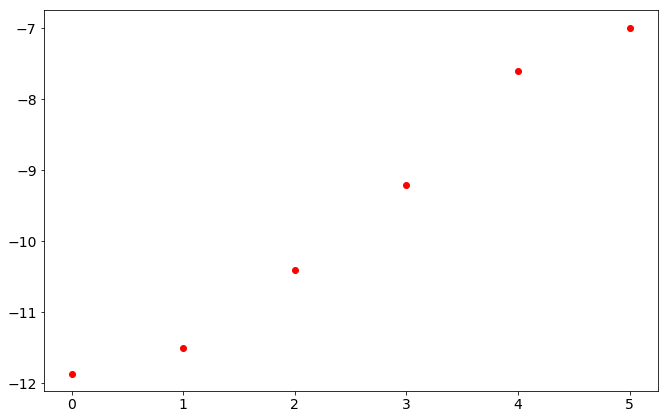

In [269]:
plt.plot(np.log(sim_CTAB_on_AU_111_bulk_concentrations_of_interest),'ro')

In [270]:
sim_CTAB_on_AU_111_monolayer_density_from_logc = scipy.interpolate.interp1d(
    np.log(exp_kawasaki2007influence_fig1b_data["c"]),
    exp_kawasaki2007influence_fig1b_data["A"], 
    axis=0, kind='linear')
sim_CTAB_on_AU_111_monolayer_density_from_c = lambda c: sim_CTAB_on_AU_111_monolayer_density_from_logc( np.log(c) )

In [271]:
sim_CTAB_on_AU_111_area_per_monolayer_molecule = \
    sim_CTAB_on_AU_111_monolayer_density_from_c( sim_CTAB_on_AU_111_bulk_concentrations_of_interest )

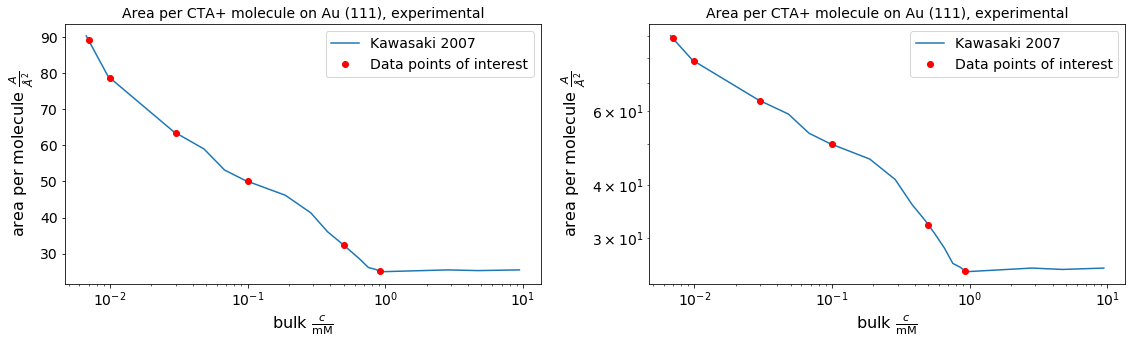

In [272]:
rows = 1
cols = 2

fig = plt.figure(figsize=(8*cols, 5*rows))

pos = subplotPosition(cols=cols,rows=rows)

p = next(pos)

#p = next(pos)
_, ax = addSubplot(exp_kawasaki2007influence_fig1b_data[["c"]] / C.milli,
                   exp_kawasaki2007influence_fig1b_data[["A"]] / C.angstrom**2,
                   title = "Area per CTA+ molecule on Au (111), experimental", 
                   xlabel = r'bulk $\frac{c}{\mathrm{mM}}$', 
                   ylabel = r'area per molecule $\frac{A}{\AA^2}$',
                   legend = "Kawasaki 2007", fig = fig, pos = p)
#ax.set_xscale("log")
_, _ = addSubplot(sim_CTAB_on_AU_111_bulk_concentrations_of_interest / C.milli,
                   sim_CTAB_on_AU_111_area_per_monolayer_molecule / C.angstrom**2,
                   legend = "Data points of interest", ax = ax, pos = p, fmtstr='ro')
ax.set_xscale("log")

p = next(pos)

#p = next(pos)
_, ax = addSubplot(exp_kawasaki2007influence_fig1b_data[["c"]] / C.milli,
                   exp_kawasaki2007influence_fig1b_data[["A"]] / C.angstrom**2,
                   title = "Area per CTA+ molecule on Au (111), experimental", 
                   xlabel = r'bulk $\frac{c}{\mathrm{mM}}$', 
                   ylabel = r'area per molecule $\frac{A}{\AA^2}$',
                   legend = "Kawasaki 2007", fig = fig, pos = p)
#ax.set_xscale("log")
_, _ = addSubplot(sim_CTAB_on_AU_111_bulk_concentrations_of_interest / C.milli,
                   sim_CTAB_on_AU_111_area_per_monolayer_molecule / C.angstrom**2,
                   legend = "Data points of interest", ax = ax, pos = p, fmtstr='ro')
ax.set_yscale("log")
ax.set_xscale("log")


fig.tight_layout()

In [273]:
sim_CTAB_on_AU_111_template

{'surfactant': 'CTAB',
 'substrate': 'AU',
 'counterion': 'BR',
 'solvent': 'H2O',
 'sf_preassembly': 'bilayer',
 'sb_crystal_plane': 111,
 'sb_unit_cell': [array([2.8837e-10, 4.9948e-10, 7.0637e-10]),
  array([2.8837e-10, 4.9948e-10, 7.0637e-10]),
  array([2.8837e-10, 4.9948e-10, 7.0637e-10]),
  array([2.8837e-10, 4.9948e-10, 7.0637e-10])],
 'sb_multiples': [array([21, 12,  2]),
  array([30, 18,  2]),
  array([63, 36,  2]),
  array([72, 42,  2])],
 'ci_initial_placement': 'random',
 'sv_density': 997.0,
 'sv_preassembly': 'random',
 'pbc': 111,
 'box': [array([6.05577e-09, 5.99376e-09, 1.80000e-08]),
  array([8.65110e-09, 8.99064e-09, 1.80000e-08]),
  array([1.816731e-08, 1.798128e-08, 1.800000e-08]),
  array([2.076264e-08, 2.097816e-08, 1.800000e-08])],
 'temperature': 298,
 'pressure': 1}

In [274]:
sim_CTAB_on_AU_111_template_df = pd.DataFrame(
    #columns=columns_simulation_properties, 
    data=sim_CTAB_on_AU_111_template)

In [275]:
sim_CTAB_on_AU_111_bulk_concentrations_of_interest_sr = pd.Series(sim_CTAB_on_AU_111_bulk_concentrations_of_interest,
                                                                  name="sf_concentration")

In [276]:
sim_CTAB_on_AU_111_bulk_concentrations_of_interest_sr

0    0.000007
1    0.000010
2    0.000030
3    0.000100
4    0.000500
5    0.000920
Name: sf_concentration, dtype: float64

In [277]:
sim_CTAB_on_AU_111_df = df_crossjoin(sim_CTAB_on_AU_111_template_df,
                                     pd.DataFrame(sim_CTAB_on_AU_111_bulk_concentrations_of_interest_sr))

In [278]:
sim_CTAB_on_AU_111_df[["sf_concentration","box"]]

,sf_concentration,box
0,0.000007,"[6.05577e-09, 5.99376e-09, 1.8000000000000002e..."
1,0.000010,"[6.05577e-09, 5.99376e-09, 1.8000000000000002e..."
2,0.000030,"[6.05577e-09, 5.99376e-09, 1.8000000000000002e..."
3,0.000100,"[6.05577e-09, 5.99376e-09, 1.8000000000000002e..."
4,0.000500,"[6.05577e-09, 5.99376e-09, 1.8000000000000002e..."
5,0.000920,"[6.05577e-09, 5.99376e-09, 1.8000000000000002e..."
6,0.000007,"[8.6511e-09, 8.99064e-09, 1.8000000000000002e-08]"
7,0.000010,"[8.6511e-09, 8.99064e-09, 1.8000000000000002e-08]"
8,0.000030,"[8.6511e-09, 8.99064e-09, 1.8000000000000002e-08]"
9,0.000100,"[8.6511e-09, 8.99064e-09, 1.8000000000000002e-08]"


In [279]:
# surface area in m
sim_CTAB_on_AU_111_df["sb_measures"] = sim_CTAB_on_AU_111_df["sb_multiples"] * sim_CTAB_on_AU_111_df["sb_unit_cell"]

In [280]:
sim_CTAB_on_AU_111_df[["sb_measures","box"]]

,sb_measures,box
0,"[6.05577e-09, 5.99376e-09, 1.41274e-09]","[6.05577e-09, 5.99376e-09, 1.8000000000000002e..."
1,"[6.05577e-09, 5.99376e-09, 1.41274e-09]","[6.05577e-09, 5.99376e-09, 1.8000000000000002e..."
2,"[6.05577e-09, 5.99376e-09, 1.41274e-09]","[6.05577e-09, 5.99376e-09, 1.8000000000000002e..."
3,"[6.05577e-09, 5.99376e-09, 1.41274e-09]","[6.05577e-09, 5.99376e-09, 1.8000000000000002e..."
4,"[6.05577e-09, 5.99376e-09, 1.41274e-09]","[6.05577e-09, 5.99376e-09, 1.8000000000000002e..."
5,"[6.05577e-09, 5.99376e-09, 1.41274e-09]","[6.05577e-09, 5.99376e-09, 1.8000000000000002e..."
6,"[8.6511e-09, 8.99064e-09, 1.41274e-09]","[8.6511e-09, 8.99064e-09, 1.8000000000000002e-08]"
7,"[8.6511e-09, 8.99064e-09, 1.41274e-09]","[8.6511e-09, 8.99064e-09, 1.8000000000000002e-08]"
8,"[8.6511e-09, 8.99064e-09, 1.41274e-09]","[8.6511e-09, 8.99064e-09, 1.8000000000000002e-08]"
9,"[8.6511e-09, 8.99064e-09, 1.41274e-09]","[8.6511e-09, 8.99064e-09, 1.8000000000000002e-08]"


In [281]:
sim_CTAB_on_AU_111_df["sb_normal"] = 2 # surface normal 0,1 or 3 for x,y or z

In [282]:
sim_CTAB_on_AU_111_df[["sb_volume"]] = sim_CTAB_on_AU_111_df[["sb_measures"]].applymap(np.prod)

In [283]:
sim_CTAB_on_AU_111_df[["sb_measures"]]

,sb_measures
0,"[6.05577e-09, 5.99376e-09, 1.41274e-09]"
1,"[6.05577e-09, 5.99376e-09, 1.41274e-09]"
2,"[6.05577e-09, 5.99376e-09, 1.41274e-09]"
3,"[6.05577e-09, 5.99376e-09, 1.41274e-09]"
4,"[6.05577e-09, 5.99376e-09, 1.41274e-09]"
5,"[6.05577e-09, 5.99376e-09, 1.41274e-09]"
6,"[8.6511e-09, 8.99064e-09, 1.41274e-09]"
7,"[8.6511e-09, 8.99064e-09, 1.41274e-09]"
8,"[8.6511e-09, 8.99064e-09, 1.41274e-09]"
9,"[8.6511e-09, 8.99064e-09, 1.41274e-09]"


In [284]:
# select component of array in column "sb_measures" based upon index stored in "sb_normal"
sim_CTAB_on_AU_111_df["sb_thickness"] = sim_CTAB_on_AU_111_df[["sb_measures","sb_normal"]].apply(
    lambda r: r["sb_measures"][r["sb_normal"]] ,raw=True,axis=1)

In [285]:
sim_CTAB_on_AU_111_df["sb_area"] = sim_CTAB_on_AU_111_df["sb_volume"] / sim_CTAB_on_AU_111_df["sb_thickness"]

In [286]:
sim_CTAB_on_AU_111_df["sb_area_per_sf_molecule"] = \
    sim_CTAB_on_AU_111_monolayer_density_from_c( sim_CTAB_on_AU_111_df["sf_concentration"] )

In [287]:
sim_CTAB_on_AU_111_df[["sb_area_per_sf_molecule"]]*1e20

,sb_area_per_sf_molecule
0,89.058554
1,78.663289
2,63.470638
3,50.035575
4,32.329975
5,25.167867
6,89.058554
7,78.663289
8,63.470638
9,50.035575


In [288]:
sim_CTAB_on_AU_111_df["sb_circular_area_per_sf_molecule_radius"] = \
    np.sqrt(sim_CTAB_on_AU_111_df["sb_area_per_sf_molecule"])/np.pi

In [289]:
sim_CTAB_on_AU_111_df["sb_square_area_per_sf_molecule_side"] = \
    np.sqrt(sim_CTAB_on_AU_111_df["sb_area_per_sf_molecule"])

In [290]:
sim_CTAB_on_AU_111_df["sf_nmolecules"] = \
    np.round(sim_CTAB_on_AU_111_df["sb_area"] / sim_CTAB_on_AU_111_df["sb_area_per_sf_molecule"]).astype(int)

In [291]:
sim_CTAB_on_AU_111_df[["sf_nmolecules",
                       "sb_area_per_sf_molecule",
                       "sb_circular_area_per_sf_molecule_radius",
                       "sb_square_area_per_sf_molecule_side"]]

,sf_nmolecules,sb_area_per_sf_molecule,sb_circular_area_per_sf_molecule_radius,sb_square_area_per_sf_molecule_side
0,41,8.905855e-19,3.003917e-10,9.437084e-10
1,46,7.866329e-19,2.823164e-10,8.869233e-10
2,57,6.347064e-19,2.535926e-10,7.966846e-10
3,73,5.003557e-19,2.251591e-10,7.073583e-10
4,112,3.232998e-19,1.809893e-10,5.685945e-10
5,144,2.516787e-19,1.596884e-10,5.016759e-10
6,87,8.905855e-19,3.003917e-10,9.437084e-10
7,99,7.866329e-19,2.823164e-10,8.869233e-10
8,123,6.347064e-19,2.535926e-10,7.966846e-10
9,155,5.003557e-19,2.251591e-10,7.073583e-10


In [292]:
sim_CTAB_on_AU_111_df[["sf_concentration", "sb_multiples","sf_nmolecules"]]

,sf_concentration,sb_multiples,sf_nmolecules
0,0.000007,"[21, 12, 2]",41
1,0.000010,"[21, 12, 2]",46
2,0.000030,"[21, 12, 2]",57
3,0.000100,"[21, 12, 2]",73
4,0.000500,"[21, 12, 2]",112
5,0.000920,"[21, 12, 2]",144
6,0.000007,"[30, 18, 2]",87
7,0.000010,"[30, 18, 2]",99
8,0.000030,"[30, 18, 2]",123
9,0.000100,"[30, 18, 2]",155


#### Substrate slab IDs

In [293]:
template_substrate_name = "{substrate:s}_{plane:03d}_{multiples[0]:d}x{multiples[1]:d}x{multiples[2]:d}"
# substrtae slabs are identified by unique names such as
# AU_111_2x3x4 for a 111 gold slab with 2, 3, and 4 multiples 
# of the underlying unit cell in each spatial direction respectively
sim_CTAB_on_AU_111_df["sb_name"] = sim_CTAB_on_AU_111_df.apply(
    lambda r: template_substrate_name.format(substrate=r["substrate"],
                                                plane=r["sb_crystal_plane"],
                                                multiples=r["sb_multiples"])
                                                ,axis=1)

#### Duplicate system sets and apply tiny modifications

In [294]:
sim_CTAB_on_AU_111_duplicated_df = sim_CTAB_on_AU_111_df.copy()

In [295]:
# here system with prearranged counterions
sim_CTAB_on_AU_111_duplicated_df['sf_preassembly'] += '_with_counterion'

In [296]:
sim_CTAB_on_AU_111_df = pd.concat([sim_CTAB_on_AU_111_df,sim_CTAB_on_AU_111_duplicated_df], 
          ignore_index=True)

In [297]:
sim_CTAB_on_AU_111_df.loc[
  sim_CTAB_on_AU_111_df["sf_preassembly"] == 'bilayer_with_counterion',
    "ci_initial_placement"] = "at_polar_head"

In [298]:
sim_CTAB_on_AU_111_df["sb_name"].unique()

array(['AU_111_21x12x2', 'AU_111_30x18x2', 'AU_111_63x36x2',
       'AU_111_72x42x2'], dtype=object)

In [299]:
# select only surface of area able to fit 3 hemicylindrical aggregates
sim_CTAB_on_AU_111_subset_df = sim_CTAB_on_AU_111_df[
    (sim_CTAB_on_AU_111_df["sb_name"] == 'AU_111_63x36x2') & \
    (sim_CTAB_on_AU_111_df["ci_initial_placement"] == 'at_polar_head')].copy()

In [300]:
sim_CTAB_on_AU_111_subset_df["sf_nmolecules"]

36     367
37     415
38     515
39     653
40    1010
41    1298
Name: sf_nmolecules, dtype: int64

In [301]:
sf_preassemply_list = [
    "monolayer_with_counterion", 
    "inverse_monolayer_with_counterion",
    #"inverse_bilayer_with_counterion", 
    "cylinders_with_counterion",
    "hemicylinders_with_counterion"]

In [302]:
sim_CTAB_on_AU_111_subset_df_list = [ 
    sim_CTAB_on_AU_111_subset_df.copy() for i in range(len(sf_preassemply_list))]

In [303]:
for n in range(len(sf_preassemply_list)):
    sim_CTAB_on_AU_111_subset_df_list[n]["sf_preassembly"] = sf_preassemply_list[n]

In [304]:
sim_CTAB_on_AU_111_extension_df = pd.concat(sim_CTAB_on_AU_111_subset_df_list,ignore_index=True)

In [305]:
sim_CTAB_on_AU_111_extension_df

,box,ci_initial_placement,counterion,pbc,pressure,sb_crystal_plane,sb_multiples,sb_unit_cell,sf_preassembly,solvent,...,sb_measures,sb_normal,sb_volume,sb_thickness,sb_area,sb_area_per_sf_molecule,sb_circular_area_per_sf_molecule_radius,sb_square_area_per_sf_molecule_side,sf_nmolecules,sb_name
0,"[1.816731e-08, 1.798128e-08, 1.800000000000000...",at_polar_head,BR,111,1,111,"[63, 36, 2]","[2.8837e-10, 4.9948e-10, 7.0637e-10]",monolayer_with_counterion,H2O,...,"[1.816731e-08, 1.798128e-08, 1.41274e-09]",2,4.615019e-25,1.412740e-09,3.266715e-16,8.905855e-19,3.003917e-10,9.437084e-10,367,AU_111_63x36x2
1,"[1.816731e-08, 1.798128e-08, 1.800000000000000...",at_polar_head,BR,111,1,111,"[63, 36, 2]","[2.8837e-10, 4.9948e-10, 7.0637e-10]",monolayer_with_counterion,H2O,...,"[1.816731e-08, 1.798128e-08, 1.41274e-09]",2,4.615019e-25,1.412740e-09,3.266715e-16,7.866329e-19,2.823164e-10,8.869233e-10,415,AU_111_63x36x2
2,"[1.816731e-08, 1.798128e-08, 1.800000000000000...",at_polar_head,BR,111,1,111,"[63, 36, 2]","[2.8837e-10, 4.9948e-10, 7.0637e-10]",monolayer_with_counterion,H2O,...,"[1.816731e-08, 1.798128e-08, 1.41274e-09]",2,4.615019e-25,1.412740e-09,3.266715e-16,6.347064e-19,2.535926e-10,7.966846e-10,515,AU_111_63x36x2
3,"[1.816731e-08, 1.798128e-08, 1.800000000000000...",at_polar_head,BR,111,1,111,"[63, 36, 2]","[2.8837e-10, 4.9948e-10, 7.0637e-10]",monolayer_with_counterion,H2O,...,"[1.816731e-08, 1.798128e-08, 1.41274e-09]",2,4.615019e-25,1.412740e-09,3.266715e-16,5.003557e-19,2.251591e-10,7.073583e-10,653,AU_111_63x36x2
4,"[1.816731e-08, 1.798128e-08, 1.800000000000000...",at_polar_head,BR,111,1,111,"[63, 36, 2]","[2.8837e-10, 4.9948e-10, 7.0637e-10]",monolayer_with_counterion,H2O,...,"[1.816731e-08, 1.798128e-08, 1.41274e-09]",2,4.615019e-25,1.412740e-09,3.266715e-16,3.232998e-19,1.809893e-10,5.685945e-10,1010,AU_111_63x36x2
5,"[1.816731e-08, 1.798128e-08, 1.800000000000000...",at_polar_head,BR,111,1,111,"[63, 36, 2]","[2.8837e-10, 4.9948e-10, 7.0637e-10]",monolayer_with_counterion,H2O,...,"[1.816731e-08, 1.798128e-08, 1.41274e-09]",2,4.615019e-25,1.412740e-09,3.266715e-16,2.516787e-19,1.596884e-10,5.016759e-10,1298,AU_111_63x36x2
6,"[1.816731e-08, 1.798128e-08, 1.800000000000000...",at_polar_head,BR,111,1,111,"[63, 36, 2]","[2.8837e-10, 4.9948e-10, 7.0637e-10]",inverse_monolayer_with_counterion,H2O,...,"[1.816731e-08, 1.798128e-08, 1.41274e-09]",2,4.615019e-25,1.412740e-09,3.266715e-16,8.905855e-19,3.003917e-10,9.437084e-10,367,AU_111_63x36x2
7,"[1.816731e-08, 1.798128e-08, 1.800000000000000...",at_polar_head,BR,111,1,111,"[63, 36, 2]","[2.8837e-10, 4.9948e-10, 7.0637e-10]",inverse_monolayer_with_counterion,H2O,...,"[1.816731e-08, 1.798128e-08, 1.41274e-09]",2,4.615019e-25,1.412740e-09,3.266715e-16,7.866329e-19,2.823164e-10,8.869233e-10,415,AU_111_63x36x2
8,"[1.816731e-08, 1.798128e-08, 1.800000000000000...",at_polar_head,BR,111,1,111,"[63, 36, 2]","[2.8837e-10, 4.9948e-10, 7.0637e-10]",inverse_monolayer_with_counterion,H2O,...,"[1.816731e-08, 1.798128e-08, 1.41274e-09]",2,4.615019e-25,1.412740e-09,3.266715e-16,6.347064e-19,2.535926e-10,7.966846e-10,515,AU_111_63x36x2
9,"[1.816731e-08, 1.798128e-08, 1.800000000000000...",at_polar_head,BR,111,1,111,"[63, 36, 2]","[2.8837e-10, 4.9948e-10, 7.0637e-10]",inverse_monolayer_with_counterion,H2O,...,"[1.816731e-08, 1.798128e-08, 1.41274e-09]",2,4.615019e-25,1.412740e-09,3.266715e-16,5.003557e-19,2.251591e-10,7.073583e-10,653,AU_111_63x36x2


#### Unique system names

In [306]:
sim_CTAB_on_AU_111_df = pd.concat(
    [sim_CTAB_on_AU_111_df, sim_CTAB_on_AU_111_extension_df],
    ignore_index=True)

In [307]:
# construct unique system names:
template_system_name = "{sfN:d}_{surfactant:s}_on_{substrate:s}_{suffix:s}"
# sim_CTAB_on_AU_111_df["system_name"] = 
sim_CTAB_on_AU_111_df["system_name"] = sim_CTAB_on_AU_111_df.apply( 
    lambda r: template_system_name.format(sfN=r["sf_nmolecules"],
                                          surfactant=r["surfactant"],
                                          substrate=r["sb_name"],
                                          suffix=r["sf_preassembly"]), axis=1)

#### Expected adsorption

In [308]:
sim_CTAB_on_AU_111_df.columns

Index(['box', 'ci_initial_placement', 'counterion', 'pbc', 'pressure',
       'sb_crystal_plane', 'sb_multiples', 'sb_unit_cell', 'sf_preassembly',
       'solvent', 'substrate', 'surfactant', 'sv_density', 'sv_preassembly',
       'temperature', 'sf_concentration', 'sb_measures', 'sb_normal',
       'sb_volume', 'sb_thickness', 'sb_area', 'sb_area_per_sf_molecule',
       'sb_circular_area_per_sf_molecule_radius',
       'sb_square_area_per_sf_molecule_side', 'sf_nmolecules', 'sb_name',
       'system_name'],
      dtype='object')

In [309]:
C.nano * C.gram

1.0000000000000002e-12

In [310]:
M_CTAp / (C.Avogadro  * C.nano * C.gram)

4.725097050316304e-13

In [311]:
CTAp_area_number_density_in_SI_units_to_ng_per_square_cm = \
    C.centi** 2 * M_CTAp / (C.Avogadro  * C.nano * C.gram) 

In [312]:
expected_adsorption_aggregate_shapes = { # ng cm^-2
    "bilayer-like": [
        '>', 180 / CTAp_area_number_density_in_SI_units_to_ng_per_square_cm],
    "intermmediate": [
        '<', 180 / CTAp_area_number_density_in_SI_units_to_ng_per_square_cm],
    "monolayer-like": [
        '<', 70 / CTAp_area_number_density_in_SI_units_to_ng_per_square_cm]
}

In [313]:
expected_adsorption_aggregate_shapes

{'bilayer-like': ['>', 3.8094455644662487e+18],
 'intermmediate': ['<', 3.8094455644662487e+18],
 'monolayer-like': ['<', 1.4814510528479857e+18]}

In [314]:
for shape, criterion in expected_adsorption_aggregate_shapes.items():
    if criterion[0] == '<':
        selection = (sim_CTAB_on_AU_111_df["sf_nmolecules"] / \
            sim_CTAB_on_AU_111_df["sb_area"]) < criterion[1]
    else:
        selection = (sim_CTAB_on_AU_111_df["sf_nmolecules"] / \
            sim_CTAB_on_AU_111_df["sb_area"]) > criterion[1]
    sim_CTAB_on_AU_111_df.loc[selection,"sf_expected_aggregates"] = shape

In [315]:
sim_CTAB_on_AU_111_df["sb_name"].unique()

array(['AU_111_21x12x2', 'AU_111_30x18x2', 'AU_111_63x36x2',
       'AU_111_72x42x2'], dtype=object)

In [316]:
sim_CTAB_on_AU_111_df[sim_CTAB_on_AU_111_df["sb_name"] == 'AU_111_63x36x2'][["system_name","sf_expected_aggregates"]]

,system_name,sf_expected_aggregates
12,367_CTAB_on_AU_111_63x36x2_bilayer,monolayer-like
13,415_CTAB_on_AU_111_63x36x2_bilayer,monolayer-like
14,515_CTAB_on_AU_111_63x36x2_bilayer,intermmediate
15,653_CTAB_on_AU_111_63x36x2_bilayer,intermmediate
16,1010_CTAB_on_AU_111_63x36x2_bilayer,intermmediate
17,1298_CTAB_on_AU_111_63x36x2_bilayer,bilayer-like
36,367_CTAB_on_AU_111_63x36x2_bilayer_with_counte...,monolayer-like
37,415_CTAB_on_AU_111_63x36x2_bilayer_with_counte...,monolayer-like
38,515_CTAB_on_AU_111_63x36x2_bilayer_with_counte...,intermmediate
39,653_CTAB_on_AU_111_63x36x2_bilayer_with_counte...,intermmediate


#### Store to file

In [317]:
len(sim_CTAB_on_AU_111_df)

72

In [318]:
pkl_CTAB_on_AU_111 = os.path.join(prefix, 'dat', 'sys', 'CTAB_on_AU_111.pkl')

In [319]:
json_CTAB_on_AU_111 = os.path.join(prefix, 'dat', 'sys', 'CTAB_on_AU_111.json')

In [320]:
hdf5_CTAB_on_AU_111 = os.path.join(prefix, 'dat', 'sys', 'CTAB_on_AU_111.h5')

In [321]:
#sim_CTAB_on_AU_111_df.to_pickle(pkl_CTAB_on_AU_111)

In [322]:
#sim_CTAB_on_AU_111_df.to_json(json_CTAB_on_AU_111)

In [323]:
#sim_CTAB_on_AU_111_df.to_hdf(hdf5_CTAB_on_AU_111,'df')

### with indenter

In [324]:
indenter = {
    "100Ang_stepped" :   "100Ang_stepped.pdb", 
    "50Ang_stepped":     "50Ang_stepped.pdb", 
    "30Ang_stepped":     "30Ang_stepped.pdb",
    "15Ang_stepped": "15Ang_stepped.pdb" }

In [325]:
sim_df = pd.concat( [ sim_SDS_on_AU_111_df, sim_CTAB_on_AU_111_df ] )

In [326]:
# select systems of interest
sim_selection_df = sim_df[ 
    (   # SDS system selection
        (sim_df.surfactant == 'SDS') & \
        (sim_df.ci_initial_placement == 'at_polar_head') & \
        (sim_df.sf_preassembly != 'inverse_bilayer_with_counterion') & \
        (sim_df.sb_name == 'AU_111_51x30x2') & \
        (sim_df.sf_nmolecules > 0) ) | \
        # CTAB system selection
        ( (sim_df.surfactant == 'CTAB') & \
        (sim_df.ci_initial_placement == 'at_polar_head') & \
        (sim_df.sf_preassembly != 'inverse_bilayer_with_counterion') & \
        (sim_df.sb_name == 'AU_111_63x36x2') & \
        (sim_df.sf_nmolecules > 0) )
].copy()

In [327]:
sim_selection_df

,box,ci_initial_placement,counterion,pbc,pressure,sb_area,sb_area_per_sf_molecule,sb_circular_area_per_sf_molecule_radius,sb_crystal_plane,sb_measures,...,sf_expected_aggregates,sf_nmolecules,sf_preassembly,solvent,substrate,surfactant,sv_density,sv_preassembly,system_name,temperature
42,"[1.470687e-08, 1.49844e-08, 1.8000000000000002...",at_polar_head,NA,111,1,2.203736e-16,9.955720e-20,1.004353e-10,111,"[1.470687e-08, 1.49844e-08, 1.41274e-09]",...,NaN,2214,bilayer_with_counterion,H2O,AU,SDS,997.0,random,2214_SDS_on_AU_111_51x30x2_bilayer_with_counte...,298
43,"[1.470687e-08, 1.49844e-08, 1.8000000000000002...",at_polar_head,NA,111,1,2.203736e-16,1.991144e-19,1.420370e-10,111,"[1.470687e-08, 1.49844e-08, 1.41274e-09]",...,NaN,1107,bilayer_with_counterion,H2O,AU,SDS,997.0,random,1107_SDS_on_AU_111_51x30x2_bilayer_with_counte...,298
44,"[1.470687e-08, 1.49844e-08, 1.8000000000000002...",at_polar_head,NA,111,1,2.203736e-16,3.410067e-19,1.858795e-10,111,"[1.470687e-08, 1.49844e-08, 1.41274e-09]",...,NaN,646,bilayer_with_counterion,H2O,AU,SDS,997.0,random,646_SDS_on_AU_111_51x30x2_bilayer_with_counterion,298
45,"[1.470687e-08, 1.49844e-08, 1.8000000000000002...",at_polar_head,NA,111,1,2.203736e-16,5.840138e-19,2.432549e-10,111,"[1.470687e-08, 1.49844e-08, 1.41274e-09]",...,NaN,377,bilayer_with_counterion,H2O,AU,SDS,997.0,random,377_SDS_on_AU_111_51x30x2_bilayer_with_counterion,298
46,"[1.470687e-08, 1.49844e-08, 1.8000000000000002...",at_polar_head,NA,111,1,2.203736e-16,1.000192e-18,3.183404e-10,111,"[1.470687e-08, 1.49844e-08, 1.41274e-09]",...,NaN,220,bilayer_with_counterion,H2O,AU,SDS,997.0,random,220_SDS_on_AU_111_51x30x2_bilayer_with_counterion,298
47,"[1.470687e-08, 1.49844e-08, 1.8000000000000002...",at_polar_head,NA,111,1,2.203736e-16,1.712945e-18,4.166025e-10,111,"[1.470687e-08, 1.49844e-08, 1.41274e-09]",...,NaN,129,bilayer_with_counterion,H2O,AU,SDS,997.0,random,129_SDS_on_AU_111_51x30x2_bilayer_with_counterion,298
48,"[1.470687e-08, 1.49844e-08, 1.8000000000000002...",at_polar_head,NA,111,1,2.203736e-16,2.933619e-18,5.451951e-10,111,"[1.470687e-08, 1.49844e-08, 1.41274e-09]",...,NaN,75,bilayer_with_counterion,H2O,AU,SDS,997.0,random,75_SDS_on_AU_111_51x30x2_bilayer_with_counterion,298
56,"[1.470687e-08, 1.49844e-08, 1.8000000000000002...",at_polar_head,NA,111,1,2.203736e-16,9.955720e-20,1.004353e-10,111,"[1.470687e-08, 1.49844e-08, 1.41274e-09]",...,NaN,2214,monolayer_with_counterion,H2O,AU,SDS,997.0,random,2214_SDS_on_AU_111_51x30x2_monolayer_with_coun...,298
57,"[1.470687e-08, 1.49844e-08, 1.8000000000000002...",at_polar_head,NA,111,1,2.203736e-16,1.991144e-19,1.420370e-10,111,"[1.470687e-08, 1.49844e-08, 1.41274e-09]",...,NaN,1107,monolayer_with_counterion,H2O,AU,SDS,997.0,random,1107_SDS_on_AU_111_51x30x2_monolayer_with_coun...,298
58,"[1.470687e-08, 1.49844e-08, 1.8000000000000002...",at_polar_head,NA,111,1,2.203736e-16,3.410067e-19,1.858795e-10,111,"[1.470687e-08, 1.49844e-08, 1.41274e-09]",...,NaN,646,monolayer_with_counterion,H2O,AU,SDS,997.0,random,646_SDS_on_AU_111_51x30x2_monolayer_with_count...,298


In [328]:
indenter_of_choice = '50Ang_stepped'

In [329]:
indenter[indenter_of_choice]

'50Ang_stepped.pdb'

In [330]:
sim_selection_df['system_name'] = (
    sim_selection_df['system_name'] +  '_' + indenter_of_choice)

In [331]:
sim_selection_df['indenter'] = indenter_of_choice
sim_selection_df['indenter_pdb'] = indenter[indenter_of_choice]

In [332]:
sim_df = pd.concat([sim_df,sim_selection_df])

In [333]:
sim_df[ sim_df['indenter'] == indenter_of_choice ]

,box,ci_initial_placement,counterion,indenter,indenter_pdb,pbc,pressure,sb_area,sb_area_per_sf_molecule,sb_circular_area_per_sf_molecule_radius,...,sf_expected_aggregates,sf_nmolecules,sf_preassembly,solvent,substrate,surfactant,sv_density,sv_preassembly,system_name,temperature
42,"[1.470687e-08, 1.49844e-08, 1.8000000000000002...",at_polar_head,NA,50Ang_stepped,50Ang_stepped.pdb,111,1,2.203736e-16,9.955720e-20,1.004353e-10,...,NaN,2214,bilayer_with_counterion,H2O,AU,SDS,997.0,random,2214_SDS_on_AU_111_51x30x2_bilayer_with_counte...,298
43,"[1.470687e-08, 1.49844e-08, 1.8000000000000002...",at_polar_head,NA,50Ang_stepped,50Ang_stepped.pdb,111,1,2.203736e-16,1.991144e-19,1.420370e-10,...,NaN,1107,bilayer_with_counterion,H2O,AU,SDS,997.0,random,1107_SDS_on_AU_111_51x30x2_bilayer_with_counte...,298
44,"[1.470687e-08, 1.49844e-08, 1.8000000000000002...",at_polar_head,NA,50Ang_stepped,50Ang_stepped.pdb,111,1,2.203736e-16,3.410067e-19,1.858795e-10,...,NaN,646,bilayer_with_counterion,H2O,AU,SDS,997.0,random,646_SDS_on_AU_111_51x30x2_bilayer_with_counter...,298
45,"[1.470687e-08, 1.49844e-08, 1.8000000000000002...",at_polar_head,NA,50Ang_stepped,50Ang_stepped.pdb,111,1,2.203736e-16,5.840138e-19,2.432549e-10,...,NaN,377,bilayer_with_counterion,H2O,AU,SDS,997.0,random,377_SDS_on_AU_111_51x30x2_bilayer_with_counter...,298
46,"[1.470687e-08, 1.49844e-08, 1.8000000000000002...",at_polar_head,NA,50Ang_stepped,50Ang_stepped.pdb,111,1,2.203736e-16,1.000192e-18,3.183404e-10,...,NaN,220,bilayer_with_counterion,H2O,AU,SDS,997.0,random,220_SDS_on_AU_111_51x30x2_bilayer_with_counter...,298
47,"[1.470687e-08, 1.49844e-08, 1.8000000000000002...",at_polar_head,NA,50Ang_stepped,50Ang_stepped.pdb,111,1,2.203736e-16,1.712945e-18,4.166025e-10,...,NaN,129,bilayer_with_counterion,H2O,AU,SDS,997.0,random,129_SDS_on_AU_111_51x30x2_bilayer_with_counter...,298
48,"[1.470687e-08, 1.49844e-08, 1.8000000000000002...",at_polar_head,NA,50Ang_stepped,50Ang_stepped.pdb,111,1,2.203736e-16,2.933619e-18,5.451951e-10,...,NaN,75,bilayer_with_counterion,H2O,AU,SDS,997.0,random,75_SDS_on_AU_111_51x30x2_bilayer_with_counteri...,298
56,"[1.470687e-08, 1.49844e-08, 1.8000000000000002...",at_polar_head,NA,50Ang_stepped,50Ang_stepped.pdb,111,1,2.203736e-16,9.955720e-20,1.004353e-10,...,NaN,2214,monolayer_with_counterion,H2O,AU,SDS,997.0,random,2214_SDS_on_AU_111_51x30x2_monolayer_with_coun...,298
57,"[1.470687e-08, 1.49844e-08, 1.8000000000000002...",at_polar_head,NA,50Ang_stepped,50Ang_stepped.pdb,111,1,2.203736e-16,1.991144e-19,1.420370e-10,...,NaN,1107,monolayer_with_counterion,H2O,AU,SDS,997.0,random,1107_SDS_on_AU_111_51x30x2_monolayer_with_coun...,298
58,"[1.470687e-08, 1.49844e-08, 1.8000000000000002...",at_polar_head,NA,50Ang_stepped,50Ang_stepped.pdb,111,1,2.203736e-16,3.410067e-19,1.858795e-10,...,NaN,646,monolayer_with_counterion,H2O,AU,SDS,997.0,random,646_SDS_on_AU_111_51x30x2_monolayer_with_count...,298


#### store to file

In [334]:
sim_df.set_index('system_name',inplace=True)

In [335]:
pkl_surfactant_on_AU_111 = os.path.join(prefix, 'dat', 'sys', 'surfactant_on_AU_111.pkl')

In [336]:
pkl_surfactant_on_AU_111

'/mnt/dat/work/testuser/adsorption/N_surfactant_on_substrate_template/dat/sys/surfactant_on_AU_111.pkl'

In [337]:
json_surfactant_on_AU_111 = os.path.join(prefix, 'dat', 'sys', 'surfactant_on_AU_111.json')

In [338]:
json_surfactant_on_AU_111

'/mnt/dat/work/testuser/adsorption/N_surfactant_on_substrate_template/dat/sys/surfactant_on_AU_111.json'

In [339]:
#sim_df.to_pickle(pkl_surfactant_on_AU_111, compression=None)

In [340]:
#sim_df.to_json(json_surfactant_on_AU_111, orient='index')

In [341]:
fp = FilePad(
            host='localhost',
            port=27018,
            database='fireworks-jhoermann',
            username='fireworks',
            password='fireworks')

In [342]:
fp_id = 'surfactant_on_AU_111_df_json'

In [343]:
content, doc = fp.get_file(identifier=fp_id)

In [344]:
doc

{'_id': ObjectId('5cf66e4fd243faa41bea3f36'),
 'identifier': 'surfactant_on_AU_111_df_json',
 'original_file_name': 'surfactant_on_AU_111.json',
 'original_file_path': '/mnt/dat/work/testuser/adsorption/N_surfactant_on_substrate_template/dat/sys/surfactant_on_AU_111.json',
 'metadata': {'updated_on': '2019-06-04 13:12:47.438697'},
 'compressed': True,
 'gfs_id': '5cf66e4fd243faa41bea3f34'}

In [ ]:
#if doc is not None:
#    fp.delete_file(identifier=fp_id)

In [345]:
from datetime import datetime

In [346]:
str(datetime.now())

'2019-08-09 18:13:07.285546'

In [347]:
#fp.add_file(json_surfactant_on_AU_111, identifier=fp_id, metadata={
#    'updated_on': str(datetime.now())
#})

## Poster Plot

### MMM Osaka 2019

In [348]:
sim_df[ sim_df["sb_name"] == "AU_111_63x36x2"][["box"]] / C.nano

,box
system_name,
367_CTAB_on_AU_111_63x36x2_bilayer,"[18.167309999999997, 17.981279999999998, 18.0]"
415_CTAB_on_AU_111_63x36x2_bilayer,"[18.167309999999997, 17.981279999999998, 18.0]"
515_CTAB_on_AU_111_63x36x2_bilayer,"[18.167309999999997, 17.981279999999998, 18.0]"
653_CTAB_on_AU_111_63x36x2_bilayer,"[18.167309999999997, 17.981279999999998, 18.0]"
1010_CTAB_on_AU_111_63x36x2_bilayer,"[18.167309999999997, 17.981279999999998, 18.0]"
1298_CTAB_on_AU_111_63x36x2_bilayer,"[18.167309999999997, 17.981279999999998, 18.0]"
367_CTAB_on_AU_111_63x36x2_bilayer_with_counterion,"[18.167309999999997, 17.981279999999998, 18.0]"
415_CTAB_on_AU_111_63x36x2_bilayer_with_counterion,"[18.167309999999997, 17.981279999999998, 18.0]"
515_CTAB_on_AU_111_63x36x2_bilayer_with_counterion,"[18.167309999999997, 17.981279999999998, 18.0]"


In [349]:
18*18*4

1296

In [350]:
sim_CTAB_on_AU_111_monolayer_density_from_logc = scipy.interpolate.interp1d(
    np.log(exp_kawasaki2007influence_fig1b_data["c"]),
    exp_kawasaki2007influence_fig1b_data["A"], 
    axis=0, kind='linear')
sim_CTAB_on_AU_111_monolayer_density_from_c = lambda c: sim_CTAB_on_AU_111_monolayer_density_from_logc( np.log(c) )

In [351]:
sim_CTAB_on_AU_111_area_per_monolayer_molecule = \
    sim_CTAB_on_AU_111_monolayer_density_from_c( sim_CTAB_on_AU_111_bulk_concentrations_of_interest )

In [352]:
pos

<generator object subplotPosition at 0x7f6d70c15200>

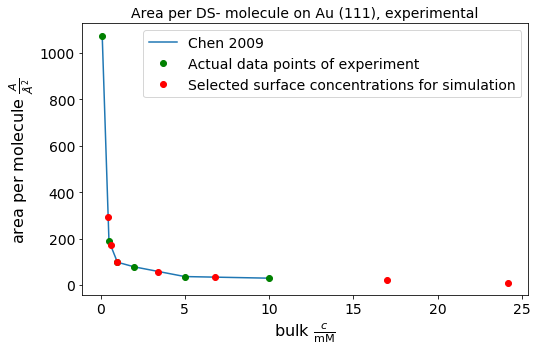

In [353]:
rows = 1
cols = 1

fig = plt.figure(figsize=(8*cols, 5*rows))

pos = subplotPosition(cols=cols,rows=rows)

p = next(pos)
_, ax = addSubplot(exp_sklt_unpublished_fig1_data[["c"]] / C.milli,
                   exp_sklt_unpublished_fig1_data[["A"]] / C.angstrom**2,
                   title = "Area per DS- molecule on Au (111), experimental", 
                   xlabel = r'bulk $\frac{c}{\mathrm{mM}}$', 
                   ylabel = r'area per molecule $\frac{A}{\AA^2}$',
                   legend = "Chen 2009", fig = fig, pos = p)
_, _ = addSubplot( exp_sklt_unpublished_fig1_data[["c"]] / C.milli,
                   exp_sklt_unpublished_fig1_data[["A"]] / C.angstrom**2,
                   legend = "Actual data points of experiment",
                   fmtstr='go', fig = fig, pos = p, ax = ax)
_, _ = addSubplot( 
    exp_sklt_unpublished_fig1_bulk_concentration_from_molecular_area( 
        sim_SDS_on_AU_111_molecular_surface_areas_of_interest) / C.milli,
        sim_SDS_on_AU_111_molecular_surface_areas_of_interest / C.angstrom**2,
                   legend = "Selected surface concentrations for simulation",
                   fmtstr='ro', fig = fig, pos = p, ax = ax)

In [354]:
exp_sklt_unpublished_fig1_bulk_concentration_from_molecular_area_for_poster_plot = \
    scipy.interpolate.interp1d(
        exp_sklt_unpublished_fig1_data["A"],
        exp_sklt_unpublished_fig1_data["c"], 
        axis=0, kind='linear', bounds_error=False,
        fill_value="extrapolate")

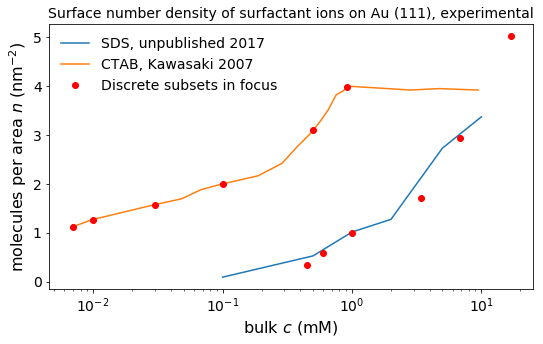

In [355]:
rows = 1
cols = 1

fig = plt.figure(figsize=(8*cols, 5*rows))

pos = subplotPosition(cols=cols,rows=rows)

p = next(pos)
_, ax = addSubplot(exp_sklt_unpublished_fig1_data[["c"]] / C.milli,
                   exp_sklt_unpublished_fig1_data[["GammaN"]] * C.nano**2,
                   title = "Surface number density of surfactant ions on Au (111), experimental", 
                   xlabel = r'bulk $c \ (\mathrm{mM})$', 
                   ylabel = r'molecules per area $n \ (\mathrm{nm}^{-2})$',
                   legend = "SDS, unpublished 2017", fig = fig, pos = p)
_, _ = addSubplot( 
    exp_sklt_unpublished_fig1_bulk_concentration_from_molecular_area_for_poster_plot(
        sim_SDS_on_AU_111_molecular_surface_areas_of_interest ) [1:] / C.milli,     
    1.0 / sim_SDS_on_AU_111_molecular_surface_areas_of_interest[1:] * C.nano**2,
            fmtstr='ro', fig = fig, pos = p, ax = ax )

_, _ = addSubplot( 
    exp_kawasaki2007influence_fig1b_data[["c"]] / C.milli,
    exp_kawasaki2007influence_fig1b_data[["GammaN"]] * C.nano**2,
    legend = "CTAB, Kawasaki 2007", fig = fig, pos = p, ax = ax )

_, _ = addSubplot( 
    sim_CTAB_on_AU_111_bulk_concentrations_of_interest / C.milli,
    1.0 / sim_CTAB_on_AU_111_area_per_monolayer_molecule * C.nano**2,
    fmtstr='ro', fig = fig, pos = p, ax = ax,
    legend = "Discrete subsets in focus")

ax.legend(frameon=False)
ax.set_xscale("log")
fig.tight_layout()

In [356]:
minor_x_ticks = np.log10( ax.get_xticks(minor=True) )

In [357]:
minor_x_ticks

array([-3.69897   , -3.52287875, -3.39794001, -3.30103   , -3.22184875,
       -3.15490196, -3.09691001, -3.04575749, -2.69897   , -2.52287875,
       -2.39794001, -2.30103   , -2.22184875, -2.15490196, -2.09691001,
       -2.04575749, -1.69897   , -1.52287875, -1.39794001, -1.30103   ,
       -1.22184875, -1.15490196, -1.09691001, -1.04575749, -0.69897   ,
       -0.52287875, -0.39794001, -0.30103   , -0.22184875, -0.15490196,
       -0.09691001, -0.04575749,  0.30103   ,  0.47712125,  0.60205999,
        0.69897   ,  0.77815125,  0.84509804,  0.90308999,  0.95424251,
        1.30103   ,  1.47712125,  1.60205999,  1.69897   ,  1.77815125,
        1.84509804,  1.90308999,  1.95424251,  2.30103   ,  2.47712125,
        2.60205999,  2.69897   ,  2.77815125,  2.84509804,  2.90308999,
        2.95424251,  3.30103   ,  3.47712125,  3.60205999,  3.69897   ,
        3.77815125,  3.84509804,  3.90308999,  3.95424251])

In [358]:
major_x_ticks = np.log10( ax.get_xticks() )

In [359]:
major_x_ticks

array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.])

In [360]:
exp_sklt_unpublished_fig1_bulk_log_concentration_from_molecular_area = \
    scipy.interpolate.interp1d(
        exp_sklt_unpublished_fig1_data["A"],
        np.log10( exp_sklt_unpublished_fig1_data["c"] / C.milli), 
        axis=0, kind='slinear', bounds_error=False,
        fill_value="extrapolate")

In [361]:
wanted_minor_x_ticks = minor_x_ticks[ (minor_x_ticks > -3.0) & (minor_x_ticks < 2.0) ]

In [362]:
wanted_major_x_ticks = major_x_ticks[ (major_x_ticks >= -2.0) & (major_x_ticks <= 1.9) ]

In [363]:
x_ticks_labels = [ '$10^{{{:.0f}}}$'.format(xval) for xval in wanted_major_x_ticks ]

In [364]:
x_ticks_labels

['$10^{-2}$', '$10^{-1}$', '$10^{0}$', '$10^{1}$']

In [365]:
import matplotlib as mpl
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial']
mpl.rcParams['font.serif'] = ['Arial']
mpl.rcParams['font.cursive'] = ['Arial']
mpl.rcParams['font.size'] = '10'
mpl.rcParams['legend.fontsize'] = '10'
mpl.rcParams['xtick.labelsize'] = '8'
mpl.rcParams['ytick.labelsize'] = '8'
mpl.rcParams['svg.fonttype'] = 'none'

In [366]:
# matplotlib settings

# expecially for presentation, larger font settings for plotting are recommendable
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 26

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure titlex

plt.rcParams["figure.figsize"] = (16,10) # the standard figure size

In [367]:
plt.rcParams["lines.linewidth"] = 4

In [368]:
plt.rcParams["lines.markersize"] = 14

/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


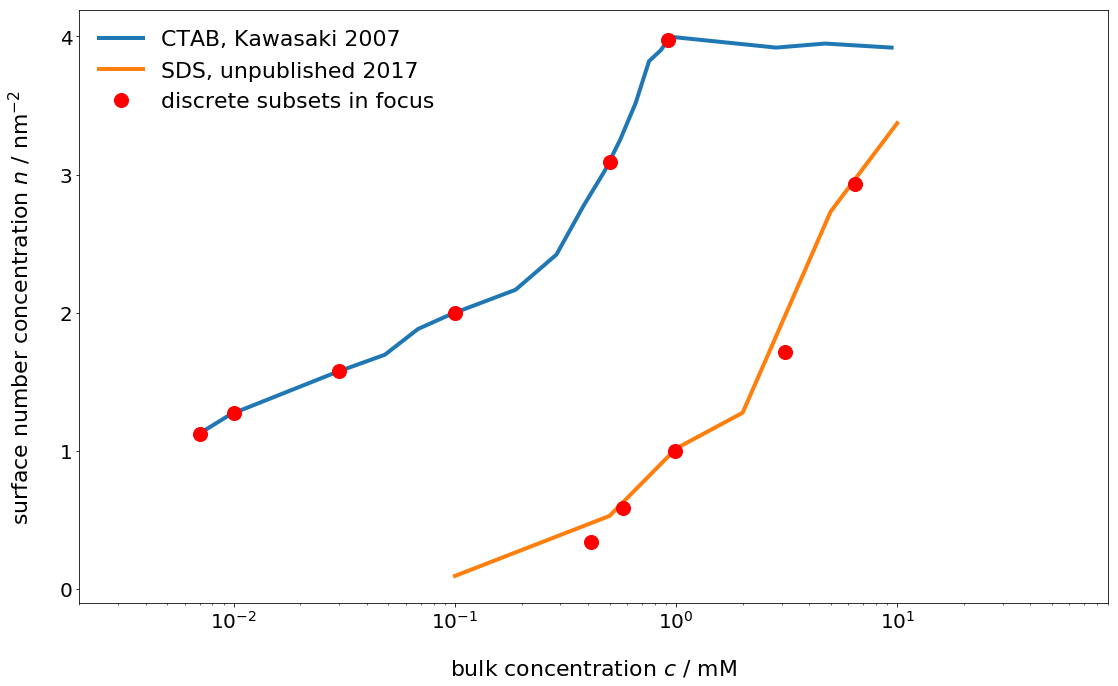

In [369]:
rows = 1
cols = 1

fig = plt.figure(figsize=(16*cols, 10*rows))

pos = subplotPosition(cols=cols,rows=rows)

p = next(pos)
_, ax = addSubplot( np.log10( exp_kawasaki2007influence_fig1b_data[["c"]] / C.milli ),
                   exp_kawasaki2007influence_fig1b_data[["GammaN"]] * C.nano**2,
                   legend = "CTAB, Kawasaki 2007", fig = fig, pos = p)
_, _ = addSubplot( np.log10( sim_CTAB_on_AU_111_bulk_concentrations_of_interest / C.milli ),
                    1.0 / sim_CTAB_on_AU_111_area_per_monolayer_molecule * C.nano**2,
                    fmtstr='ro', fig = fig, pos = p, ax = ax )
_, _ = addSubplot(
    np.log10( exp_sklt_unpublished_fig1_data[["c"]] / C.milli ),
            exp_sklt_unpublished_fig1_data[["GammaN"]] * C.nano**2,
            #title = "Surface number density of surfactant ions on Au (111), experimental", 
            legend = "SDS, unpublished 2017", fig = fig, pos = p, ax = ax ) 
_, _ = addSubplot( 
    exp_sklt_unpublished_fig1_bulk_log_concentration_from_molecular_area(
        sim_SDS_on_AU_111_molecular_surface_areas_of_interest )[2:],     
    1.0 / sim_SDS_on_AU_111_molecular_surface_areas_of_interest[2:] * C.nano**2,
            fmtstr='ro', fig = fig, pos = p, ax = ax,
            legend = "discrete subsets in focus")


ax.legend(frameon=False, loc='upper left')
ax.set_yticks(np.arange(0,5,dtype=int))
ax.set_xticks(wanted_minor_x_ticks, minor=True)
ax.set_xticks(wanted_major_x_ticks, minor=False)
ax.set_xticklabels(x_ticks_labels)
# ax.set_xscale("log")
ax.set_xlabel(r'bulk concentration $ c \ / \ \mathrm{mM}$', labelpad=BIGGER_SIZE)
ax.set_ylabel(r'surface number concentration $ n \ / \ {\mathrm{nm}^{-2}}$',labelpad=BIGGER_SIZE)
fig.tight_layout()


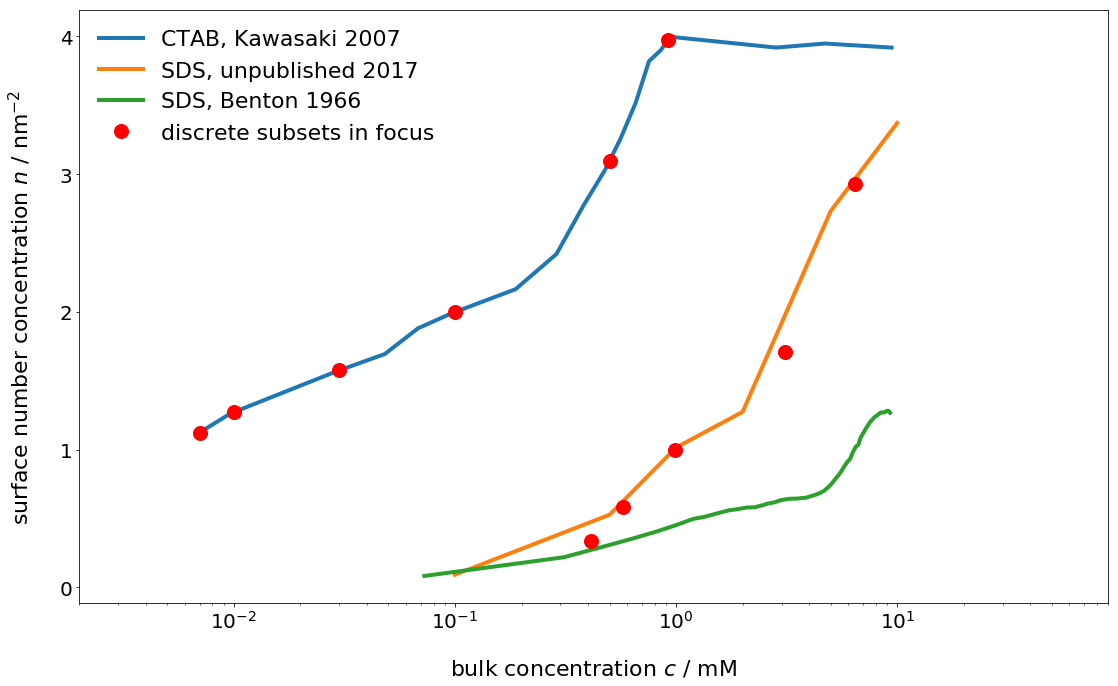

In [370]:
# with Benton 1966
rows = 1
cols = 1

fig = plt.figure(figsize=(16*cols, 10*rows))

pos = subplotPosition(cols=cols,rows=rows)

p = next(pos)
_, ax = addSubplot( np.log10( exp_kawasaki2007influence_fig1b_data[["c"]] / C.milli ),
                   exp_kawasaki2007influence_fig1b_data[["GammaN"]] * C.nano**2,
                   legend = "CTAB, Kawasaki 2007", fig = fig, pos = p)
_, _ = addSubplot( np.log10( sim_CTAB_on_AU_111_bulk_concentrations_of_interest / C.milli ),
                    1.0 / sim_CTAB_on_AU_111_area_per_monolayer_molecule * C.nano**2,
                    fmtstr='ro', fig = fig, pos = p, ax = ax )
_, _ = addSubplot(
    np.log10( exp_sklt_unpublished_fig1_data[["c"]] / C.milli ),
            exp_sklt_unpublished_fig1_data[["GammaN"]] * C.nano**2,
            #title = "Surface number density of surfactant ions on Au (111), experimental", 
            legend = "SDS, unpublished 2017", fig = fig, pos = p, ax = ax ) 
_, _ = addSubplot(
    np.log10( exp_benton1966_fig1_sds_fit_data[["c"]] / C.milli ),
            exp_benton1966_fig1_sds_fit_data[["GammaN"]] * C.nano**2,
            legend = "SDS, Benton 1966", fig = fig, pos = p, ax = ax ) 
_, _ = addSubplot( 
    exp_sklt_unpublished_fig1_bulk_log_concentration_from_molecular_area(
        sim_SDS_on_AU_111_molecular_surface_areas_of_interest )[2:],     
    1.0 / sim_SDS_on_AU_111_molecular_surface_areas_of_interest[2:] * C.nano**2,
            fmtstr='ro', fig = fig, pos = p, ax = ax,
            legend = "discrete subsets in focus")


ax.legend(frameon=False, loc='upper left')
ax.set_yticks(np.arange(0,5,dtype=int))
ax.set_xticks(wanted_minor_x_ticks, minor=True)
ax.set_xticks(wanted_major_x_ticks, minor=False)
ax.set_xticklabels(x_ticks_labels)
# ax.set_xscale("log")
ax.set_xlabel(r'bulk concentration $ c \ / \ \mathrm{mM}$', labelpad=BIGGER_SIZE)
ax.set_ylabel(r'surface number concentration $ n \ / \ {\mathrm{nm}^{-2}}$',labelpad=BIGGER_SIZE)
fig.tight_layout()


In [371]:
#os.getcwd()

In [372]:
#os.mkdir('fig')

In [373]:
#fig.savefig('fig/20180927_concentrations_in_focus.png')

In [374]:
wanted_minor_x_ticks = minor_x_ticks[ (minor_x_ticks > -3.0) & (minor_x_ticks <= 1.0) ]

In [375]:
wanted_major_x_ticks = major_x_ticks[ (major_x_ticks >= -2.0) & (major_x_ticks <= 1.9) ]

In [376]:
x_ticks_labels = [ '$10^{{{:.0f}}}$'.format(xval) for xval in wanted_major_x_ticks ]

In [377]:
x_ticks_labels

['$10^{-2}$', '$10^{-1}$', '$10^{0}$', '$10^{1}$']

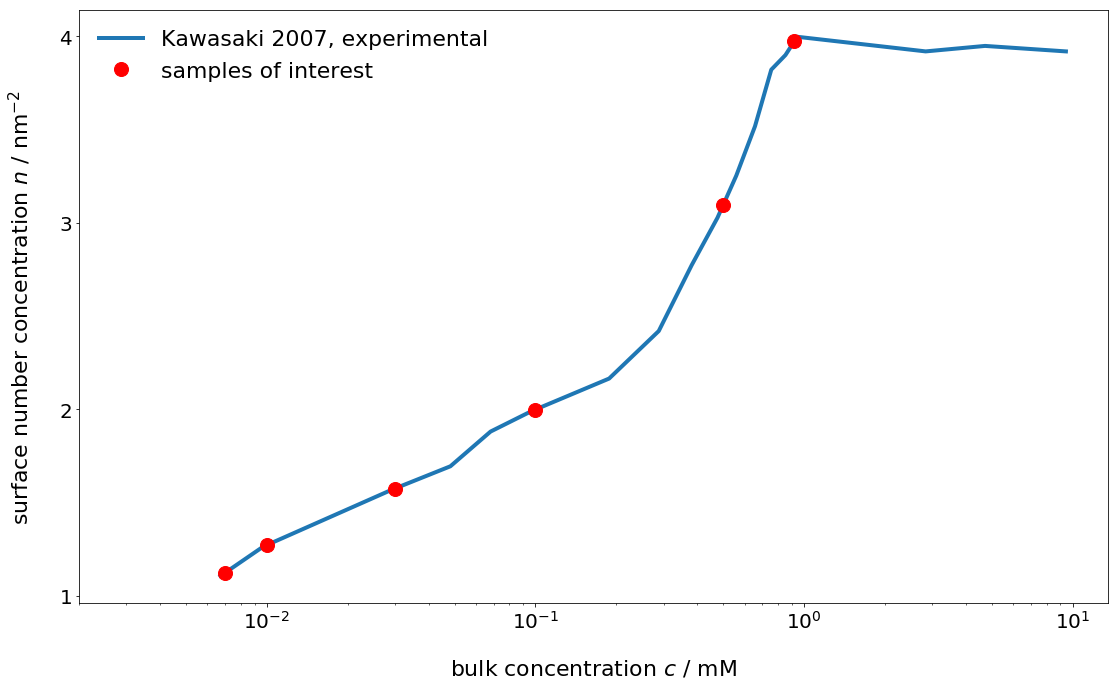

In [378]:
rows = 1
cols = 1

fig = plt.figure(figsize=(16*cols, 10*rows))

pos = subplotPosition(cols=cols,rows=rows)

p = next(pos)
_, ax = addSubplot( np.log10( exp_kawasaki2007influence_fig1b_data[["c"]] / C.milli ),
                   exp_kawasaki2007influence_fig1b_data[["GammaN"]] * C.nano**2,
                   legend = "Kawasaki 2007, experimental", fig = fig, pos = p)
_, _ = addSubplot( np.log10( sim_CTAB_on_AU_111_bulk_concentrations_of_interest / C.milli ),
                    1.0 / sim_CTAB_on_AU_111_area_per_monolayer_molecule * C.nano**2,
                    fmtstr='ro', fig = fig, pos = p, ax = ax,
                    legend = "samples of interest")
# _, _ = addSubplot(
#     np.log10( exp_sklt_unpublished_fig1_data[["c"]] / C.milli ),
#             exp_sklt_unpublished_fig1_data[["GammaN"]] * C.nano**2,
#             #title = "Surface number density of surfactant ions on Au (111), experimental", 
#             legend = "SDS, unpublished 2017", fig = fig, pos = p, ax = ax ) 
# _, _ = addSubplot( 
#     exp_sklt_unpublished_fig1_bulk_log_concentration_from_molecular_area(
#         sim_SDS_on_AU_111_molecular_surface_areas_of_interest )[2:],     
#     1.0 / sim_SDS_on_AU_111_molecular_surface_areas_of_interest[2:] * C.nano**2,
#             fmtstr='ro', fig = fig, pos = p, ax = ax,
#             legend = "discrete subsets in focus")


ax.legend(frameon=False, loc='upper left')
ax.set_yticks(np.arange(1,5,dtype=int))
ax.set_xticks(wanted_minor_x_ticks, minor=True)
ax.set_xticks(wanted_major_x_ticks, minor=False)
ax.set_xticklabels(x_ticks_labels)
# ax.set_xscale("log")
ax.set_xlabel(r'bulk concentration $ c \ / \ \mathrm{mM}$', labelpad=BIGGER_SIZE)
ax.set_ylabel(r'surface number concentration $ n \ / \ {\mathrm{nm}^{-2}}$',labelpad=BIGGER_SIZE)
fig.tight_layout()


In [379]:
#fig.savefig('fig/20180927_concentrations_in_focus_ctab_only_600dpi.png', dpi=600)

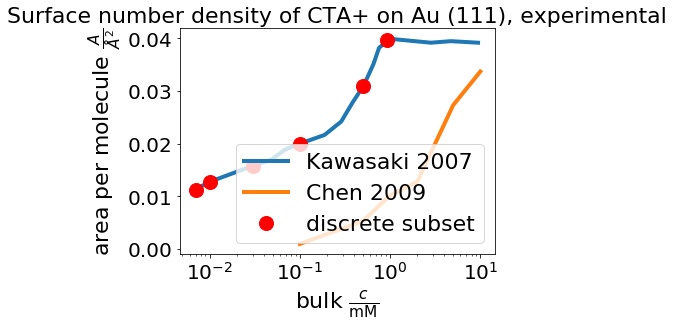

In [380]:
rows = 1
cols = 1

fig = plt.figure(figsize=(8*cols, 5*rows))

pos = subplotPosition(cols=cols,rows=rows)

p = next(pos)
fig, ax = addSubplot(
                   exp_kawasaki2007influence_fig1b_data[["c"]] / C.milli,
                   exp_kawasaki2007influence_fig1b_data[["GammaN"]] * C.angstrom**2,
                   title = "Surface number density of CTA+ on Au (111), experimental", 
                   xlabel = r'bulk $\frac{c}{\mathrm{mM}}$', 
                   ylabel = r'molecules per area $\frac{n}{\mathrm{nm}^{-2}}$',
                   legend = "Kawasaki 2007", fig = fig, pos = p)
# _, _ = addSubplot(exp_kawasaki2007influence_fig1b_data[["c"]] / C.milli,
#                   exp_kawasaki2007influence_fig1b_data[["GammaN"]] * C.nano**2,
#                   fmtstr='ro', fig = fig, pos = p, ax = ax)


_, _ = addSubplot( exp_sklt_unpublished_fig1_data[["c"]] / C.milli,
                   1/exp_sklt_unpublished_fig1_data[["A"]] * C.angstrom**2,
                   xlabel = r'bulk $\frac{c}{\mathrm{mM}}$', 
                   ylabel = r'area per molecule $\frac{A}{\AA^2}$',
                   legend = "Chen 2009", fig = fig, ax = ax )

ax.plot(
    sim_CTAB_on_AU_111_bulk_concentrations_of_interest / C.milli,
    1.0 / sim_CTAB_on_AU_111_area_per_monolayer_molecule * C.angstrom**2,'ro',
    label = 'discrete subset'
    )

ax.legend()
ax.set_xscale("log")

# p = next(pos)
# _, ax = addSubplot(exp_kawasaki2007influence_fig1b_data[["c"]] / C.milli,
#                   exp_kawasaki2007influence_fig1b_data[["A"]] / C.angstrom**2,
#                   title = "Area perc CTA+ molecule on Au (111), experimental", 
#                   xlabel = r'bulk $\frac{c}{\mathrm{mM}}$', 
#                   ylabel = r'area per molecule $\frac{A}{\AA^2}$',
#                   legend = "Kawasaki 2007", fig = fig, pos = p)
# _, _ = addSubplot(exp_kawasaki2007influence_fig1b_data[["c"]] / C.milli,
#                   exp_kawasaki2007influence_fig1b_data[["A"]] /C.angstrom**2,
#                    fmtstr='ro', fig = fig, pos = p, ax = ax)
# ax.set_xscale("log")

fig.tight_layout()

### Leeds-Lyon 2019

#### Isothems

In [30]:
from fireworks.utilities.filepad import FilePad

In [31]:
fp = FilePad.auto_load()

In [32]:
query = {"metadata.surfactant":"SDS"}

In [33]:
sorted(np.array(fp.filepad.find(query).distinct("metadata.sf_concentration"))/C.milli)

[0.0, 0.453, 0.6, 0.99, 3.4, 6.8, 6.80627, 17.0]

In [34]:
sds_sf_nmolecules = sorted(
    np.array(
        fp.filepad.find(query).distinct("metadata.sf_nmolecules")))

In [35]:
ctab_sf_nmolecules = sorted(
    np.array(
        fp.filepad.find(
            {"metadata.surfactant":"CTAB"}).distinct("metadata.sf_nmolecules")))

In [36]:
query = { 
    "metadata.surfactant": "SDS",
    "metadata.sf_nmolecules": {"$gt":0},
    "metadata.sf_concentration": {"$exists":True}, 
    "metadata.sf_concentration": {"$gt":0}
}

In [37]:
match_aggregation = {
        "$match": query
    }

In [38]:
# unique surfactant - nmolecules sets
group_aggregation = { 
    "$group": { 
        "_id": { 
            "sf_nmolecules": "$metadata.sf_nmolecules",
        },
        "sf_concentration": { 
            "$addToSet": "$metadata.sf_concentration",
            
        },
    } 
}

In [39]:
aggregation_pipeline = [ match_aggregation, group_aggregation ]

In [40]:
cursor = fp.filepad.aggregate(aggregation_pipeline)

In [41]:
parametric_sets = [ c for c in cursor ]

In [42]:
len(parametric_sets)

6

In [43]:
parametric_sets

[{'_id': {'sf_nmolecules': 129}, 'sf_concentration': [0.0006]},
 {'_id': {'sf_nmolecules': 646}, 'sf_concentration': [0.0068, 0.00680627]},
 {'_id': {'sf_nmolecules': 1107}, 'sf_concentration': [0.017]},
 {'_id': {'sf_nmolecules': 220}, 'sf_concentration': [0.00099]},
 {'_id': {'sf_nmolecules': 75}, 'sf_concentration': [0.000453]},
 {'_id': {'sf_nmolecules': 377}, 'sf_concentration': [0.0034]}]

In [44]:
sds_number_concentration_tuples = [ 
    (d["_id"]["sf_nmolecules"], d["sf_concentration"][0]) for d in parametric_sets ]

In [45]:
sorted(sds_number_concentration_tuples)

[(75, 0.000453),
 (129, 0.0006),
 (220, 0.00099),
 (377, 0.0034),
 (646, 0.0068),
 (1107, 0.017)]

In [46]:
sds_sf_nmolecules

[75, 129, 220, 377, 646, 1107]

In [47]:
ctab_sf_nmolecules

[367, 415, 515, 653, 1010, 1298]

In [48]:
qcm_results_raw = pd.read_csv(
    os.path.join(prefix,'ref/dat/sklt2019unpublished.csv'),
            delimiter=',',comment='#',header=None,names=["c","GammaM"])
# cE      : bulk concenctration / mM 
# GammaM : surface mass density / ng cm^-2
ctab_results_raw = pd.read_csv(
    os.path.join(prefix,'ref/dat/kawasaki2007influence_fig1b.csv'),
            delimiter=',',comment='#',header=None,names=["c","GammaM"])
# cE      : bulk concenctration / mM 
# GammaM : surface mass density / ng cm^-2

In [49]:
sds_GammaN_mM_to_GammaM_ng_per_cm_sq = C.centi**2 / (C.nano * C.gram * C.Avogadro) * M_DSm  / C.nano**2 # from mM to ng cm^-2

In [50]:
ctab_GammaN_mM_to_GammaM_ng_per_cm_sq = C.centi**2 / (C.nano * C.gram * C.Avogadro) * M_CTAp / C.nano**2 # from mM to ng cm^-2

In [51]:
qcm_results = pd.concat([    
    qcm_results_raw[["c"]]*C.milli, # mM --> M
    qcm_results_raw[["GammaM"]] * (C.nano * C.gram) / C.centi**2 # ng cm^-2 --> kg m^-2
    ], axis=1)
ctab_results = pd.concat([    
   ctab_results_raw[["c"]]*C.milli, # mM --> M
   ctab_results_raw[["GammaM"]] * (C.nano * C.gram) / C.centi**2 # ng cm^-2 --> kg m^-2
    ], axis=1)

In [52]:
# surface concentration, kg m^-2 * (mol/kg) = mol m^-2
qcm_results[["GammaC"]] = qcm_results[["GammaM"]] / M_DSm
ctab_results[["GammaC"]] = ctab_results[["GammaM"]] / M_CTAp

In [53]:
# surface number density, mol m^-2 * (mol^-1) = m^-2
qcm_results[["GammaN"]] = qcm_results[["GammaC"]] * C.Avogadro
ctab_results[["GammaN"]] =ctab_results[["GammaC"]] * C.Avogadro

In [54]:
# area per molecule, m^2
qcm_results[["A"]] = 1 / qcm_results[["GammaN"]]
ctab_results[["A"]] = 1 /ctab_results[["GammaN"]]

In [55]:
pkl_file = os.path.join(prefix,"dat","sys","SDS_on_AU_111.pkl")
sds_df = pd.read_pickle(pkl_file)
pkl_file2 = os.path.join(prefix,"dat","sys","CTAB_on_AU_111.pkl")
ctab_df = pd.read_pickle(pkl_file2)

In [56]:
sds_surface_number_concentration= np.array((
    1 / sds_df.loc[:]["sb_area_per_sf_molecule"].drop_duplicates() * C.nano**2 ).sort_values())
ctab_surface_number_concentration= np.array((
    1 / ctab_df.loc[:]["sb_area_per_sf_molecule"].drop_duplicates() *C.nano**2 ).sort_values())

In [57]:
ctab_surface_number_concentration

array([1.12285676, 1.27124102, 1.57553167, 1.99857802, 3.09310476,
       3.97332048])

In [58]:
sds_surface_number_concentration

array([ 0.3408759 ,  0.58378979,  0.99980821,  1.71228836,  2.93249382,
        5.02223822, 10.04447645])

In [59]:
stored_sds_bulk_concentration = np.array(
    sds_df.loc[:]["sf_concentration"].sort_values().drop_duplicates() / C.milli )
stored_ctab_bulk_concentration= np.array(
    ctab_df.loc[:]["sf_concentration"].sort_values().drop_duplicates() / C.milli )

In [60]:
stored_sds_bulk_concentration

array([ 0.45309097,  0.60007789,  0.99143787,  3.43718593,  6.80627418,
       17.00698635, 24.16420746])

In [61]:
stored_ctab_bulk_concentration

array([0.007, 0.01 , 0.03 , 0.1  , 0.5  , 0.92 ])

In [62]:
sds_surface_concentration_interpolation_function = scipy.interpolate.interp1d(
    np.array(qcm_results[["c"]] / C.milli).reshape(len(np.array(qcm_results[["c"]] ))), 
    np.array(qcm_results[["GammaN"]] * C.nano**2).reshape(len(qcm_results[["GammaN"]])),
    axis=0, kind='linear', bounds_error=False,
    fill_value="extrapolate")
ctab_surface_concentration_interpolation_function =scipy.interpolate.interp1d(
    np.array(ctab_results[["c"]] / C.milli).reshape(len(np.array(ctab_results[["c"]] ))), 
    np.array(ctab_results[["GammaN"]] * C.nano**2).reshape(len(ctab_results[["GammaN"]])),
    axis=0, kind='linear', bounds_error=False,
    fill_value="extrapolate")
# inverse of the above:
sds_bulk_concentration_interpolation_function =scipy.interpolate.interp1d( 
    np.array(qcm_results[["GammaN"]] * C.nano**2).reshape(len(qcm_results[["GammaN"]])),
    np.array(qcm_results[["c"]] / C.milli).reshape(len(np.array(qcm_results[["c"]] ))),
    axis=0, kind='linear', bounds_error=False,
    fill_value="extrapolate")

In [63]:
sds_sf_nmolecules

[75, 129, 220, 377, 646, 1107]

In [64]:
sds_surface_number_concentration

array([ 0.3408759 ,  0.58378979,  0.99980821,  1.71228836,  2.93249382,
        5.02223822, 10.04447645])

In [65]:
sds_bulk_concentration_interpolation_function( sds_surface_number_concentration )

array([ 2.40234014e-01,  3.45809150e-01,  8.27330817e-01,  1.17099962e+00,
        2.67119633e+00, -1.09833061e+03, -5.87819691e+03])

In [66]:
sorted(sds_number_concentration_tuples)

[(75, 0.000453),
 (129, 0.0006),
 (220, 0.00099),
 (377, 0.0034),
 (646, 0.0068),
 (1107, 0.017)]

In [67]:
# override surface number concentrations
sds_surface_number_concentration = np.array(
    [ n/(15**2) for n,c in sorted(sds_number_concentration_tuples)] )

In [68]:
sds_surface_number_concentration

array([0.33333333, 0.57333333, 0.97777778, 1.67555556, 2.87111111,
       4.92      ])

In [69]:
sds_bulk_concentration_interpolation_function(sds_surface_number_concentration)

array([ 2.36540468e-01,  3.41846077e-01,  8.15747581e-01,  1.15366527e+00,
        1.98033144e+00, -1.00102637e+03])

In [70]:
sds_bulk_concentration = sds_bulk_concentration_interpolation_function( sds_surface_number_concentration )

In [71]:
sds_bulk_concentration

array([ 2.36540468e-01,  3.41846077e-01,  8.15747581e-01,  1.15366527e+00,
        1.98033144e+00, -1.00102637e+03])

In [72]:
# manually modify last value
plt_sds_bulk_concentration = sds_bulk_concentration.copy()
plt_sds_bulk_concentration[-1] = 10

In [73]:
plt_qcm_results = qcm_results[1:]

In [74]:
# matplotlib settings

# expecially for presentation, larger font settings for plotting are recommendable
TINY_SIZE=12
SMALLER_SIZE = 16
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 26

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure titlex

plt.rc('lines', linewidth=3)          # controls default text sizes
plt.rc('lines', markersize=TINY_SIZE)          # controls default text sizes

plt.rcParams["figure.figsize"] = (16,10) # the standard figure size

In [75]:
sds_color = 'tab:blue'
ctab_color = 'tab:orange'
ylim = (-0.4,5.4)

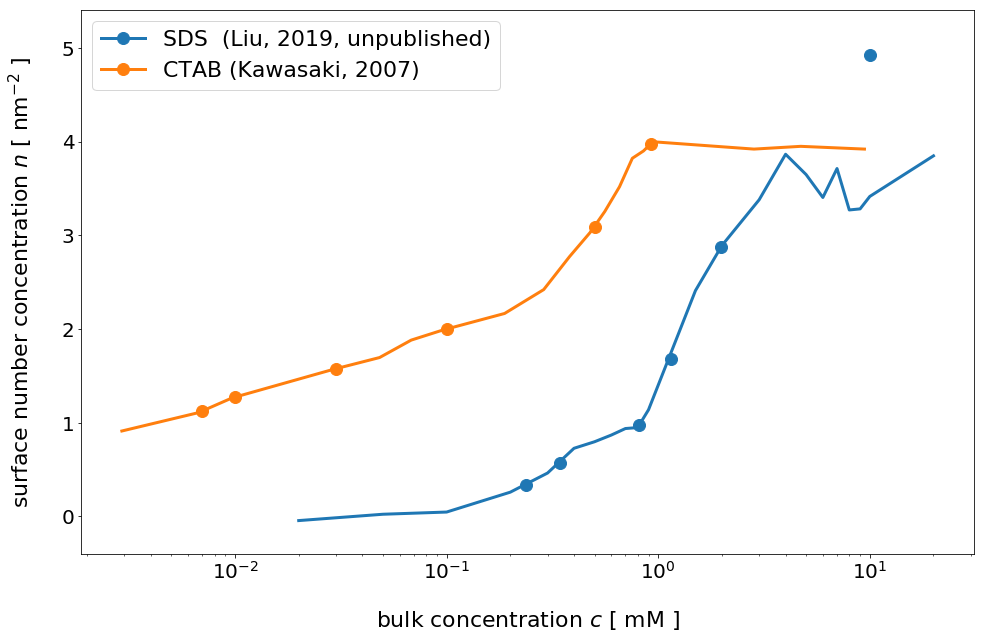

In [76]:
fig, ax = plt.subplots() 
plt.plot( 
    plt_qcm_results[["c"]] / C.milli ,plt_qcm_results[["GammaN"]] * C.nano**2,
    color = sds_color )
plt.plot( 
    ctab_results[["c"]] / C.milli ,ctab_results[["GammaN"]] * C.nano**2,
    color = ctab_color )

# stored sds concentrations require "remapping"
plt.plot(
    plt_sds_bulk_concentration,
    sds_surface_number_concentration,
    'o', color=sds_color)
#plt.plot(bm[0:len(interpolated_sf)],interpolated_sf,'go')
# stored ctab concentrations are fine
plt.plot( stored_ctab_bulk_concentration, ctab_surface_number_concentration, 
         'o', color=ctab_color)

#plt.plot(bm2[0:len(interpolated_sf_2)],interpolated_sf_2,'go')
plt.xscale("log")

legend_elements = [
    Line2D([0], [0], 
        marker='o', color='tab:blue', label="SDS  (Liu, 2019, unpublished)"),
    Line2D([0], [0], 
        marker='o', color='tab:orange', label="CTAB (Kawasaki, 2007)") ]

plt.legend(handles=legend_elements)

plt.xlabel(r'bulk concentration $c$ [ $\mathrm{mM}$ ]', labelpad=BIGGER_SIZE)
plt.ylabel(r'surface number concentration $n$ [ ${\mathrm{nm}^{-2}}$ ]', 
           labelpad=BIGGER_SIZE)
plt.ylim(ylim)
plt.show()

fig.tight_layout()

In [77]:
minor_x_ticks = np.log10( ax.get_xticks(minor=True) )

In [78]:
minor_x_ticks

array([-3.69897   , -3.52287875, -3.39794001, -3.30103   , -3.22184875,
       -3.15490196, -3.09691001, -3.04575749, -2.69897   , -2.52287875,
       -2.39794001, -2.30103   , -2.22184875, -2.15490196, -2.09691001,
       -2.04575749, -1.69897   , -1.52287875, -1.39794001, -1.30103   ,
       -1.22184875, -1.15490196, -1.09691001, -1.04575749, -0.69897   ,
       -0.52287875, -0.39794001, -0.30103   , -0.22184875, -0.15490196,
       -0.09691001, -0.04575749,  0.30103   ,  0.47712125,  0.60205999,
        0.69897   ,  0.77815125,  0.84509804,  0.90308999,  0.95424251,
        1.30103   ,  1.47712125,  1.60205999,  1.69897   ,  1.77815125,
        1.84509804,  1.90308999,  1.95424251,  2.30103   ,  2.47712125,
        2.60205999,  2.69897   ,  2.77815125,  2.84509804,  2.90308999,
        2.95424251,  3.30103   ,  3.47712125,  3.60205999,  3.69897   ,
        3.77815125,  3.84509804,  3.90308999,  3.95424251])

In [79]:
major_x_ticks = np.log10( ax.get_xticks() )

In [80]:
major_x_ticks

array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.])

In [81]:
wanted_minor_x_ticks = minor_x_ticks[ (minor_x_ticks > -3.0) & (minor_x_ticks <= 1.0) ]

In [82]:
wanted_major_x_ticks = major_x_ticks[ (major_x_ticks >= -2.0) & (major_x_ticks <= 1.9) ]

In [83]:
x_ticks_labels = [ '$10^{{{:.0f}}}$'.format(xval) for xval in wanted_major_x_ticks ]

In [84]:
x_ticks_labels

['$10^{-2}$', '$10^{-1}$', '$10^{0}$', '$10^{1}$']

#### Isotherms with multiple scales

In [85]:
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import matplotlib.pyplot as plt

In [86]:
sds_color = 'tab:blue'
ctab_color = 'tab:orange'
xlim = (-2.9, 1.7)
ylim = (-0.4,5.4)

In [100]:
custom_dpi=300

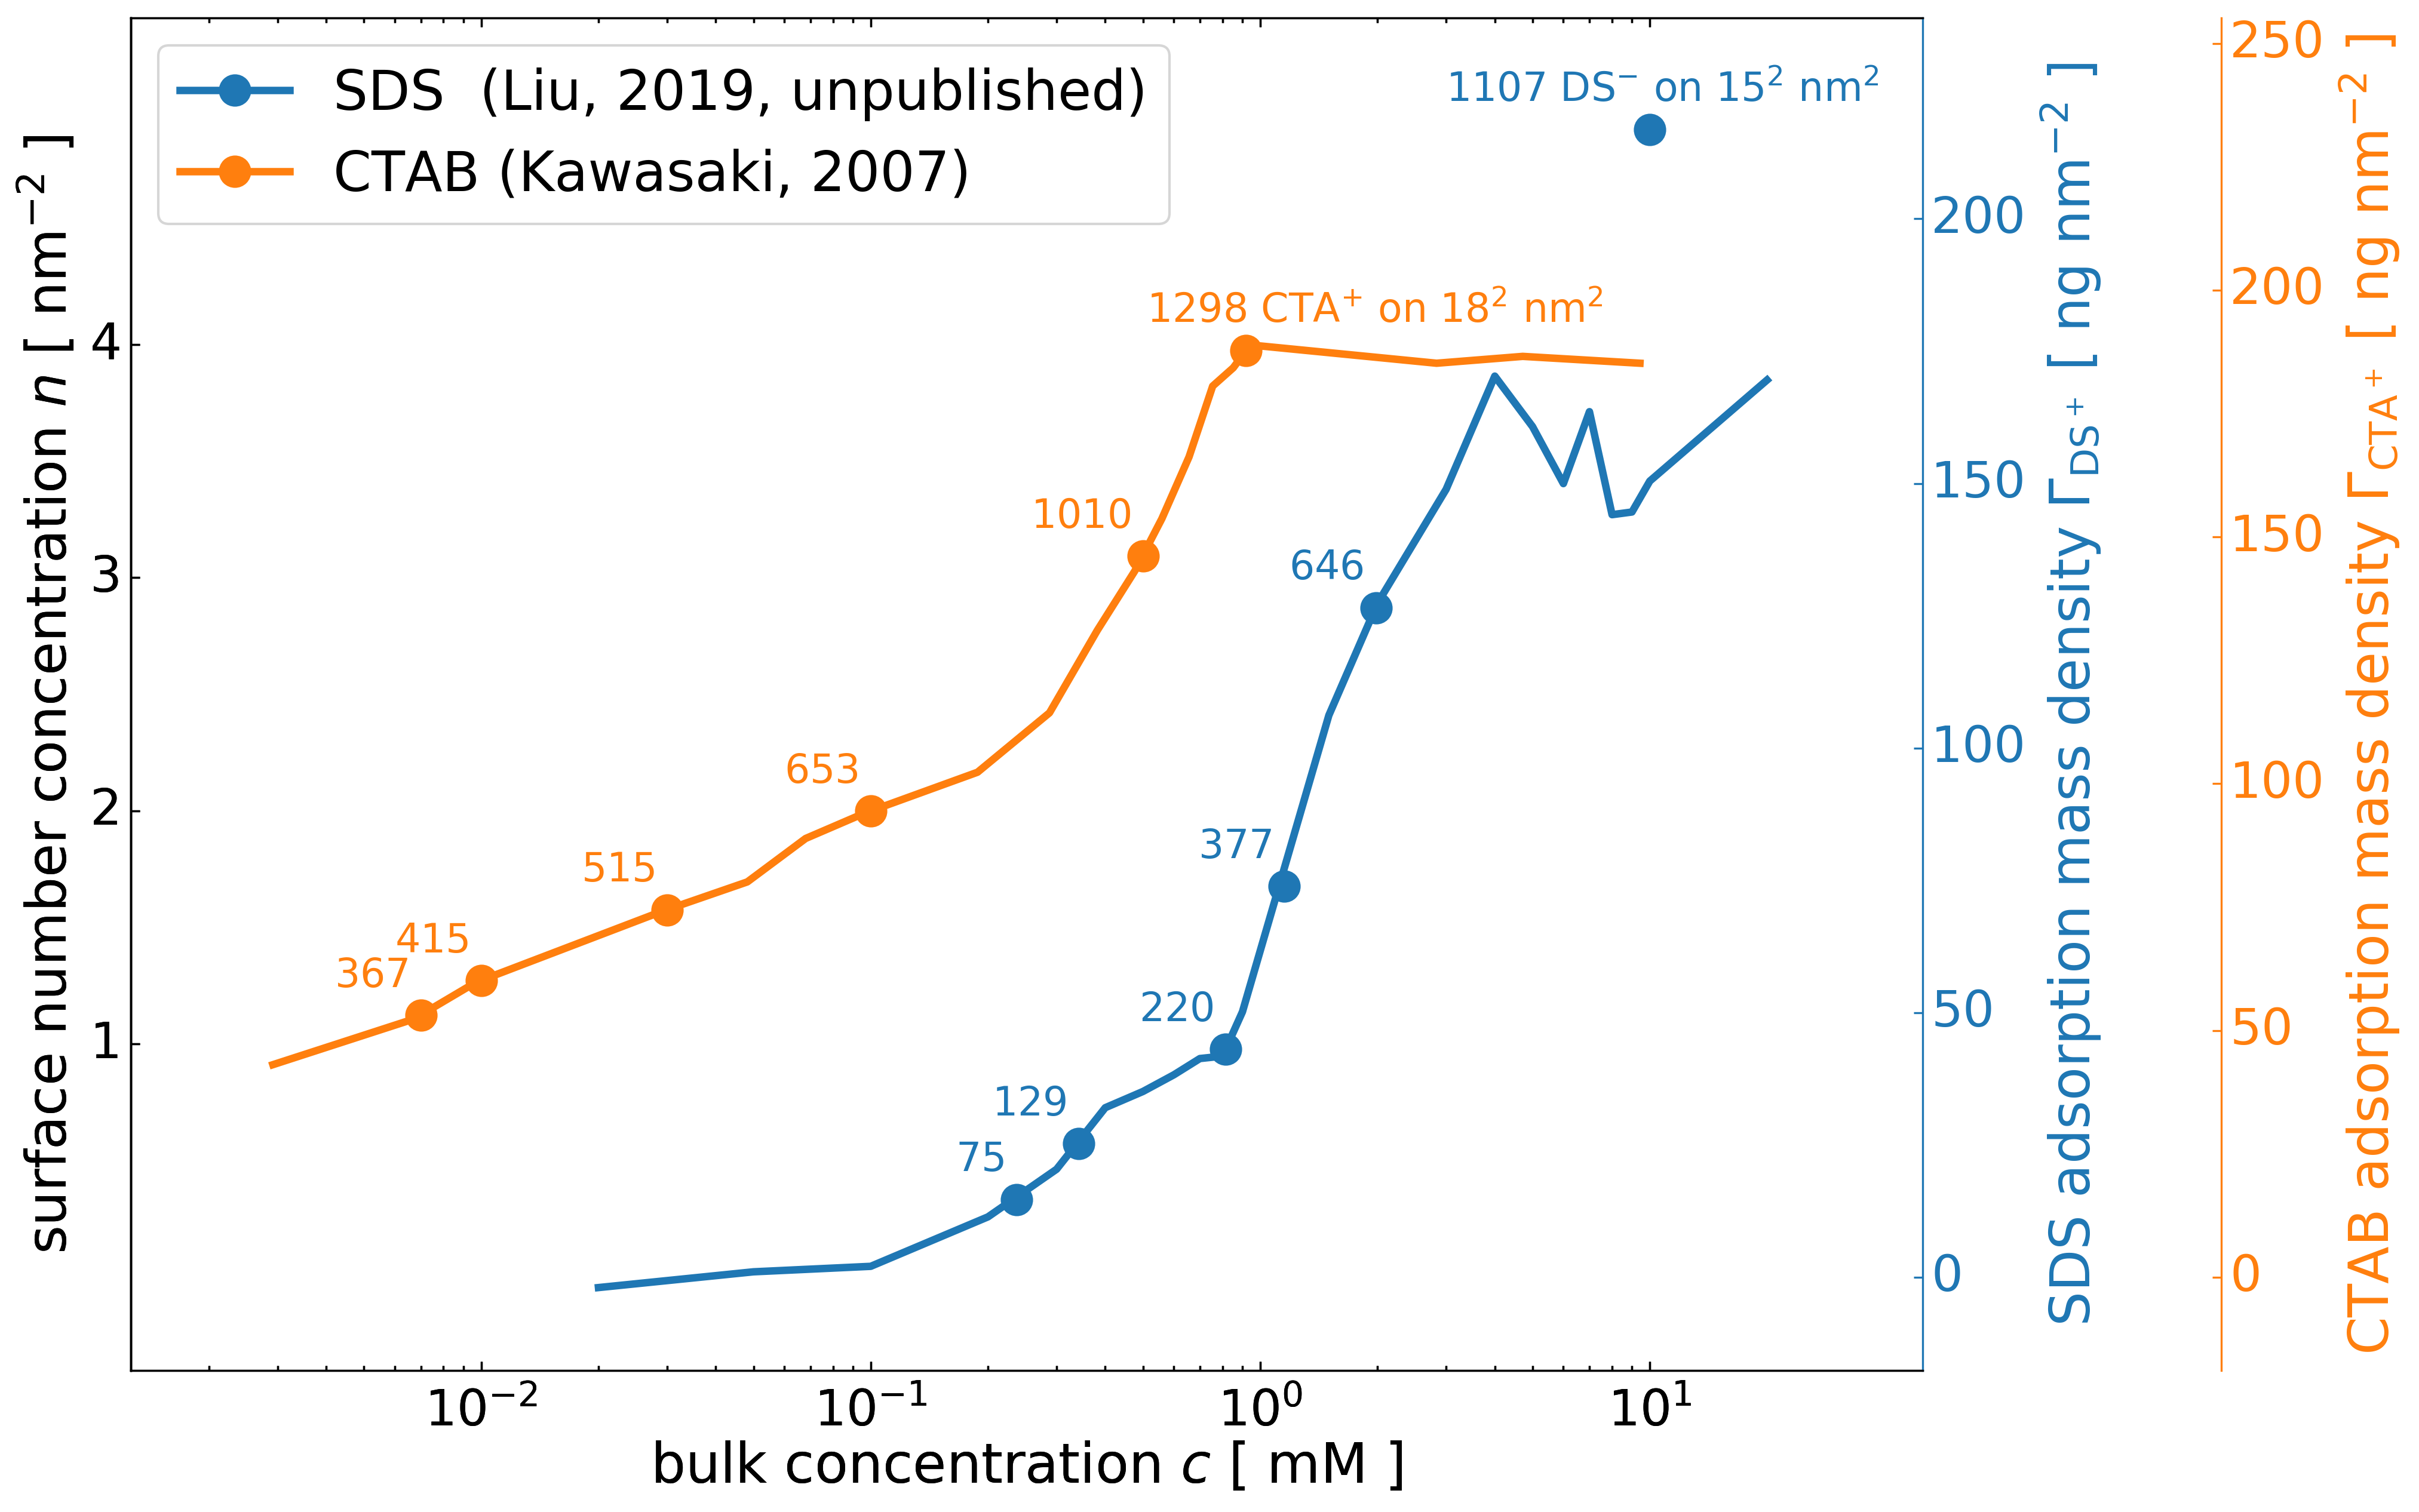

In [97]:
# https://matplotlib.org/examples/axes_grid/demo_parasite_axes2.html
fig = plt.figure(dpi=custom_dpi)
#fig.xscale("log")

host = host_subplot(111, axes_class=AA.Axes, figure=fig)

plt.subplots_adjust(right=0.75)

p1, = host.plot( 
    np.log10( plt_qcm_results[["c"]] / C.milli ),
    plt_qcm_results[["GammaN"]] * C.nano**2,
    color = sds_color )
p2, = host.plot( 
    np.log10( ctab_results[["c"]] / C.milli ),
    ctab_results[["GammaN"]] * C.nano**2,
    color = ctab_color )

# stored sds concentrations require "remapping"
s1 = host.plot(
    np.log10( plt_sds_bulk_concentration ),
    sds_surface_number_concentration,
    'o', color=p1.get_color())

# stored ctab concentrations are fine
s2 = host.plot( 
    np.log10( stored_ctab_bulk_concentration ), 
    ctab_surface_number_concentration, 
    'o', color=p2.get_color())
    
for i, lab in enumerate(sds_sf_nmolecules):
    host.annotate( 
        "${}$ $\mathrm{{DS}}^{{-}}$ on $15^2 \ \mathrm{{nm}}^2$".format(lab) if i+1 == len(sds_sf_nmolecules) else "${}$".format(lab), 
        xy=( np.log10( plt_sds_bulk_concentration[i] ),
             sds_surface_number_concentration[i] ), 
        xycoords='data',
        xytext=(5, 8) if i+1 == len(sds_sf_nmolecules) else (-5, 8), 
        textcoords='offset points',
        horizontalalignment='center' if i+1 == len(sds_sf_nmolecules) else 'right', 
        verticalalignment='bottom',
        fontsize=SMALLER_SIZE, color = p1.get_color())
    
for i, lab in enumerate(list(ctab_sf_nmolecules)):
    host.annotate( 
        "${}$ $\mathrm{{CTA}}^{{+}}$ on $18^2 \ \mathrm{{nm}}^2$".format(lab) if i+1 == len(ctab_sf_nmolecules) else "${}$".format(lab), 
        xy=( np.log10( stored_ctab_bulk_concentration[i] ),
             ctab_surface_number_concentration[i] ), 
        xycoords='data',
        xytext=(-40, 8) if i+1 == len(ctab_sf_nmolecules) else (-5, 8), 
        textcoords='offset points',
        horizontalalignment='left' if i+1 == len(ctab_sf_nmolecules) else 'right', 
        verticalalignment='bottom',
        fontsize=SMALLER_SIZE, color = p2.get_color())

legend_elements = [
    Line2D([0], [0], 
        marker='o', color='tab:blue', label="SDS  (Liu, 2019, unpublished)"),
    Line2D([0], [0], 
        marker='o', color='tab:orange', label="CTAB (Kawasaki, 2007)") ]

host.legend(handles=legend_elements)

par1 = host.twinx()
par2 = host.twinx()

#par1.axis["right"] = par1.get_grid_helper().new_fixed_axis(loc="right",
#                                    axes=par1,
#                                    offset=(0, 0))

offset = 120
par2.axis["right"] = par2.get_grid_helper().new_fixed_axis(loc="right",
                                    axes=par2,
                                    offset=(offset, 0))

par1.axis["right"].toggle(all=True)
par2.axis["right"].toggle(all=True)

host.set_xlim(xlim[0],xlim[1])
host.set_ylim(ylim[0],ylim[1])
par1.set_ylim( ylim[0]*sds_GammaN_mM_to_GammaM_ng_per_cm_sq,
               ylim[1]*sds_GammaN_mM_to_GammaM_ng_per_cm_sq)
par2.set_ylim( ylim[0]*ctab_GammaN_mM_to_GammaM_ng_per_cm_sq,
               ylim[1]*ctab_GammaN_mM_to_GammaM_ng_per_cm_sq)

host.set_xlabel(r'bulk concentration $c$ [ $\mathrm{mM}$ ]', labelpad=BIGGER_SIZE)
host.set_ylabel(r'surface number concentration $n$ [ ${\mathrm{nm}^{-2}}$ ]', 
           labelpad=BIGGER_SIZE)

par1.set_ylabel(r'SDS adsorption mass density $\Gamma_{\mathrm{DS^+}}$ [ $\mathrm{ng}\ \mathrm{nm}^{-2}$ ]', 
           labelpad=BIGGER_SIZE, color=p1.get_color())

par2.set_ylabel(r'CTAB adsorption mass density $\Gamma_{\mathrm{CTA^+}}$ [ $\mathrm{ng}\ \mathrm{nm}^{-2}$ ]', 
           labelpad=BIGGER_SIZE, color=p2.get_color())

host.set_yticks(np.arange(1,5,dtype=int))
host.set_xticks(wanted_minor_x_ticks, minor=True)
host.set_xticks(wanted_major_x_ticks, minor=False)
host.set_xticklabels(x_ticks_labels)

#for ax in [par2]:
par1.axis["right"].label.set_color(p1.get_color())
par2.axis["right"].label.set_color(p2.get_color())
#par1.axis["right"].spines['right'].set_color(p1.get_color())
#par2.axis["right"].spines['right'].set_color(p2.get_color())

par1.tick_params(axis='y', colors=p1.get_color(), labelcolor=p1.get_color())
par2.tick_params(axis='y', colors=p2.get_color(), labelcolor=p2.get_color())


host.spines["right"].set_edgecolor(p1.get_color())
par1.spines["right"].set_edgecolor(p1.get_color())
par2.spines["right"].set_edgecolor(p2.get_color())

par1.set_frame_on(True)
par1.patch.set_visible(False)

plt.setp(par1.spines.values(), visible=False)
par1.spines["left"].set_visible(True)

par2.set_frame_on(True)
par2.patch.set_visible(False)

plt.setp(par2.spines.values(), visible=False)
par2.spines["left"].set_visible(True)

#host.axis["right"].line.set_color(p1.get_color())
par1.axis["right"].line.set_color(p1.get_color())
par1.axis["right"].major_ticks.set_color(p1.get_color())
par1.axis["right"].major_ticklabels.set_color(p1.get_color())

par2.axis["right"].line.set_color(p2.get_color())
par2.axis["right"].major_ticks.set_color(p2.get_color())
par2.axis["right"].major_ticklabels.set_color(p2.get_color())

plt.draw()
plt.show()
fig.tight_layout()

fig.savefig("isotherms_multiple_scales_{}dpi.png".format(custom_dpi), dpi=custom_dpi)

#### Isotherm, CTAB only

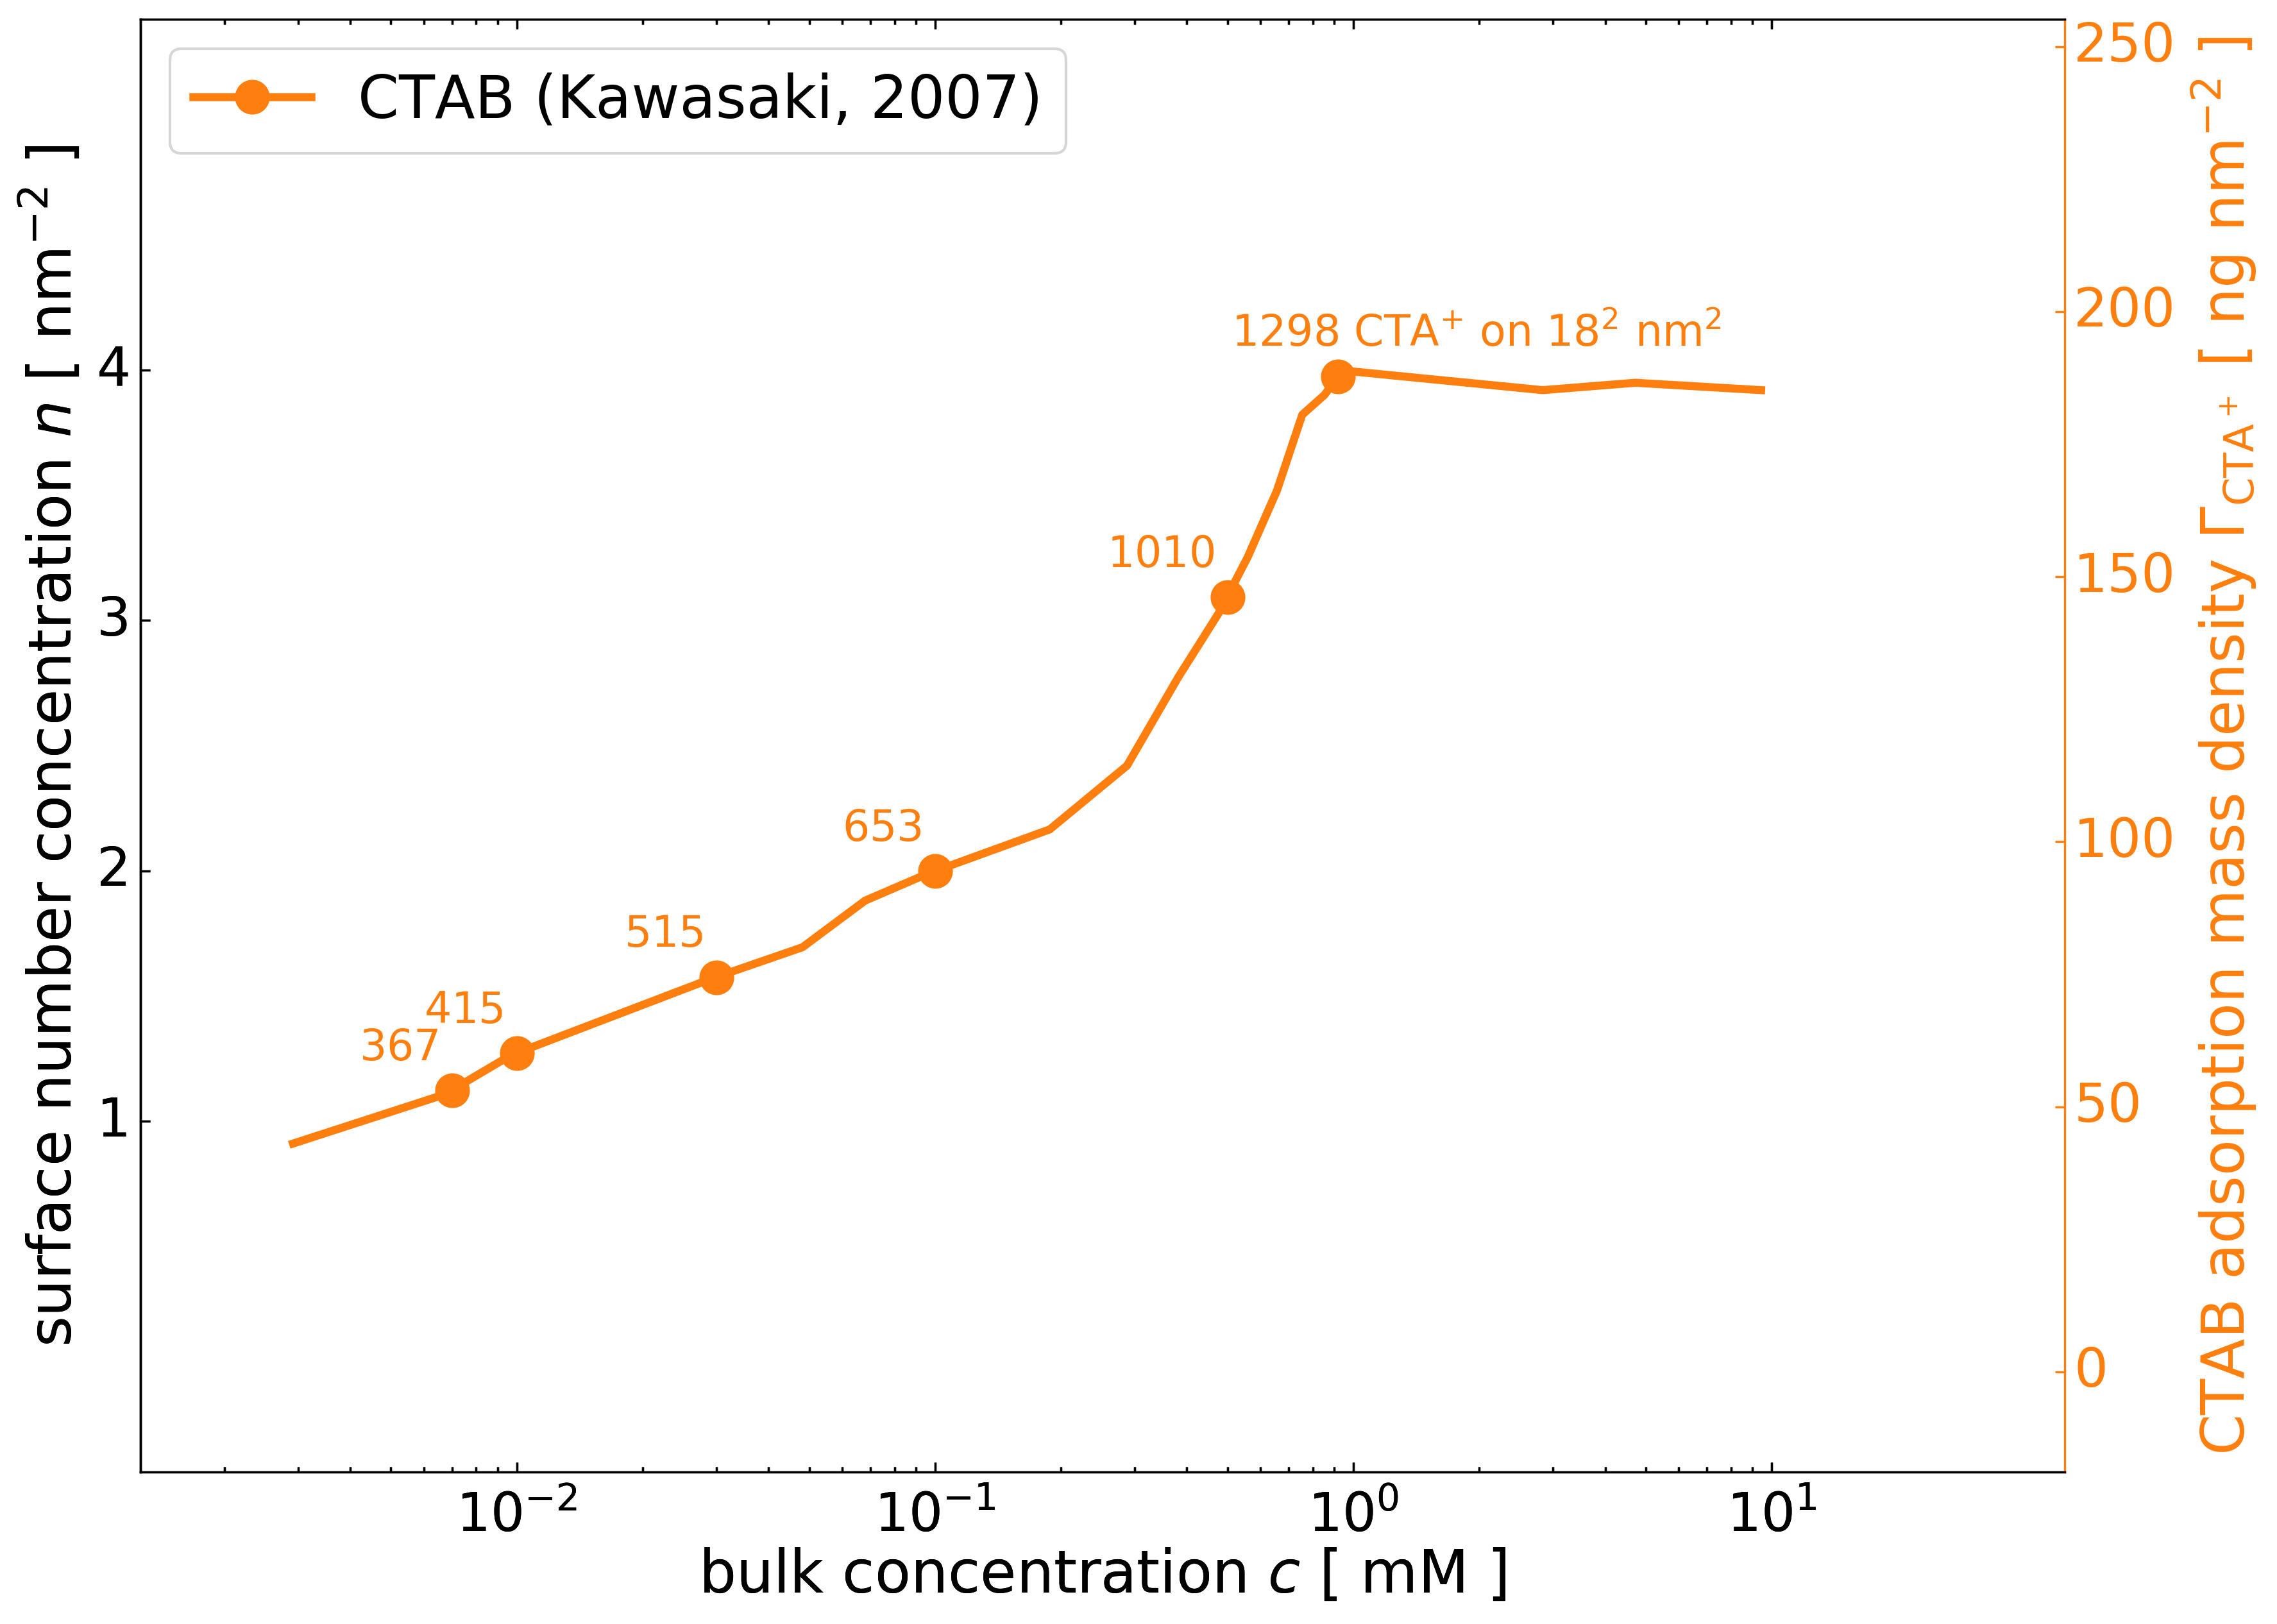

In [101]:
# https://matplotlib.org/examples/axes_grid/demo_parasite_axes2.html
fig = plt.figure(dpi=custom_dpi)
#fig.xscale("log")

host = host_subplot(111, axes_class=AA.Axes, figure=fig)

plt.subplots_adjust(right=0.75)

p2, = host.plot( 
    np.log10( ctab_results[["c"]] / C.milli ),
    ctab_results[["GammaN"]] * C.nano**2,
    color = ctab_color )

# stored ctab concentrations are fine
s2 = host.plot( 
    np.log10( stored_ctab_bulk_concentration ), 
    ctab_surface_number_concentration, 
    'o', color=p2.get_color())
        
for i, lab in enumerate(list(ctab_sf_nmolecules)):
    host.annotate( 
        "${}$ $\mathrm{{CTA}}^{{+}}$ on $18^2 \ \mathrm{{nm}}^2$".format(lab) if i+1 == len(ctab_sf_nmolecules) else "${}$".format(lab), 
        xy=( np.log10( stored_ctab_bulk_concentration[i] ),
             ctab_surface_number_concentration[i] ), 
        xycoords='data',
        xytext=(-40, 8) if i+1 == len(ctab_sf_nmolecules) else (-5, 8), 
        textcoords='offset points',
        horizontalalignment='left' if i+1 == len(ctab_sf_nmolecules) else 'right', 
        verticalalignment='bottom',
        fontsize=SMALLER_SIZE, color = p2.get_color())

legend_elements = [
    Line2D([0], [0], 
        marker='o', color='tab:orange', label="CTAB (Kawasaki, 2007)") ]

host.legend(handles=legend_elements, loc="upper left")

par1 = host.twinx()

par1.axis["right"].toggle(all=True)

host.set_xlim(xlim[0],xlim[1])
host.set_ylim(ylim[0],ylim[1])
par1.set_ylim( ylim[0]*ctab_GammaN_mM_to_GammaM_ng_per_cm_sq,
               ylim[1]*ctab_GammaN_mM_to_GammaM_ng_per_cm_sq)

host.set_xlabel(r'bulk concentration $c$ [ $\mathrm{mM}$ ]', labelpad=BIGGER_SIZE)
host.set_ylabel(r'surface number concentration $n$ [ ${\mathrm{nm}^{-2}}$ ]', 
           labelpad=BIGGER_SIZE)

par1.set_ylabel(r'CTAB adsorption mass density $\Gamma_{\mathrm{CTA^+}}$ [ $\mathrm{ng}\ \mathrm{nm}^{-2}$ ]', 
           labelpad=BIGGER_SIZE, color=p2.get_color())

host.set_yticks(np.arange(1,5,dtype=int))
host.set_xticks(wanted_minor_x_ticks, minor=True)
host.set_xticks(wanted_major_x_ticks, minor=False)
host.set_xticklabels(x_ticks_labels)

#for ax in [par2]:
par1.axis["right"].label.set_color(p2.get_color())

par1.tick_params(axis='y', colors=p2.get_color(), labelcolor=p2.get_color())

host.spines["right"].set_edgecolor(p1.get_color())
par1.spines["right"].set_edgecolor(p2.get_color())

par1.set_frame_on(True)
par1.patch.set_visible(False)

plt.setp(par1.spines.values(), visible=False)
par1.spines["left"].set_visible(True)

par1.axis["right"].line.set_color(p2.get_color())
par1.axis["right"].major_ticks.set_color(p2.get_color())
par1.axis["right"].major_ticklabels.set_color(p2.get_color())

plt.draw()
plt.show()
fig.tight_layout()

fig.savefig("isotherm_CTAB_{}dpi.png".format(custom_dpi), dpi=custom_dpi)

#### Isotherm, SDS only

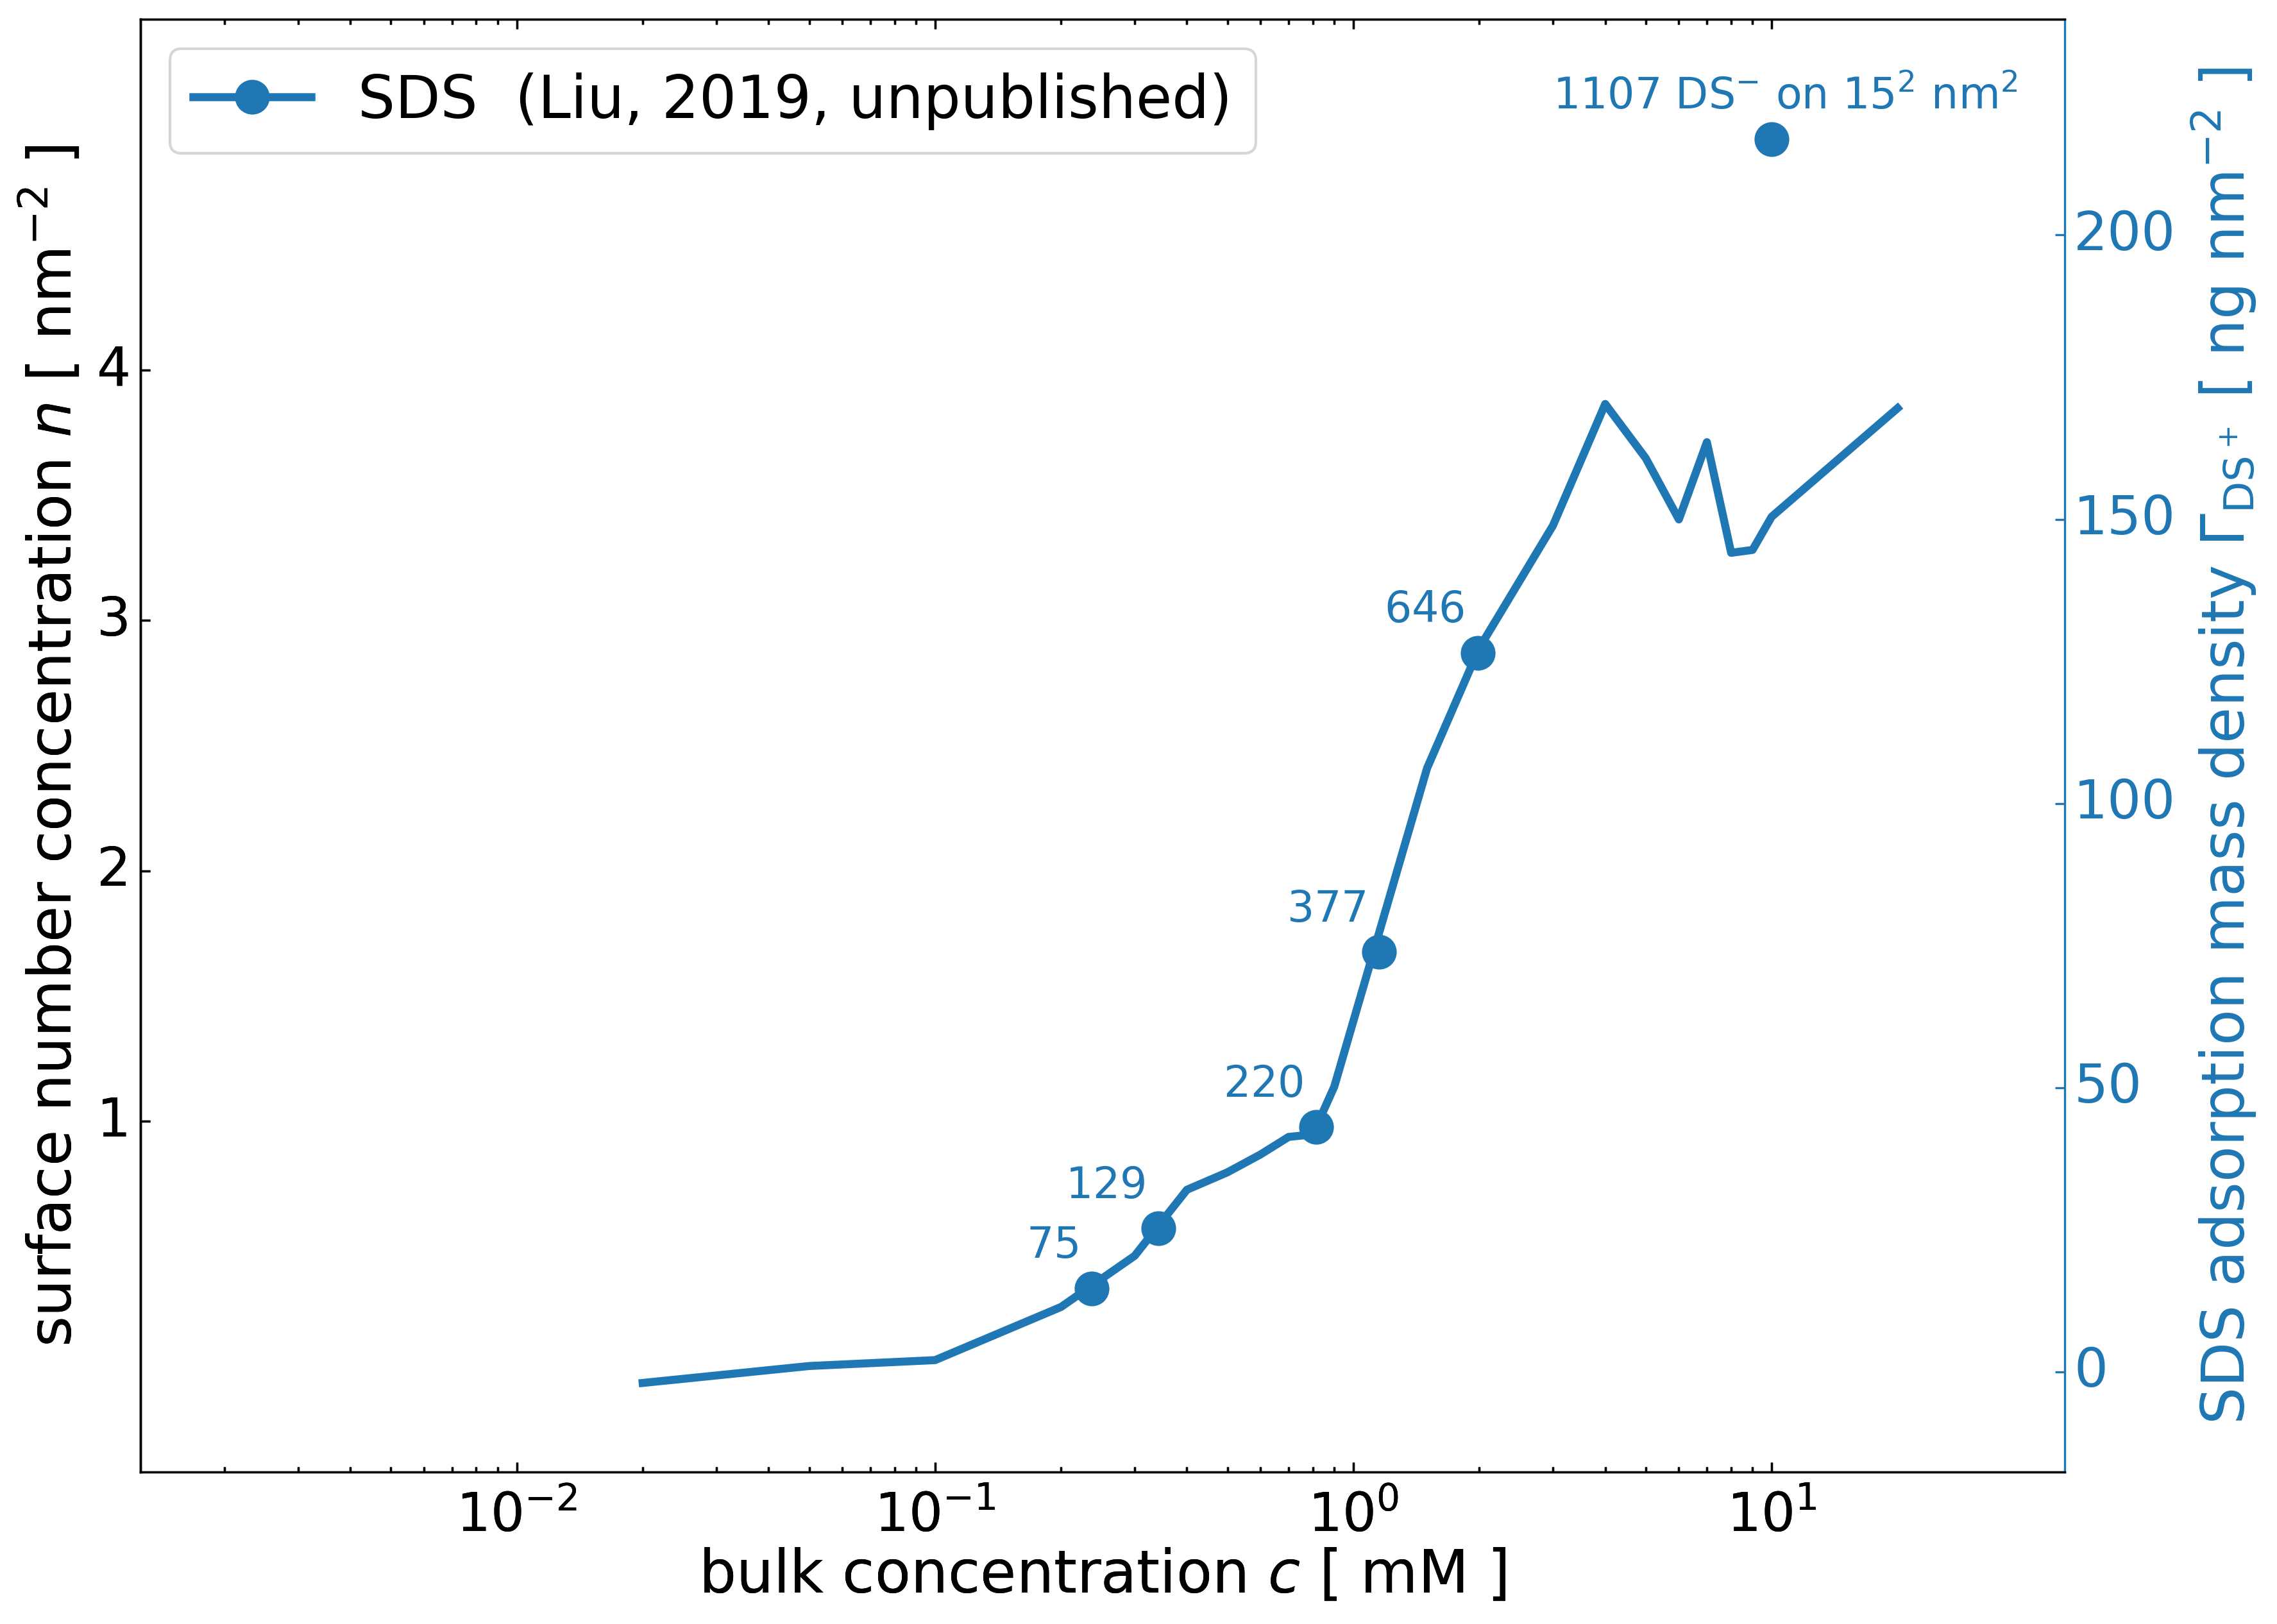

In [105]:
# https://matplotlib.org/examples/axes_grid/demo_parasite_axes2.html
fig = plt.figure(dpi=custom_dpi)
#fig.xscale("log")

host = host_subplot(111, axes_class=AA.Axes, figure=fig)

plt.subplots_adjust(right=0.75)

p1, = host.plot( 
    np.log10( plt_qcm_results[["c"]] / C.milli ),
    plt_qcm_results[["GammaN"]] * C.nano**2,
    color = sds_color )


# stored sds concentrations require "remapping"
s1 = host.plot(
    np.log10( plt_sds_bulk_concentration ),
    sds_surface_number_concentration,
    'o', color=p1.get_color())

    
for i, lab in enumerate(sds_sf_nmolecules):
    host.annotate( 
        "${}$ $\mathrm{{DS}}^{{-}}$ on $15^2 \ \mathrm{{nm}}^2$".format(lab) if i+1 == len(sds_sf_nmolecules) else "${}$".format(lab), 
        xy=( np.log10( plt_sds_bulk_concentration[i] ),
             sds_surface_number_concentration[i] ), 
        xycoords='data',
        xytext=(5, 8) if i+1 == len(sds_sf_nmolecules) else (-5, 8), 
        textcoords='offset points',
        horizontalalignment='center' if i+1 == len(sds_sf_nmolecules) else 'right', 
        verticalalignment='bottom',
        fontsize=SMALLER_SIZE, color = p1.get_color())

legend_elements = [
    Line2D([0], [0], 
        marker='o', color='tab:blue', label="SDS  (Liu, 2019, unpublished)") ]

host.legend(handles=legend_elements, loc="upper left")

par1 = host.twinx()


par1.axis["right"].toggle(all=True)

host.set_xlim(xlim[0],xlim[1])
host.set_ylim(ylim[0],ylim[1])
par1.set_ylim( ylim[0]*sds_GammaN_mM_to_GammaM_ng_per_cm_sq,
               ylim[1]*sds_GammaN_mM_to_GammaM_ng_per_cm_sq)

host.set_xlabel(r'bulk concentration $c$ [ $\mathrm{mM}$ ]', labelpad=BIGGER_SIZE)
host.set_ylabel(r'surface number concentration $n$ [ ${\mathrm{nm}^{-2}}$ ]', 
           labelpad=BIGGER_SIZE)

par1.set_ylabel(r'SDS adsorption mass density $\Gamma_{\mathrm{DS^+}}$ [ $\mathrm{ng}\ \mathrm{nm}^{-2}$ ]', 
           labelpad=BIGGER_SIZE, color=p1.get_color())

host.set_yticks(np.arange(1,5,dtype=int))
host.set_xticks(wanted_minor_x_ticks, minor=True)
host.set_xticks(wanted_major_x_ticks, minor=False)
host.set_xticklabels(x_ticks_labels)

par1.axis["right"].label.set_color(p1.get_color())


par1.tick_params(axis='y', colors=p1.get_color(), labelcolor=p1.get_color())

host.spines["right"].set_edgecolor(p1.get_color())
par1.spines["right"].set_edgecolor(p1.get_color())

par1.set_frame_on(True)
par1.patch.set_visible(False)

plt.setp(par1.spines.values(), visible=False)
par1.spines["left"].set_visible(True)

#host.axis["right"].line.set_color(p1.get_color())
par1.axis["right"].line.set_color(p1.get_color())
par1.axis["right"].major_ticks.set_color(p1.get_color())
par1.axis["right"].major_ticklabels.set_color(p1.get_color())

plt.draw()
plt.show()
fig.tight_layout()

fig.savefig("isotherm_SDS_{}dpi.png".format(custom_dpi), dpi=custom_dpi)

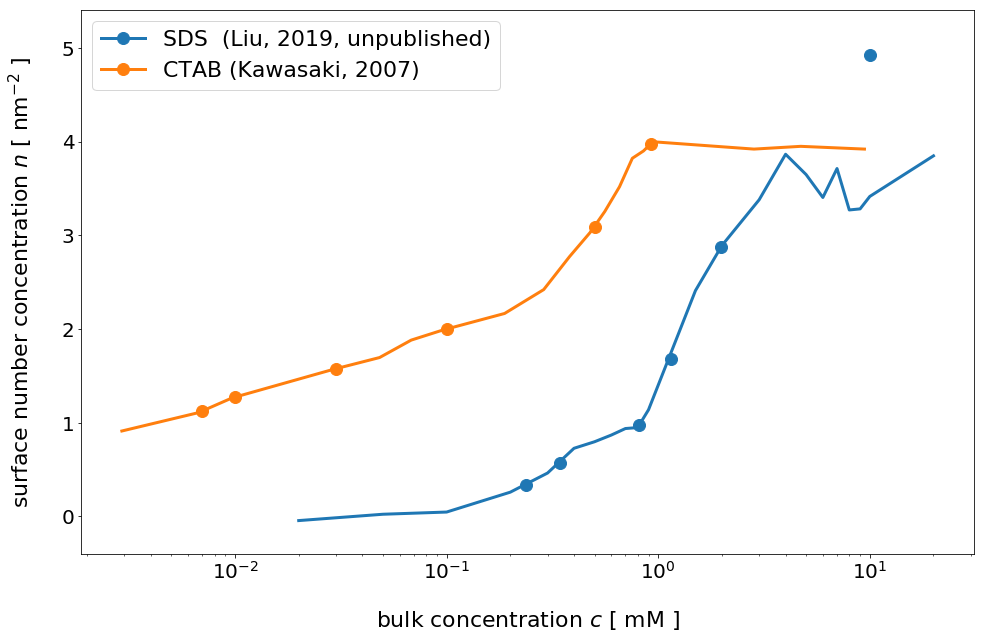

In [461]:
fig, ax = plt.subplots() 
plt.plot( 
    plt_qcm_results[["c"]] / C.milli ,plt_qcm_results[["GammaN"]] * C.nano**2,
    color = sds_color )
plt.plot( 
    ctab_results[["c"]] / C.milli ,ctab_results[["GammaN"]] * C.nano**2,
    color = ctab_color )

# stored sds concentrations require "remapping"
plt.plot(
    plt_sds_bulk_concentration,
    sds_surface_number_concentration,
    'o', color=sds_color)
#plt.plot(bm[0:len(interpolated_sf)],interpolated_sf,'go')
# stored ctab concentrations are fine
plt.plot( stored_ctab_bulk_concentration, ctab_surface_number_concentration, 
         'o', color=ctab_color)

#plt.plot(bm2[0:len(interpolated_sf_2)],interpolated_sf_2,'go')
plt.xscale("log")

legend_elements = [
    Line2D([0], [0], 
        marker='o', color='tab:blue', label="SDS  (Liu, 2019, unpublished)"),
    Line2D([0], [0], 
        marker='o', color='tab:orange', label="CTAB (Kawasaki, 2007)") ]

plt.legend(handles=legend_elements)

plt.xlabel(r'bulk concentration $c$ [ $\mathrm{mM}$ ]', labelpad=BIGGER_SIZE)
plt.ylabel(r'surface number concentration $n$ [ ${\mathrm{nm}^{-2}}$ ]', 
           labelpad=BIGGER_SIZE)
plt.ylim(ylim)
plt.show()

fig.tight_layout()

In [472]:
plt_qcm_results_raw = qcm_results_raw[1:]

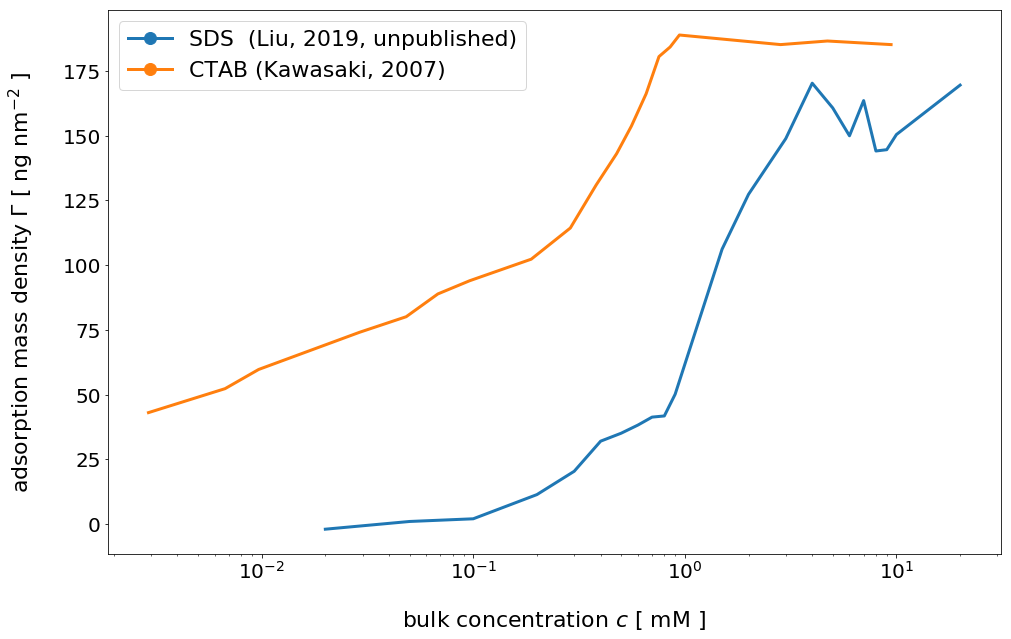

In [476]:
fig, ax = plt.subplots() 
plt.plot( 
    plt_qcm_results[["c"]] / C.milli , plt_qcm_results_raw[["GammaM"]] ,
    color = sds_color )
plt.plot( 
    ctab_results[["c"]] / C.milli ,ctab_results_raw[["GammaM"]] ,
    color = ctab_color )

# stored sds concentrations require "remapping"
#plt.plot(
#    plt_sds_bulk_concentration,
#    sds_surface_number_concentration,
#    'o', color=sds_color)
#plt.plot(bm[0:len(interpolated_sf)],interpolated_sf,'go')
# stored ctab concentrations are fine
#plt.plot( stored_ctab_bulk_concentration, ctab_surface_number_concentration, 
#         'o', color=ctab_color)

#plt.plot(bm2[0:len(interpolated_sf_2)],interpolated_sf_2,'go')
plt.xscale("log")

legend_elements = [
    Line2D([0], [0], 
        marker='o', color='tab:blue', label="SDS  (Liu, 2019, unpublished)"),
    Line2D([0], [0], 
        marker='o', color='tab:orange', label="CTAB (Kawasaki, 2007)") ]

plt.legend(handles=legend_elements)

plt.xlabel(r'bulk concentration $c$ [ $\mathrm{mM}$ ]', labelpad=BIGGER_SIZE)
plt.ylabel(r'adsorption mass density $\Gamma$ [ $\mathrm{ng}\ \mathrm{nm}^{-2}$ ]', 
           labelpad=BIGGER_SIZE)
#plt.ylim(ylim)
plt.show()

fig.tight_layout()

In [462]:
fig.savefig("isotherms_900dpi.png", dpi=900)

#### Isotherms, with molecule number labels

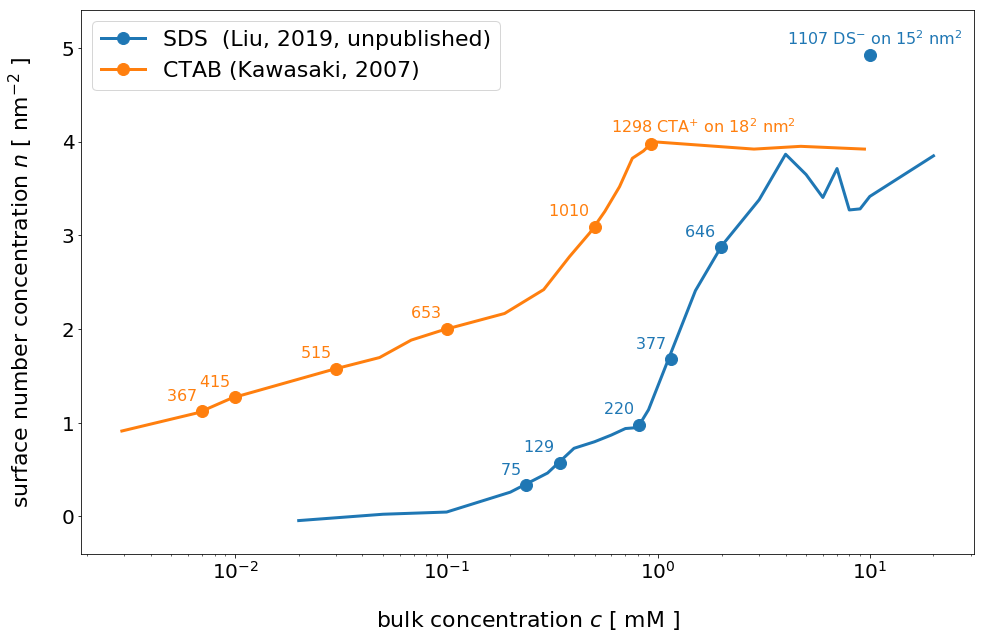

In [523]:
fig, ax = plt.subplots() 
plt.plot( 
    plt_qcm_results[["c"]] / C.milli ,plt_qcm_results[["GammaN"]] * C.nano**2,
    color = sds_color )
plt.plot( 
    ctab_results[["c"]] / C.milli ,ctab_results[["GammaN"]] * C.nano**2,
    color = ctab_color )

# stored sds concentrations require "remapping"
plt.plot(
    plt_sds_bulk_concentration,
    sds_surface_number_concentration,
    'o', color=sds_color)
#plt.plot(bm[0:len(interpolated_sf)],interpolated_sf,'go')
# stored ctab concentrations are fine
plt.plot( stored_ctab_bulk_concentration, ctab_surface_number_concentration, 
         'o', color=ctab_color)

for i, lab in enumerate(list(ctab_sf_nmolecules)):
    ax.annotate( 
        "${}$ $\mathrm{{CTA}}^{{+}}$ on $18^2 \ \mathrm{{nm}}^2$".format(lab) if i+1 == len(ctab_sf_nmolecules) else "${}$".format(lab), 
        xy=( stored_ctab_bulk_concentration[i],
             ctab_surface_number_concentration[i] ), 
        xycoords='data',
        xytext=(-40, 8) if i+1 == len(ctab_sf_nmolecules) else (-5, 8), 
        textcoords='offset points',
        horizontalalignment='left' if i+1 == len(ctab_sf_nmolecules) else 'right', 
        verticalalignment='bottom',
        fontsize=SMALLER_SIZE, color = ctab_color)
    
for i, lab in enumerate(sds_sf_nmolecules):
    ax.annotate( 
        "${}$ $\mathrm{{DS}}^{{-}}$ on $15^2 \ \mathrm{{nm}}^2$".format(lab) if i+1 == len(sds_sf_nmolecules) else "${}$".format(lab), 
        xy=( plt_sds_bulk_concentration[i],
             sds_surface_number_concentration[i] ), 
        xycoords='data',
        xytext=(5, 8) if i+1 == len(sds_sf_nmolecules) else (-5, 8), 
        textcoords='offset points',
        horizontalalignment='center' if i+1 == len(sds_sf_nmolecules) else 'right', 
        verticalalignment='bottom',
        fontsize=SMALLER_SIZE, color = sds_color)


#plt.plot(bm2[0:len(interpolated_sf_2)],interpolated_sf_2,'go')
plt.xscale("log")

legend_elements = [
    Line2D([0], [0], 
        marker='o', color='tab:blue', label="SDS  (Liu, 2019, unpublished)"),
    Line2D([0], [0], 
        marker='o', color='tab:orange', label="CTAB (Kawasaki, 2007)") ]

plt.legend(handles=legend_elements)

plt.xlabel(r'bulk concentration $c$ [ $\mathrm{mM}$ ]', labelpad=BIGGER_SIZE)
plt.ylabel(r'surface number concentration $n$ [ ${\mathrm{nm}^{-2}}$ ]', 
           labelpad=BIGGER_SIZE)
plt.ylim((-0.4,5.4))
plt.show()

fig.tight_layout()

In [459]:
fig.savefig("isotherms_number_labels.png", dpi=900)

In [248]:
suggested_points=np.array([0.1,0.15,0.55,1,1.5,2.8,12])
suggested_sf =exp(suggested_points)
suggested_sf

array([0.04656477, 0.15263953, 0.83211879, 1.34992712, 2.40946526,
       3.28084574, 3.50054683])

#### Stokes drag

In [ ]:
# viscosity of water:
eta_H2O = 0.8903e-3 # Pa *s = N m^-2

## Simulation performance data

In [381]:
sim_performance_df = pd.DataFrame()

In [382]:
comment = """
Loop time of 29364.4 on 40 procs for 500000 steps with 48702 atoms
Performance: 2.942 ns/day, 8.157 hours/ns, 17.027 timesteps/s
82.5% CPU use with 40 MPI tasks x 1 OpenMP threads

MPI task timing breakdown:
Section |  min time  |  avg time  |  max time  |%varavg| %total
---------------------------------------------------------------
Pair    | 10872      | 13539      | 15442      |1250.2 | 46.11
Bond    | 0.70151    | 1.4999     | 18.554     | 236.7 |  0.01
Kspace  | 3205.4     | 5114.2     | 7788.7     |2037.7 | 17.42
Neigh   | 1656.4     | 1658.7     | 1661.2     |   2.7 |  5.65
Comm    | 403.49     | 423.78     | 445.48     |  52.8 |  1.44
Output  | 6313.9     | 6314       | 6315       |   0.2 | 21.50
Modify  | 2000.8     | 2120.6     | 2184.7     |  77.2 |  7.22
Other   |            | 192.4      |            |       |  0.66

Nlocal:    1217.55 ave 1294 max 1061 min
Histogram: 1 2 3 4 4 1 2 1 10 12
Nghost:    12586.2 ave 13213 max 11674 min
Histogram: 6 10 0 0 0 0 0 0 5 19
Neighs:    713495 ave 797594 max 572392 min
Histogram: 2 3 3 5 2 1 1 5 8 10

Total # of neighbors = 28539789
Ave neighs/atom = 586.009
Ave special neighs/atom = 1.88768
Neighbor list builds = 57936
Dangerous builds = 0
System init for write_data ...
PPPM initialization ...
  using 12-bit tables for long-range coulomb (../kspace.cpp:321)
  G vector (1/distance) = 0.277772
  grid = 72 72 120
  stencil order = 5
  estimated absolute RMS force accuracy = 0.000418848
  estimated relative force accuracy = 1.26132e-06
  using single precision FFTs
  3d grid and FFT values/proc = 33325 15552
Total wall time: 8:09:29
Done!

---
Ran with 'dump netcdf/mpiio', not 'netcdf'
"""

In [383]:
sim_performance_df = sim_performance_df.append( {  "code" : "LAMMPS",
                              "build": "lammps/16Mar18-gnu-5.2-openmpi-2.1",
                              "steps":         500000, 
                              "time":               1e-9, # 1e-s9 = 1 ns
                              "natoms":         48702,
                              "machine":       "NEMO",
                              "nodes":              2,
                              "ppn":               20,
                              "cores":             40,
                              "mpi_tasks":         40,
                              "omp_threads":        1,
                              "walltime":       29364.4,
                              "ns_per_day":         2.942,
                              "identifier": "fr_jh1130@login1.nemo.uni-freiburg.de:/work/ws/nemo/fr_jh1130-201708-0/jobs/lmplab/ctab/201807/1_CTAB_on_AU_21x12x2_netcdf/1_CTAB_on_111_AU_21x12x2_npt_production.o3537270",
                              "comment":        comment
                           }, ignore_index=True )

In [384]:
comment = """
Loop time of 39290.4 on 40 procs for 500000 steps with 48702 atoms

Performance: 2.199 ns/day, 10.914 hours/ns, 12.726 timesteps/s
115.8% CPU use with 20 MPI tasks x 2 OpenMP threads

MPI task timing breakdown:
Section |  min time  |  avg time  |  max time  |%varavg| %total
---------------------------------------------------------------
Pair    | 20875      | 25230      | 29215      |1641.5 | 64.21
Bond    | 24.598     | 31.415     | 44.721     |  73.2 |  0.08
Kspace  | 6090.1     | 10075      | 14428      |2595.0 | 25.64
Neigh   | 2154.9     | 2156.5     | 2158.5     |   2.4 |  5.49
Comm    | 345.65     | 354.48     | 362.7      |  29.1 |  0.90
Output  | 662.01     | 662.16     | 663.15     |   0.9 |  1.69
Modify  | 750.69     | 758.5      | 766.27     |  16.0 |  1.93
Other   |            | 22.44      |            |       |  0.06

Nlocal:    2435.1 ave 2566 max 2201 min
Histogram: 1 2 1 4 0 0 0 0 6 6
Nghost:    15942.1 ave 16567 max 15055 min
Histogram: 6 2 0 0 0 0 0 0 1 11
Neighs:    1.37134e+06 ave 1.52821e+06 max 1.18507e+06 min
Histogram: 4 1 2 0 1 0 1 6 2 3

Total # of neighbors = 27426811
Ave neighs/atom = 563.156
Ave special neighs/atom = 1.88768
Neighbor list builds = 56527
Dangerous builds = 0
System init for write_data ...
PPPM initialization ...
  using 12-bit tables for long-range coulomb (../kspace.cpp:321)
  G vector (1/distance) = 0.277106
  grid = 72 72 120
  stencil order = 5
  estimated absolute RMS force accuracy = 0.000434129
  estimated relative force accuracy = 1.30734e-06
  using single precision FFTs
  3d grid and FFT values/proc = 57319 31104
Last active /omp style is kspace_style pppm/omp
Total wall time: 10:54:52
Done!

---
Ran with 'dump netcdf', not 'netcdf/mpiio'
"""

In [385]:
sim_performance_df = sim_performance_df.append( {  "code" : "LAMMPS",
                              "build": "lammps/16Mar18-gnu-5.2-openmpi-2.1",
                              "steps":         500000, 
                              "time":               1e-9, # 1e-s9 = 1 ns
                              "natoms":         48702,
                              "machine":       "NEMO",
                              "nodes":              2,
                              "ppn":               20,
                              "cores":             40,
                              "mpi_tasks":         20,
                              "omp_threads":        2,
                              "walltime":       39290.4,
                              "ns_per_day":         2.199,
                              "identifier": "fr_jh1130@login1.nemo.uni-freiburg.de:/work/ws/nemo/fr_jh1130-201708-0/jobs/lmplab/ctab/201807/1_CTAB_on_AU_21x12x2_netcdf/1_CTAB_on_111_AU_21x12x2_nve_production.o3537271",
                              "comment":        comment
                           }, ignore_index=True )

In [386]:
sim_performance_df

,build,code,comment,cores,identifier,machine,mpi_tasks,natoms,nodes,ns_per_day,omp_threads,ppn,steps,time,walltime
0,lammps/16Mar18-gnu-5.2-openmpi-2.1,LAMMPS,\nLoop time of 29364.4 on 40 procs for 500000 ...,40.0,fr_jh1130@login1.nemo.uni-freiburg.de:/work/ws...,NEMO,40.0,48702.0,2.0,2.942,1.0,20.0,500000.0,1.000000e-09,29364.4
1,lammps/16Mar18-gnu-5.2-openmpi-2.1,LAMMPS,\nLoop time of 39290.4 on 40 procs for 500000 ...,40.0,fr_jh1130@login1.nemo.uni-freiburg.de:/work/ws...,NEMO,20.0,48702.0,2.0,2.199,2.0,20.0,500000.0,1.000000e-09,39290.4


### 1-Node comparison of mpiiio

In [387]:
comment = """
Loop time of 1011.99 on 20 procs for 10000 steps with 61626 atoms

Performance: 1.708 ns/day, 14.055 hours/ns, 9.881 timesteps/s
73.5% CPU use with 20 MPI tasks x 1 OpenMP threads

MPI task timing breakdown:
Section |  min time  |  avg time  |  max time  |%varavg| %total
---------------------------------------------------------------
Pair    | 334.18     | 414.03     | 456.68     | 191.4 | 40.91
Bond    | 0.009931   | 0.66405    | 3.4661     | 121.1 |  0.07
Kspace  | 125.09     | 166.56     | 243.67     | 293.5 | 16.46
Neigh   | 66.071     | 66.142     | 66.225     |   0.6 |  6.54
Comm    | 9.2086     | 9.8781     | 11.057     |  17.8 |  0.98
Output  | 334.03     | 334.04     | 334.05     |   0.0 | 33.01
Modify  | 17.381     | 18.26      | 18.592     |  10.1 |  1.80
Other   |            | 2.42       |            |       |  0.24

Nlocal:    3081.3 ave 3283 max 2715 min
Histogram: 1 3 0 0 0 1 2 5 6 2
Nghost:    17150.2 ave 18019 max 15922 min
Histogram: 4 2 2 0 0 0 0 3 1 8
Neighs:    1.67933e+06 ave 1.87362e+06 max 1.37088e+06 min
Histogram: 2 2 0 0 0 5 0 4 5 2

Total # of neighbors = 33586660
Ave neighs/atom = 545.008
Ave special neighs/atom = 2.28641
Neighbor list builds = 1108
Dangerous builds = 0

---
Ran with 'netcdf/mpiio'
"""

In [388]:
sim_performance_df = sim_performance_df.append( {  "code" : "LAMMPS",
                              "build": "lammps/16Mar18-gnu-5.2-openmpi-2.1",
                              "steps":          10000, 
                              "time":              20e-12, # 1e-12s = 1 ps
                              "natoms":         61626,
                              "machine":       "NEMO",
                              "nodes":              1,
                              "ppn":               20,
                              "cores":             20,
                              "mpi_tasks":         20,
                              "omp_threads":        1,
                              "walltime":        1011.99,
                              "ns_per_day":         1.708,
                              "identifier": "fr_jh1130@login1.nemo.uni-freiburg.de:/work/ws/nemo/fr_jh1130-201708-0/jobs/lmplab/ctab/201808/41_CTAB_on_AU_111_21x12x2_bilayer/nvtEqulibration",
                              "comment":        comment
                           }, ignore_index=True )

In [389]:
comment = """
Loop time of 681.105 on 20 procs for 10000 steps with 61626 atoms

Performance: 2.537 ns/day, 9.460 hours/ns, 14.682 timesteps/s
96.0% CPU use with 20 MPI tasks x 1 OpenMP threads

MPI task timing breakdown:
Section |  min time  |  avg time  |  max time  |%varavg| %total
---------------------------------------------------------------
Pair    | 331.4      | 407.92     | 446.41     | 183.1 | 59.89
Bond    | 0.0095883  | 0.6574     | 3.3118     | 119.2 |  0.10
Kspace  | 121.42     | 158.7      | 233.72     | 285.6 | 23.30
Neigh   | 64.403     | 64.459     | 64.55      |   0.6 |  9.46
Comm    | 9.0607     | 9.6352     | 10.594     |  15.2 |  1.41
Output  | 18.631     | 18.637     | 18.651     |   0.2 |  2.74
Modify  | 18.935     | 19.116     | 19.416     |   3.7 |  2.81
Other   |            | 1.984      |            |       |  0.29

Nlocal:    3081.3 ave 3250 max 2737 min
Histogram: 3 1 0 0 0 0 3 3 6 4
Nghost:    17142.3 ave 18014 max 15856 min
Histogram: 4 0 4 0 0 0 0 3 1 8
Neighs:    1.67925e+06 ave 1.84573e+06 max 1.38442e+06 min
Histogram: 2 1 1 0 1 3 0 2 6 4

Total # of neighbors = 33585016
Ave neighs/atom = 544.981
Ave special neighs/atom = 2.28641
Neighbor list builds = 1110
Dangerous builds = 0

---
Ran with 'netcdf', substrate COM fixed
"""

In [390]:
sim_performance_df = sim_performance_df.append( {  "code" : "LAMMPS",
                              "build": "lammps/16Mar18-gnu-5.2-openmpi-2.1",
                              "steps":          10000, 
                              "time":              20e-12, # 1e-12s = 1 ps
                              "natoms":         61626,
                              "machine":       "NEMO",
                              "nodes":              1,
                              "ppn":               20,
                              "cores":             20,
                              "mpi_tasks":         20,
                              "omp_threads":        1,
                              "walltime":         681.105,
                              "ns_per_day":         2.537,
                              "identifier": "fr_jh1130@login1.nemo.uni-freiburg.de:/work/ws/nemo/fr_jh1130-201708-0/jobs/lmplab/ctab/201808/41_CTAB_on_AU_111_21x12x2_bilayer/nvtEqulibrationNetCDF",
                              "comment":        comment
                           }, ignore_index=True )

In [391]:
comment = """
Loop time of 581.453 on 20 procs for 10000 steps with 61626 atoms

Performance: 2.972 ns/day, 8.076 hours/ns, 17.198 timesteps/s
98.8% CPU use with 20 MPI tasks x 1 OpenMP threads

MPI task timing breakdown:
Section |  min time  |  avg time  |  max time  |%varavg| %total
---------------------------------------------------------------
Pair    | 337.88     | 410.05     | 447.5      | 183.1 | 70.52
Bond    | 0.009271   | 0.66845    | 3.6133     | 122.6 |  0.11
Kspace  | 33.354     | 69.869     | 140.6      | 433.6 | 12.02
Neigh   | 65.539     | 65.598     | 65.698     |   0.6 | 11.28
Comm    | 8.0816     | 8.8095     | 9.7414     |  14.6 |  1.52
Output  | 5.8401     | 5.845      | 5.8589     |   0.3 |  1.01
Modify  | 18.727     | 18.811     | 18.926     |   1.4 |  3.24
Other   |            | 1.8        |            |       |  0.31

---
Ran with 'netcdf', substrate COM fixed, ppme 1e-4 accuracy
"""

In [392]:
sim_performance_df = sim_performance_df.append( {  "code" : "LAMMPS",
                              "build": "lammps/16Mar18-gnu-5.2-openmpi-2.1",
                              "steps":          10000, 
                              "time":              20e-12, # 1e-12s = 1 ps
                              "natoms":         61626,
                              "machine":       "NEMO",
                              "nodes":              1,
                              "ppn":               20,
                              "cores":             20,
                              "mpi_tasks":         20,
                              "omp_threads":        1,
                              "walltime":         581.453,
                              "ns_per_day":         2.972,
                              "identifier": "fr_jh1130@login1.nemo.uni-freiburg.de:/work/ws/nemo/fr_jh1130-201708-0/jobs/lmplab/ctab/201808/41_CTAB_on_AU_111_21x12x2_bilayer/nvtEqulibrationNetCDF,PPME_1e-4",
                              "comment":        comment
                           }, ignore_index=True )

In [393]:
comment="""
Loop time of 698.119 on 20 procs for 10000 steps with 61626 atoms

Performance: 2.475 ns/day, 9.696 hours/ns, 14.324 timesteps/s
98.1% CPU use with 20 MPI tasks x 1 OpenMP threads

MPI task timing breakdown:
Section |  min time  |  avg time  |  max time  |%varavg| %total
---------------------------------------------------------------
Pair    | 348.5      | 417.71     | 452.62     | 164.2 | 59.83
Bond    | 0.014174   | 0.79209    | 4.0102     | 130.9 |  0.11
Kspace  | 31.071     | 65.339     | 134.2      | 410.6 |  9.36
Neigh   | 58.35      | 58.418     | 58.498     |   0.6 |  8.37
Comm    | 8.0709     | 8.4643     | 8.7847     |   7.5 |  1.21
Output  | 121.14     | 121.14     | 121.14     |   0.0 | 17.35
Modify  | 24.727     | 24.799     | 25.007     |   2.0 |  3.55
Other   |            | 1.455      |            |       |  0.21

Nlocal:    3081.3 ave 3258 max 2796 min
Histogram: 4 0 0 0 0 0 4 7 4 1
Nghost:    17384 ave 18049 max 16527 min
Histogram: 8 0 0 0 0 0 0 2 2 8
Neighs:    1.70431e+06 ave 1.86406e+06 max 1.50948e+06 min
Histogram: 4 0 0 2 2 1 2 4 4 1

---
Ran with 'netcdf', substrate COM fixed, ppme 1e-4 accuracy
"""

In [394]:
sim_performance_df = sim_performance_df.append( {  "code" : "LAMMPS",
                              "build": "lammps/16Mar18-gnu-5.2-openmpi-2.1",
                              "steps":          10000, 
                              "time":              20e-12, # 1e-12s = 1 ps
                              "natoms":         61626,
                              "machine":       "NEMO",
                              "nodes":              1,
                              "ppn":               20,
                              "cores":             20,
                              "mpi_tasks":         20,
                              "omp_threads":        1,
                              "walltime":         698.119,
                              "ns_per_day":         2.475,
                              "identifier": "fr_jh1130@login1.nemo.uni-freiburg.de:/work/ws/nemo/fr_jh1130-201708-0/jobs/lmplab/ctab/201808/41_CTAB_on_AU_111_21x12x2_bilayer/41_CTAB_on_AU_111_21x12x2_bilayer_03_nptEquilibration.log",
                              "comment":        comment
                           }, ignore_index=True )

# Sanbox

In [395]:
prefix

'/mnt/dat/work/testuser/adsorption/N_surfactant_on_substrate_template'

In [396]:
pkl_file = os.path.join(prefix,"dat","sys","SDS_on_AU_111.pkl")
sds_df = pd.read_pickle(pkl_file)

In [431]:
pkl_file = os.path.join(prefix,"dat","sys","CTAB_on_AU_111.pkl")
ctab_df = pd.read_pickle(pkl_file)

In [397]:
sds_df.columns

Index(['box', 'ci_initial_placement', 'counterion', 'pbc', 'pressure',
       'sb_crystal_plane', 'sb_multiples', 'sb_unit_cell', 'sf_preassembly',
       'solvent', 'substrate', 'surfactant', 'sv_density', 'sv_preassembly',
       'temperature', 'sb_area_per_sf_molecule', 'sb_measures', 'sb_normal',
       'sb_volume', 'sb_thickness', 'sb_area', 'sf_concentration',
       'sb_circular_area_per_sf_molecule_radius',
       'sb_square_area_per_sf_molecule_side', 'sf_nmolecules', 'sb_name',
       'system_name'],
      dtype='object')

In [430]:
sds_df[["surfactant","sb_name"]].drop_duplicates()

,surfactant,sb_name
0,SDS,AU_111_17x10x2
7,SDS,AU_111_26x15x2
14,SDS,AU_111_51x30x2
21,SDS,AU_111_60x35x2


In [432]:
ctab_df[["surfactant","sb_name"]].drop_duplicates()

,surfactant,sb_name
0,CTAB,AU_111_21x12x2
6,CTAB,AU_111_30x18x2
12,CTAB,AU_111_63x36x2
18,CTAB,AU_111_72x42x2


In [427]:
sds_data_points = sds_df[ 
    (sds_df["surfactant"] == "SDS") & (sds_df["sb_name"] == "AU_111_51x30x2") 
][["sf_nmolecules","sb_area_per_sf_molecule","sf_concentration"]].drop_duplicates()

In [434]:
ctab_data_points = ctab_df[ 
    (ctab_df["surfactant"] == "CTAB") & (ctab_df["sb_name"] == "AU_111_63x36x2") 
][["sf_nmolecules","sb_area_per_sf_molecule","sf_concentration"]].drop_duplicates()

In [464]:
def assignSurfaceNumberConcentrations(df): 
    return df.assign(sf_nmolecules_per_sb_area_in_square_nm=lambda x: 1/(x.sb_area_per_sf_molecule*1e18))

In [471]:
assignSurfaceNumberConcentrations(sds_data_points).sort_values("sf_nmolecules")

,sf_nmolecules,sb_area_per_sf_molecule,sf_concentration,sf_nmolecules_per_sb_area_in_square_nm
20,75,2.933619e-18,0.000453,0.340876
19,129,1.712945e-18,0.000600,0.583790
18,220,1.000192e-18,0.000991,0.999808
17,377,5.840138e-19,0.003437,1.712288
16,646,3.410067e-19,0.006806,2.932494
15,1107,1.991144e-19,0.017007,5.022238
14,2214,9.955720e-20,0.024164,10.044476


In [470]:
assignSurfaceNumberConcentrations(ctab_data_points).sort_values("sf_nmolecules")

,sf_nmolecules,sb_area_per_sf_molecule,sf_concentration,sf_nmolecules_per_sb_area_in_square_nm
12,367,8.905855e-19,0.000007,1.122857
13,415,7.866329e-19,0.000010,1.271241
14,515,6.347064e-19,0.000030,1.575532
15,653,5.003557e-19,0.000100,1.998578
16,1010,3.232998e-19,0.000500,3.093105
17,1298,2.516787e-19,0.000920,3.973320
